# Openclassrooms PJ5 : Online Retail dataset :  modelisation notebook 

In [1]:
%matplotlib inline

#%load_ext autoreload  # Autoreload has a bug : when you modify function in source code and run again, python kernel hangs :(
#%autoreload 2

import datetime as dt

import sys, importlib

from functions import *
importlib.reload(sys.modules['functions'])

import pandas as pd

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

import datetime as dt

import os
import zipfile
import urllib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np   
  
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

import qgrid

import glob

from pandas.plotting import scatter_matrix

from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.model_selection import GridSearchCV

from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import Isomap

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import entropy

from sklearn.feature_selection import RFE

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

DATA_PATH = os.path.join("datasets", "onlineretail")
DATA_PATH = os.path.join(DATA_PATH, "out")

DATA_PATH_FILE_INPUT = os.path.join(DATA_PATH, "OnlineRetail_transformed.csv")


ALL_FEATURES = []

#MODEL_FEATURES=['InvoiceNo', 'InvoiceDate', 'CustomerID', 'TotalPrice', 'DescriptionNormalized', 'InvoiceMonth', 'StockCode']
MODEL_CLIENT_FEATURES = ['TotalPricePerMonth', 'DescriptionNormalized', 'HasEverCancelled', 'BoughtTopValueProduct' ]

plt.rcParams["figure.figsize"] = [16,9] # Taille par défaut des figures de matplotlib

import seaborn as sns
sns.set()

#import common_functions

####### Paramètres pour sauver et restaurer les modèles :
import pickle
####### Paramètres à changer par l'utilisateur selon son besoin :

'''
RECOMPUTE_GRIDSEARCH = True  # CAUTION : computation is several hours long
SAVE_GRID_RESULTS = False # If True : grid results object will be saved to pickle files that have GRIDSEARCH_FILE_PREFIX
LOAD_GRID_RESULTS = False # If True : grid results object will be loaded from pickle files that have GRIDSEARCH_FILE_PREFIX
                          # Grid search results are loaded with full samples (SAMPLED_DATA must be False)
'''


RECOMPUTE_GRIDSEARCH = False  # CAUTION : computation is several hours long
SAVE_GRID_RESULTS = False # If True : grid results object will be saved to pickle files that have GRIDSEARCH_FILE_PREFIX
LOAD_GRID_RESULTS = True # If True : grid results object will be loaded from pickle files that have GRIDSEARCH_FILE_PREFIX

#GRIDSEARCH_CSV_FILE = 'grid_search_results.csv'

GRIDSEARCH_FILE_PREFIX = 'grid_search_results_'

EXECUTE_INTERMEDIATE_MODELS = True # If True: every intermediate model (which results are manually analyzed in the notebook) will be executed


# Necessary for predictors used in the notebook :
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import PolynomialFeatures

### For progress bar :
from tqdm import tqdm_notebook as tqdm

# Statsmodel : 
import statsmodels.formula.api as smf

import statsmodels.api as sm
from scipy import stats

SAVE_API_MODEL = True # If True : API model ill be saved
API_MODEL_PICKLE_FILE = 'API_model_PJ5.pickle'


# Load data

In [2]:
df = load_data(DATA_PATH_FILE_INPUT)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399912 entries, 0 to 399911
Data columns (total 11 columns):
InvoiceNo                399912 non-null object
StockCode                399912 non-null object
Description              399912 non-null object
Quantity                 399912 non-null int64
InvoiceDate              399912 non-null object
UnitPrice                399912 non-null float64
CustomerID               399912 non-null object
Country                  399912 non-null object
TotalPrice               399912 non-null float64
DescriptionNormalized    399912 non-null object
InvoiceMonth             399912 non-null object
dtypes: float64(2), int64(1), object(8)
memory usage: 33.6+ MB


In [4]:
df, df_train, df_test = custom_train_test_split_sample(df, 'TotalPrice')

In [5]:
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359920 entries, 0 to 359919
Data columns (total 12 columns):
index                    359920 non-null int64
InvoiceNo                359920 non-null object
StockCode                359920 non-null object
Description              359920 non-null object
Quantity                 359920 non-null int64
InvoiceDate              359920 non-null object
UnitPrice                359920 non-null float64
CustomerID               359920 non-null object
Country                  359920 non-null object
TotalPrice               359920 non-null float64
DescriptionNormalized    359920 non-null object
InvoiceMonth             359920 non-null object
dtypes: float64(2), int64(2), object(8)
memory usage: 33.0+ MB


In [7]:
df_train_ori = df_train.copy(deep=True)
df_test_ori = df_test.copy(deep=True)

# Top value products (must be saved with the model, and passed to it)

In [8]:
df_nocancel = df_train[df_train['InvoiceNo'].str.startswith('C') == False]
df_nocancel.reset_index(inplace=True)

df_gbproduct = df_nocancel[['StockCode', 'TotalPrice']].groupby('StockCode').sum()['TotalPrice']

In [9]:
TOP_VALUE_PRODUCT_THRESHOLD = 20
top_value_products = df_gbproduct.sort_values(ascending=False).head(TOP_VALUE_PRODUCT_THRESHOLD).index  # Get top value products

In [10]:
top_value_products

Index(['23843', '22423', '85123A', '23166', '85099B', '47566', '84879',
       '23084', '79321', '21137', '22386', '22086', '23203', '23298', '22197',
       '22720', '82484', '22960', '23284', '22470'],
      dtype='object', name='StockCode')

# Preparation pipeline : model with bow features + TotalPricePerMonth + BoughtTopValueProduct + HasEverCancelled

In [11]:
importlib.reload(sys.modules['functions'])
from functions import *

In [12]:
df_train = df_train_ori
df_test = df_test_ori


In [13]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='PCA', n_dim=200)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [14]:
df_train = preparation_pipeline.fit_transform(df_train)

In [15]:
df_test = preparation_pipeline.transform(df_test)

In [16]:
df_train

TotalPricePerMonth  HasEverCancelled  BoughtTopValueProduct  \
CustomerID                                                                
12346                 0.877446               1.0                    1.0   
12347                 0.572415               0.0                    1.0   
12348                 0.474029               0.0                    0.0   
12349                 0.707529               0.0                    1.0   
12350                 0.330609               0.0                    0.0   
...                        ...               ...                    ...   
18280                 0.286691               0.0                    0.0   
18281                 0.265155               0.0                    0.0   
18282                 0.370964               1.0                    1.0   
18283                 0.505393               0.0                    1.0   
18287                 0.547572               0.0                    0.0   

                   0         1         2         3         4         5  \
CustomerID                                                               
12346       0.012337  0.471255  0.453895  0.473793  0.422515  0.477429   
12347       0.356103  0.422611  0.371563  0.401206  0.423753  0.459668   
12348       0.103371  0.307434  0.409747  0.364878  0.219234  0.380141   
12349       0.330665  0.428293  0.241569  0.239619  0.325675  0.390270   
12350       0.073958  0.425343  0.446213  0.538686  0.277486  0.450344   
...              ...       ...       ...       ...       ...       ...   
18280       0.065726  0.437382  0.430594  0.463784  0.332083  0.577169   
18281       0.043881  0.360628  0.483579  0.481299  0.388442  0.438993   
18282       0.104478  0.484576  0.220636  0.328119  0.405983  0.524318   
18283       0.555281  0.163908  0.491656  0.360686  0.404089  0.404025   
18287       0.231274  0.528386  0.659911  0.299427  0.257503  0.494932   

                   6         7         8         9        10        11  \
CustomerID                                                               
12346       0.511299  0.621572  0.503608  0.457640  0.488112  0.409851   
12347       0.244695  0.315718  0.324960  0.332577  0.361417  0.446315   
12348       0.622568  0.405009  0.446482  0.327183  0.559740  0.570360   
12349       0.379993  0.644576  0.617557  0.450200  0.457560  0.312062   
12350       0.462819  0.479767  0.508583  0.404837  0.429034  0.542592   
...              ...       ...       ...       ...       ...       ...   
18280       0.449719  0.555757  0.531172  0.374963  0.477719  0.642753   
18281       0.351419  0.536795  0.537429  0.391859  0.591394  0.484468   
18282       0.437660  0.466580  0.276274  0.435515  0.430024  0.562708   
18283       0.757682  0.457156  0.857524  0.361941  0.660414  0.087293   
18287       0.598595  0.352469  0.151850  0.535111  0.436187  0.214171   

                  12        13        14        15        16        17  \
CustomerID                                                               
12346       0.507055  0.489921  0.535112  0.450099  0.416215  0.433678   
12347       0.447542  0.669783  0.790501  0.482164  0.576499  0.752753   
12348       0.614771  0.511387  0.560368  0.436389  0.408881  0.598621   
12349       0.629936  0.598997  0.312526  0.235226  0.519489  0.271736   
12350       0.385430  0.502766  0.403973  0.552232  0.487449  0.446393   
...              ...       ...       ...       ...       ...       ...   
18280       0.346193  0.486223  0.347720  0.462146  0.495635  0.567033   
18281       0.526235  0.502483  0.474550  0.468647  0.472686  0.449721   
18282       0.377260  0.484394  0.659830  0.750543  0.450058  0.538172   
18283       0.391632  0.671431  0.717217  0.433293  0.378400  0.609851   
18287       0.545815  0.827947  0.320604  0.425448  0.630294  0.438199   

                  18        19        20        21        22        23  \
CustomerID                                                               

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4332 entries, 12346 to 18287
Columns: 203 entries, TotalPricePerMonth to 199
dtypes: float64(203)
memory usage: 6.7+ MB


In [18]:
series_total_price_per_month_train = df_train['TotalPricePerMonth']
series_total_price_per_month_test = df_test['TotalPricePerMonth']

series_hasevercancelled_train = df_train['HasEverCancelled']
series_hasevercancelled_test = df_test['HasEverCancelled']

series_boughttopvalueproduct_train = df_train['BoughtTopValueProduct']
series_boughttopvalueproduct_test = df_test['BoughtTopValueProduct']

# Explained variance of bag of words features

In [19]:
from display_factorial import *
importlib.reload(sys.modules['display_factorial'])

<module 'display_factorial' from '/home/francois/coding/OC/PJ5/display_factorial.py'>

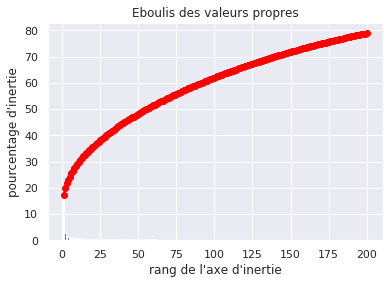

In [20]:
display_scree_plot(preparation_pipeline['dimensionality_reductor'].reductor)

# 2D visualization

In [21]:
pca = PCA(n_components=2, random_state=42)
X_transformed = pca.fit_transform(df_train)
X_test_transformed = pca.fit_transform(df_test)

In [22]:
X_transformed[:,1]

array([ 0.2471358 , -0.48030473,  0.28160926, ...,  0.22862047,
       -0.46101202,  0.28627627])

In [23]:
print('Binarisation of color categories')
bins = [-np.inf,df_train['TotalPricePerMonth'].quantile(0.25),\
        df_train['TotalPricePerMonth'].quantile(0.50),\
        df_train['TotalPricePerMonth'].quantile(0.75),\
        df_train['TotalPricePerMonth'].quantile(1)]

labels = [0, 1, 2, 3]

df_score_cat_train = pd.cut(df_train['TotalPricePerMonth'], bins=bins, labels=labels)


bins = [-np.inf,df_test['TotalPricePerMonth'].quantile(0.25),\
        df_test['TotalPricePerMonth'].quantile(0.50),\
        df_test['TotalPricePerMonth'].quantile(0.75),\
        df_test['TotalPricePerMonth'].quantile(1)]

labels = [0, 1, 2, 3]

df_score_cat_test = pd.cut(df_test['TotalPricePerMonth'], bins=bins, labels=labels)

Binarisation of color categories


Text(0, 0.5, 'Axe 2')

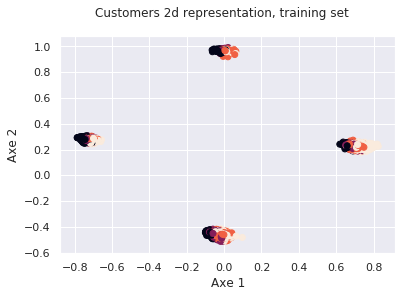

In [24]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [25]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients.html') 

'clusters_plot_clients.html'

Text(0, 0.5, 'Axe 2')

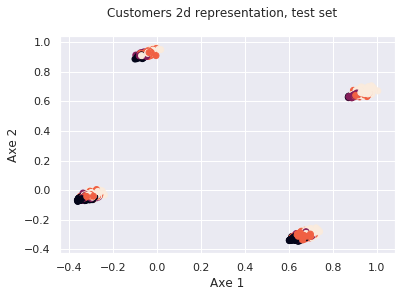

In [26]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, test set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_test_transformed[:,0], X_test_transformed[:,1], c=df_score_cat_test)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

# Generate bow colors

In [27]:
importlib.reload(sys.modules['functions'])
from functions import *

In [28]:
df_train = df_train_ori
df_test = df_test_ori

In [29]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'RfmScore'])),
    #('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth', 'TotalQuantityPerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    #('minmaxscaler', MinMaxScalerMultiple(features_toscale=['RfmScore'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='NCA', n_dim=1, labels_featurename='RfmScore')),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [30]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

/home/francois/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



In [31]:
df_train.loc[:, 0].to_numpy()

array([0.33538075, 0.619129  , 0.44806522, ..., 0.36293558, 0.452482  ,
       0.64851582])

In [32]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df_train.loc[:, 0].to_numpy().reshape(-1,1))
                for k in range(1, 50)]

In [33]:
labels_test_per_k = [model.predict(df_test.loc[:, 0].to_numpy().reshape(-1,1)) for model in kmeans_per_k[1:]]

In [34]:
silhouette_scores = [silhouette_score(df_train.loc[:, 0].to_numpy().reshape(-1,1), model.labels_)
                     for model in kmeans_per_k[1:]]

In [35]:
silhouette_scores_test = [silhouette_score(df_test.loc[:, 0].to_numpy().reshape(-1,1), labels_test) for labels_test in labels_test_per_k]

In [36]:
# Model corresponding to max silhouette score. We add +1 because "for model in kmeans_per_k[1:] above has suppressed one indice"
# kmeans_per_k[silhouette_scores.index(max(silhouette_scores)) + 1].labels_

In [37]:
entropy_mean_score_per_k_train = []

for model in kmeans_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(df_train['RfmScore'][model.labels_ == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_train.append(entropy_sum)

    
entropy_mean_score_per_k_test = []

for labels_test in labels_test_per_k:
    unique_labels = np.unique(labels_test)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(df_test['RfmScore'][labels_test == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_test.append(entropy_sum)    
    

/home/francois/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2614: RuntimeWarning:

invalid value encountered in true_divide



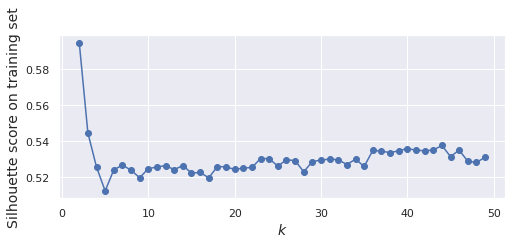

In [38]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

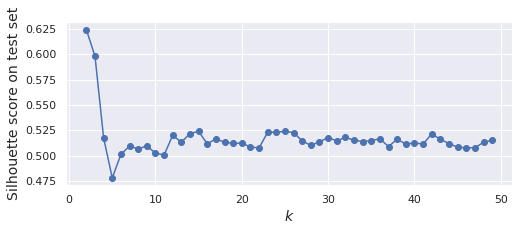

In [39]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [40]:
bow_labels_train = kmeans_per_k[10].labels_

In [41]:
bow_labels_test = kmeans_per_k[10].predict(df_test.loc[:, 0].to_numpy().reshape(-1,1))

# Model with only bag of word features, PCA

In [42]:
importlib.reload(sys.modules['functions'])
from functions import *

In [43]:
df_train = df_train_ori
df_test = df_test_ori


In [44]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    #('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    #('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='PCA', n_dim=200)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [45]:
df_train = preparation_pipeline.fit_transform(df_train)

In [46]:
df_test = preparation_pipeline.transform(df_test)

In [47]:
df_train

0         1         2         3         4         5         6  \
0     0.012337  0.471255  0.453895  0.473793  0.422515  0.477429  0.511299   
1     0.356103  0.422611  0.371563  0.401206  0.423753  0.459668  0.244695   
2     0.103371  0.307434  0.409747  0.364878  0.219234  0.380141  0.622568   
3     0.330665  0.428293  0.241569  0.239619  0.325675  0.390270  0.379993   
4     0.073958  0.425343  0.446213  0.538686  0.277486  0.450344  0.462819   
...        ...       ...       ...       ...       ...       ...       ...   
4327  0.065726  0.437382  0.430594  0.463784  0.332083  0.577169  0.449719   
4328  0.043881  0.360628  0.483579  0.481299  0.388442  0.438993  0.351419   
4329  0.104478  0.484576  0.220636  0.328119  0.405983  0.524318  0.437660   
4330  0.555281  0.163908  0.491656  0.360686  0.404089  0.404025  0.757682   
4331  0.231274  0.528386  0.659911  0.299427  0.257503  0.494932  0.598595   

             7         8         9        10        11        12        13  \
0     0.621572  0.503608  0.457640  0.488112  0.409851  0.507055  0.489921   
1     0.315718  0.324960  0.332577  0.361417  0.446315  0.447542  0.669783   
2     0.405009  0.446482  0.327183  0.559740  0.570360  0.614771  0.511387   
3     0.644576  0.617557  0.450200  0.457560  0.312062  0.629936  0.598997   
4     0.479767  0.508583  0.404837  0.429034  0.542592  0.385430  0.502766   
...        ...       ...       ...       ...       ...       ...       ...   
4327  0.555757  0.531172  0.374963  0.477719  0.642753  0.346193  0.486223   
4328  0.536795  0.537429  0.391859  0.591394  0.484468  0.526235  0.502483   
4329  0.466580  0.276274  0.435515  0.430024  0.562708  0.377260  0.484394   
4330  0.457156  0.857524  0.361941  0.660414  0.087293  0.391632  0.671431   
4331  0.352469  0.151850  0.535111  0.436187  0.214171  0.545815  0.827947   

            14        15        16        17        18        19        20  \
0     0.535112  0.450099  0.416215  0.433678  0.443110  0.493113  0.412216   
1     0.790501  0.482164  0.576499  0.752753  0.562993  0.737260  0.470347   
2     0.560368  0.436389  0.408881  0.598621  0.477201  0.664317  0.351395   
3     0.312526  0.235226  0.519489  0.271736  0.499319  0.317963  0.652768   
4     0.403973  0.552232  0.487449  0.446393  0.348799  0.393461  0.453952   
...        ...       ...       ...       ...       ...       ...       ...   
4327  0.347720  0.462146  0.495635  0.567033  0.474786  0.394094  0.429095   
4328  0.474550  0.468647  0.472686  0.449721  0.539173  0.412419  0.513710   
4329  0.659830  0.750543  0.450058  0.538172  0.420419  0.563899  0.377751   
4330  0.717217  0.433293  0.378400  0.609851  0.117578  0.205275  0.773628   
4331  0.320604  0.425448  0.630294  0.438199  0.439825  0.557399  0.391512   

            21        22        23        24        25        26        27  \
0     0.427219  0.473200  0.432093  0.528716  0.450216  0.459646  0.473048   
1     0.526157  0.381711  0.560419  0.457615  0.378896  0.394295  0.411293   
2     0.612083  0.650773  0.406559  0.506455  0.494282  0.547907  0.391580   
3     0.293780  0.557688  0.049582  0.363470  0.553773  0.540428  0.455714   
4     0.371212  0.552085  0.541138  0.432025  0.366758  0.629723  0.628654   
...        ...       ...       ...       ...       ...       ...       ...   
4327  0.316267  0.473669  0.458605  0.516340  0.476405  0.469674  0.393134   
4328  0.513390  0.493658  0.516190  0.594272  0.381003  0.435380  0.426950   
4329  0.414882  0.651104  0.378551  0.514956  0.501087  0.460818  0.400513   
4330  0.489875  0.367007  0.308803  0.423619  0.503075  0.363306  0.554256   
4331  0.501134  0.479335  0.252846  0.487499  0.437485  0.555162  0.378684   

            28        29        30        31        32        33        34  \
0     0.433343  0.488316  0.503164  0.400001  0.584752  0.447438  0.492680   
1     0.531512  0.580637  0.551046  0.628213  0.473105  0.278695  0.419523   
2     0.488402  0.535292  0.661

In [48]:
pca = PCA(n_components=2, random_state=42)
X_transformed = pca.fit_transform(df_train)
X_test_transformed = pca.fit_transform(df_test)

'''
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)
'''

'\ntsne = TSNE(n_components=2, random_state=42)\nX_transformed = tsne.fit_transform(df_train)\nX_test_transformed = tsne.fit_transform(df_test)\n'

Text(0, 0.5, 'Axe 2')

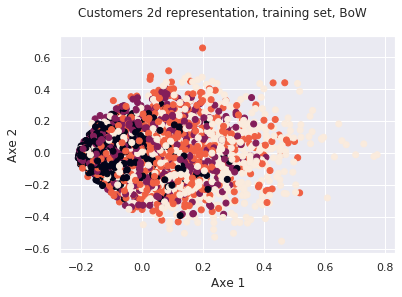

In [49]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set, BoW')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

Text(0, 0.5, 'Axe 2')

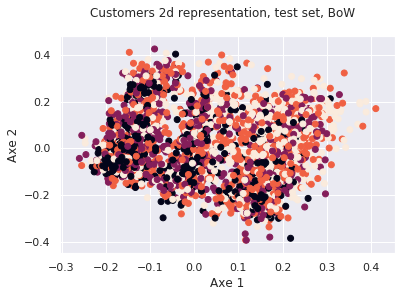

In [50]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, test set, BoW')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_test_transformed[:,0], X_test_transformed[:,1], c=df_score_cat_test)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [51]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_score_cat_train,
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_onlybow.html') 

'clusters_plot_clients_onlybow.html'

## Clustering test

In [52]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df_train)
                for k in range(1, 50)]

In [53]:
labels_test_per_k = [model.predict(df_test) for model in kmeans_per_k[1:]]

In [54]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in kmeans_per_k[1:]]

In [55]:
silhouette_scores_test = [silhouette_score(df_test, labels_test) for labels_test in labels_test_per_k]

In [56]:
entropy_mean_score_per_k_train = []

for model in kmeans_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(series_total_price_per_month_train[model.labels_ == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_train.append(entropy_sum)

    
entropy_mean_score_per_k_test = []

for labels_test in labels_test_per_k:
    unique_labels = np.unique(labels_test)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(series_total_price_per_month_test[labels_test == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_test.append(entropy_sum)    
    

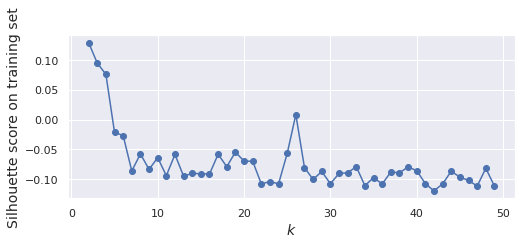

In [57]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

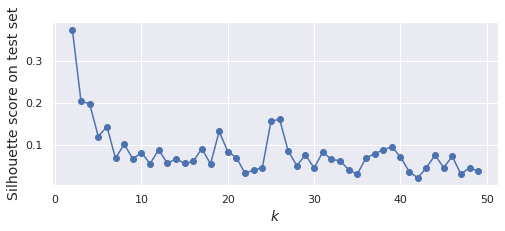

In [58]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [59]:
print('Entropy before clustering :')
entropy(series_total_price_per_month_train)

Entropy before clustering :


8.340339103018163

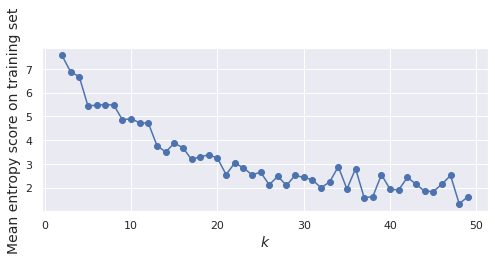

In [60]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

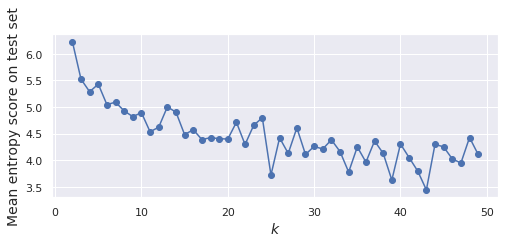

In [61]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

## 2nd clustering : ward

In [62]:
clusterer_per_k = [AgglomerativeClustering(n_clusters=k, affinity='euclidean').fit(df_train) for k in range(1,50)]

In [63]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in clusterer_per_k[1:]]

In [64]:
entropy_mean_score_per_k_train = []

for model in clusterer_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(series_total_price_per_month_train[model.labels_ == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_train.append(entropy_sum)

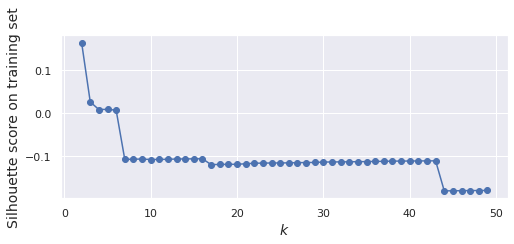

In [65]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [66]:
print('Entropy before clustering :')
entropy(series_total_price_per_month_train)

Entropy before clustering :


8.340339103018163

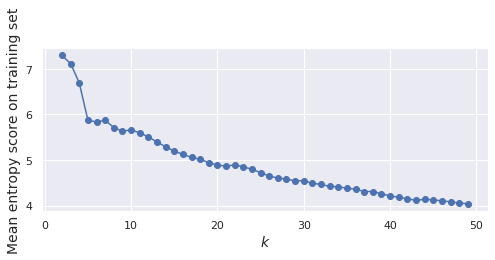

In [67]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

# Model with only bag of word features, TSNE

In [68]:
importlib.reload(sys.modules['functions'])
from functions import *

In [69]:
df_train = df_train_ori
df_test = df_test_ori


In [70]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    #('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    #('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='TSNE', n_dim=3)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [71]:
df_train = preparation_pipeline.fit_transform(df_train)

No fit for TSNE


In [72]:
df_test = preparation_pipeline.transform(df_test)

In [73]:
df_train

0         1         2
0     0.783543  0.628913  0.878636
1     0.727786  0.430184  0.704302
2     0.741093  0.560714  0.462285
3     0.648290  0.514565  0.458161
4     0.759664  0.587738  0.564628
...        ...       ...       ...
4327  0.747399  0.632402  0.684291
4328  0.766730  0.647952  0.548147
4329  0.716419  0.469840  0.643490
4330  0.727965  0.528250  0.312737
4331  0.902739  0.582266  0.476758

[4332 rows x 3 columns]

In [74]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

Text(0, 0.5, 'Axe 2')

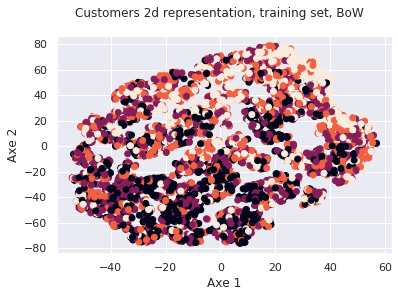

In [75]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set, BoW')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

Text(0, 0.5, 'Axe 2')

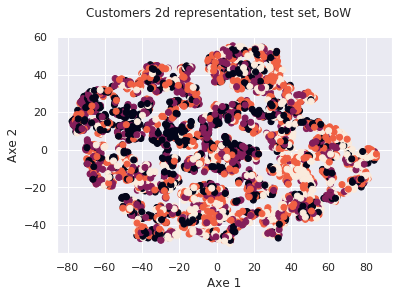

In [76]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, test set, BoW')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_test_transformed[:,0], X_test_transformed[:,1], c=df_score_cat_test)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [77]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_score_cat_train,
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_onlybow_TSNE.html') 

'clusters_plot_clients_onlybow_TSNE.html'

## Clustering test

In [78]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df_train)
                for k in range(1, 50)]

In [79]:
labels_test_per_k = [model.predict(df_test) for model in kmeans_per_k[1:]]

In [80]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in kmeans_per_k[1:]]

In [81]:
silhouette_scores_test = [silhouette_score(df_test, labels_test) for labels_test in labels_test_per_k]

In [82]:
entropy_mean_score_per_k_train = []

for model in kmeans_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(series_total_price_per_month_train[model.labels_ == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_train.append(entropy_sum)

    
entropy_mean_score_per_k_test = []

for labels_test in labels_test_per_k:
    unique_labels = np.unique(labels_test)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(series_total_price_per_month_test[labels_test == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_test.append(entropy_sum)    
    

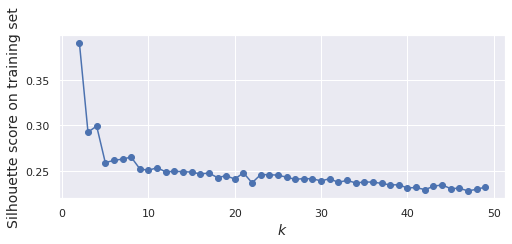

In [83]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

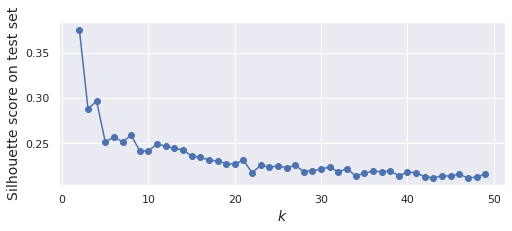

In [84]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [85]:
print('Entropy before clustering :')
entropy(series_total_price_per_month_train)

Entropy before clustering :


8.340339103018163

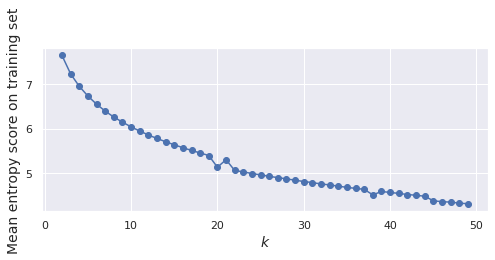

In [86]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

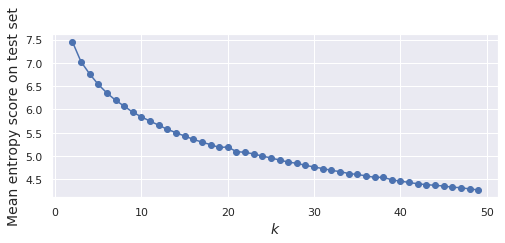

In [87]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

## 2nd clustering : ward

In [88]:
clusterer_per_k = [AgglomerativeClustering(n_clusters=k, affinity='euclidean').fit(df_train) for k in range(1,50)]

In [89]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in clusterer_per_k[1:]]

In [90]:
entropy_mean_score_per_k_train = []

for model in clusterer_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(series_total_price_per_month_train[model.labels_ == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_train.append(entropy_sum)

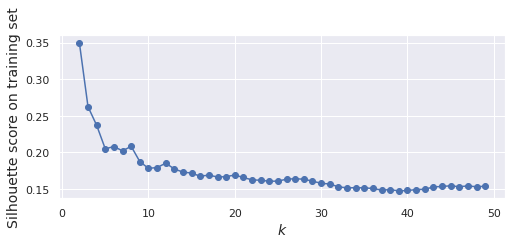

In [91]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [92]:
print('Entropy before clustering :')
entropy(series_total_price_per_month_train)

Entropy before clustering :


8.340339103018163

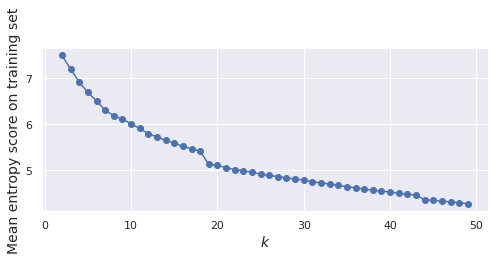

In [93]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

# Model with only bow features and TotalPricePerMonth, TSNE

In [94]:
importlib.reload(sys.modules['functions'])
from functions import *

In [95]:
df_train = df_train_ori
df_test = df_test_ori


In [96]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    #('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    #('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='TSNE', n_dim=3)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [97]:
df_train = preparation_pipeline.fit_transform(df_train)

No fit for TSNE


In [98]:
df_test = preparation_pipeline.transform(df_test)

In [99]:
df_train

TotalPricePerMonth         0         1         2
CustomerID                                                  
12346                 0.289049  0.783543  0.628913  0.878636
12347                 0.013128  0.727786  0.430184  0.704302
12348                 0.004822  0.741093  0.560714  0.462285
12349                 0.051691  0.648290  0.514565  0.458161
12350                 0.001098  0.759664  0.587738  0.564628
...                        ...       ...       ...       ...
18280                 0.000689  0.747399  0.632402  0.684291
18281                 0.000546  0.766730  0.647952  0.548147
18282                 0.001672  0.716419  0.469840  0.643490
18283                 0.006640  0.727965  0.528250  0.312737
18287                 0.010199  0.902739  0.582266  0.476758

[4332 rows x 4 columns]

In [100]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

Text(0, 0.5, 'Axe 2')

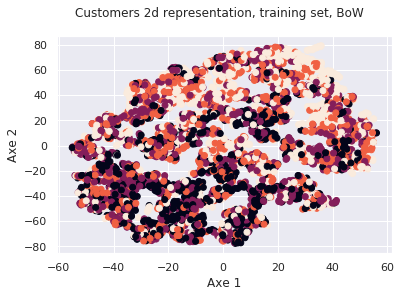

In [101]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set, BoW')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

Text(0, 0.5, 'Axe 2')

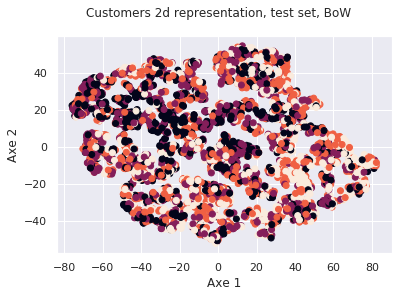

In [102]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, test set, BoW')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_test_transformed[:,0], X_test_transformed[:,1], c=df_score_cat_test)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [103]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_score_cat_train,
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_onlybow_TSNE.html') 

'clusters_plot_clients_onlybow_TSNE.html'

## Clustering test

In [104]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df_train)
                for k in range(1, 50)]

In [105]:
labels_test_per_k = [model.predict(df_test) for model in kmeans_per_k[1:]]

In [106]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in kmeans_per_k[1:]]

In [107]:
silhouette_scores_test = [silhouette_score(df_test, labels_test) for labels_test in labels_test_per_k]

In [108]:
entropy_mean_score_per_k_train = []

for model in kmeans_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(series_total_price_per_month_train[model.labels_ == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_train.append(entropy_sum)

    
entropy_mean_score_per_k_test = []

for labels_test in labels_test_per_k:
    unique_labels = np.unique(labels_test)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(series_total_price_per_month_test[labels_test == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_test.append(entropy_sum)    
    

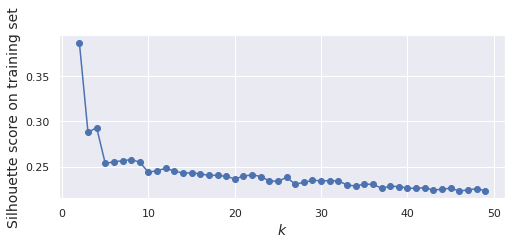

In [109]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

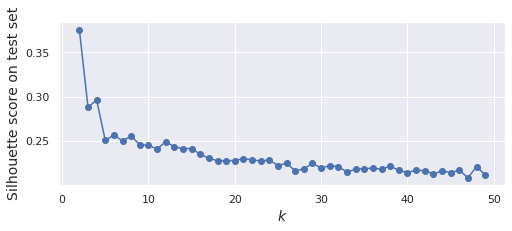

In [110]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [111]:
print('Entropy before clustering :')
entropy(series_total_price_per_month_train)

Entropy before clustering :


8.340339103018163

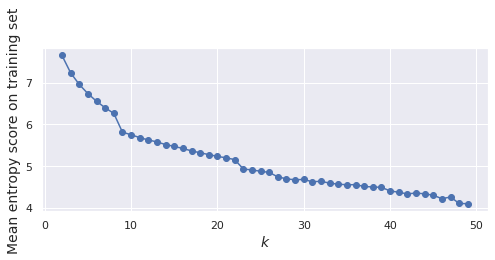

In [112]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

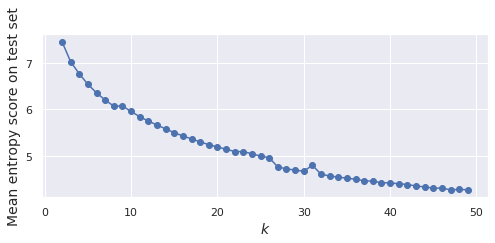

In [113]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

## 2nd clustering : ward

In [114]:
clusterer_per_k = [AgglomerativeClustering(n_clusters=k, affinity='euclidean').fit(df_train) for k in range(1,50)]

In [115]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in clusterer_per_k[1:]]

In [116]:
entropy_mean_score_per_k_train = []

for model in clusterer_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(series_total_price_per_month_train[model.labels_ == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_train.append(entropy_sum)

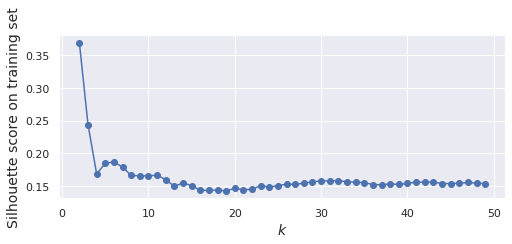

In [117]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [118]:
print('Entropy before clustering :')
entropy(series_total_price_per_month_train)

Entropy before clustering :


8.340339103018163

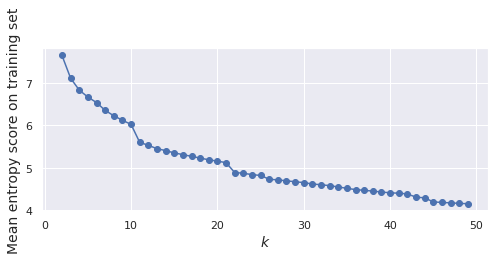

In [119]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

# Model with bow features + TotalPricePerMonth

In [120]:
importlib.reload(sys.modules['functions'])
from functions import *

In [121]:
df_train = df_train_ori
df_test = df_test_ori


In [122]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    #('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    #('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='PCA', n_dim=200)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [123]:
df_train = preparation_pipeline.fit_transform(df_train)

In [124]:
df_test = preparation_pipeline.transform(df_test)

In [125]:
df_train

TotalPricePerMonth         0         1         2         3  \
CustomerID                                                               
12346                 0.289049  0.012337  0.471255  0.453895  0.473793   
12347                 0.013128  0.356103  0.422611  0.371563  0.401206   
12348                 0.004822  0.103371  0.307434  0.409747  0.364878   
12349                 0.051691  0.330665  0.428293  0.241569  0.239619   
12350                 0.001098  0.073958  0.425343  0.446213  0.538686   
...                        ...       ...       ...       ...       ...   
18280                 0.000689  0.065726  0.437382  0.430594  0.463784   
18281                 0.000546  0.043881  0.360628  0.483579  0.481299   
18282                 0.001672  0.104478  0.484576  0.220636  0.328119   
18283                 0.006640  0.555281  0.163908  0.491656  0.360686   
18287                 0.010199  0.231274  0.528386  0.659911  0.299427   

                   4         5         6         7         8         9  \
CustomerID                                                               
12346       0.422515  0.477429  0.511299  0.621572  0.503608  0.457640   
12347       0.423753  0.459668  0.244695  0.315718  0.324960  0.332577   
12348       0.219234  0.380141  0.622568  0.405009  0.446482  0.327183   
12349       0.325675  0.390270  0.379993  0.644576  0.617557  0.450200   
12350       0.277486  0.450344  0.462819  0.479767  0.508583  0.404837   
...              ...       ...       ...       ...       ...       ...   
18280       0.332083  0.577169  0.449719  0.555757  0.531172  0.374963   
18281       0.388442  0.438993  0.351419  0.536795  0.537429  0.391859   
18282       0.405983  0.524318  0.437660  0.466580  0.276274  0.435515   
18283       0.404089  0.404025  0.757682  0.457156  0.857524  0.361941   
18287       0.257503  0.494932  0.598595  0.352469  0.151850  0.535111   

                  10        11        12        13        14        15  \
CustomerID                                                               
12346       0.488112  0.409851  0.507055  0.489921  0.535112  0.450099   
12347       0.361417  0.446315  0.447542  0.669783  0.790501  0.482164   
12348       0.559740  0.570360  0.614771  0.511387  0.560368  0.436389   
12349       0.457560  0.312062  0.629936  0.598997  0.312526  0.235226   
12350       0.429034  0.542592  0.385430  0.502766  0.403973  0.552232   
...              ...       ...       ...       ...       ...       ...   
18280       0.477719  0.642753  0.346193  0.486223  0.347720  0.462146   
18281       0.591394  0.484468  0.526235  0.502483  0.474550  0.468647   
18282       0.430024  0.562708  0.377260  0.484394  0.659830  0.750543   
18283       0.660414  0.087293  0.391632  0.671431  0.717217  0.433293   
18287       0.436187  0.214171  0.545815  0.827947  0.320604  0.425448   

                  16        17        18        19        20        21  \
CustomerID                                                               
12346       0.416215  0.433678  0.443110  0.493113  0.412216  0.427219   
12347       0.576499  0.752753  0.562993  0.737260  0.470347  0.526157   
12348       0.408881  0.598621  0.477201  0.664317  0.351395  0.612083   
12349       0.519489  0.271736  0.499319  0.317963  0.652768  0.293780   
12350       0.487449  0.446393  0.348799  0.393461  0.453952  0.371212   
...              ...       ...       ...       ...       ...       ...   
18280       0.495635  0.567033  0.474786  0.394094  0.429095  0.316267   
18281       0.472686  0.449721  0.539173  0.412419  0.513710  0.513390   
18282       0.450058  0.538172  0.420419  0.563899  0.377751  0.414882   
18283       0.378400  0.609851  0.117578  0.205275  0.773628  0.489875   
18287       0.630294  0.438199  0.439825  0.557399  0.391512  0.501134   

                  22        23        24        25        26        27  \
CustomerID                                                               
12346       

In [126]:
pca = PCA(n_components=2, random_state=42)
X_transformed = pca.fit_transform(df_train)
X_test_transformed = pca.fit_transform(df_test)

Text(0, 0.5, 'Axe 2')

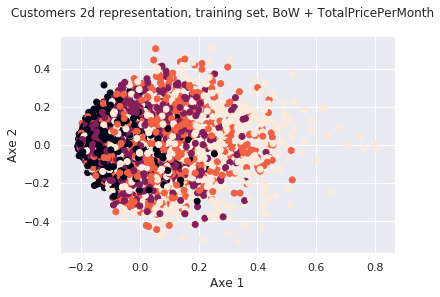

In [127]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set, BoW + TotalPricePerMonth')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [128]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_score_cat_train,
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_onlybow.html') 

'clusters_plot_clients_onlybow.html'

# Model with bow features + TotalPricePerMonth + HasEverCancelled

In [129]:
importlib.reload(sys.modules['functions'])
from functions import *

In [130]:
df_train = df_train_ori
df_test = df_test_ori


In [131]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    #('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    #('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'TotalPricePerMonth', 'HasEverCancelled'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='PCA', n_dim=200)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [132]:
df_train = preparation_pipeline.fit_transform(df_train)

In [133]:
df_test = preparation_pipeline.transform(df_test)

In [134]:
df_train

TotalPricePerMonth  HasEverCancelled         0         1  \
CustomerID                                                             
12346                 0.289049               1.0  0.012337  0.471255   
12347                 0.013128               0.0  0.356103  0.422611   
12348                 0.004822               0.0  0.103371  0.307434   
12349                 0.051691               0.0  0.330665  0.428293   
12350                 0.001098               0.0  0.073958  0.425343   
...                        ...               ...       ...       ...   
18280                 0.000689               0.0  0.065726  0.437382   
18281                 0.000546               0.0  0.043881  0.360628   
18282                 0.001672               1.0  0.104478  0.484576   
18283                 0.006640               0.0  0.555281  0.163908   
18287                 0.010199               0.0  0.231274  0.528386   

                   2         3         4         5         6         7  \
CustomerID                                                               
12346       0.453895  0.473793  0.422515  0.477429  0.511299  0.621572   
12347       0.371563  0.401206  0.423753  0.459668  0.244695  0.315718   
12348       0.409747  0.364878  0.219234  0.380141  0.622568  0.405009   
12349       0.241569  0.239619  0.325675  0.390270  0.379993  0.644576   
12350       0.446213  0.538686  0.277486  0.450344  0.462819  0.479767   
...              ...       ...       ...       ...       ...       ...   
18280       0.430594  0.463784  0.332083  0.577169  0.449719  0.555757   
18281       0.483579  0.481299  0.388442  0.438993  0.351419  0.536795   
18282       0.220636  0.328119  0.405983  0.524318  0.437660  0.466580   
18283       0.491656  0.360686  0.404089  0.404025  0.757682  0.457156   
18287       0.659911  0.299427  0.257503  0.494932  0.598595  0.352469   

                   8         9        10        11        12        13  \
CustomerID                                                               
12346       0.503608  0.457640  0.488112  0.409851  0.507055  0.489921   
12347       0.324960  0.332577  0.361417  0.446315  0.447542  0.669783   
12348       0.446482  0.327183  0.559740  0.570360  0.614771  0.511387   
12349       0.617557  0.450200  0.457560  0.312062  0.629936  0.598997   
12350       0.508583  0.404837  0.429034  0.542592  0.385430  0.502766   
...              ...       ...       ...       ...       ...       ...   
18280       0.531172  0.374963  0.477719  0.642753  0.346193  0.486223   
18281       0.537429  0.391859  0.591394  0.484468  0.526235  0.502483   
18282       0.276274  0.435515  0.430024  0.562708  0.377260  0.484394   
18283       0.857524  0.361941  0.660414  0.087293  0.391632  0.671431   
18287       0.151850  0.535111  0.436187  0.214171  0.545815  0.827947   

                  14        15        16        17        18        19  \
CustomerID                                                               
12346       0.535112  0.450099  0.416215  0.433678  0.443110  0.493113   
12347       0.790501  0.482164  0.576499  0.752753  0.562993  0.737260   
12348       0.560368  0.436389  0.408881  0.598621  0.477201  0.664317   
12349       0.312526  0.235226  0.519489  0.271736  0.499319  0.317963   
12350       0.403973  0.552232  0.487449  0.446393  0.348799  0.393461   
...              ...       ...       ...       ...       ...       ...   
18280       0.347720  0.462146  0.495635  0.567033  0.474786  0.394094   
18281       0.474550  0.468647  0.472686  0.449721  0.539173  0.412419   
18282       0.659830  0.750543  0.450058  0.538172  0.420419  0.563899   
18283       0.717217  0.433293  0.378400  0.609851  0.117578  0.205275   
18287       0.320604  0.425448  0.630294  0.438199  0.439825  0.557399   

                  20        21        22        23        24        25  \
CustomerID                                                               
12346       0.412216  0.427219  0.4732

In [135]:
pca = PCA(n_components=2, random_state=42)
X_transformed = pca.fit_transform(df_train)
X_test_transformed = pca.fit_transform(df_test)

Text(0, 0.5, 'Axe 2')

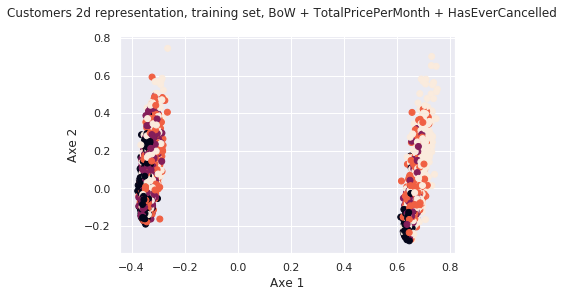

In [136]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set, BoW + TotalPricePerMonth + HasEverCancelled')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [137]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_score_cat_train,
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_onlybow.html') 

'clusters_plot_clients_onlybow.html'

# Model with all features and NCA

In [138]:
importlib.reload(sys.modules['functions'])
from functions import *

In [139]:
df_train = df_train_ori
df_test = df_test_ori

In [140]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='NCA', n_dim=200, labels_featurename='TotalPricePerMonth')),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [141]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

In [142]:
df_train

BoughtTopValueProduct  TotalPricePerMonth  HasEverCancelled  \
CustomerID                                                                
12346                         1.0            0.877446               1.0   
12347                         1.0            0.572415               0.0   
12348                         0.0            0.474029               0.0   
12349                         1.0            0.707529               0.0   
12350                         0.0            0.330609               0.0   
...                           ...                 ...               ...   
18280                         0.0            0.286691               0.0   
18281                         0.0            0.265155               0.0   
18282                         1.0            0.370964               1.0   
18283                         1.0            0.505393               0.0   
18287                         0.0            0.547572               0.0   

                   0         1         2         3         4         5  \
CustomerID                                                               
12346       0.046983  0.544162  0.569010  0.578984  0.604324  0.257648   
12347       0.564794  0.425418  0.464870  0.538003  0.447188  0.395250   
12348       0.228890  0.465449  0.610888  0.517569  0.533763  0.218619   
12349       0.370229  0.349728  0.318196  0.424990  0.513333  0.347236   
12350       0.161225  0.438421  0.616754  0.630383  0.507210  0.288784   
...              ...       ...       ...       ...       ...       ...   
18280       0.086734  0.455771  0.574675  0.639160  0.565182  0.351370   
18281       0.089450  0.426684  0.607303  0.563269  0.654445  0.255308   
18282       0.115471  0.565695  0.358744  0.517463  0.717624  0.262040   
18283       0.618828  0.242817  0.458706  0.413288  0.656783  0.577393   
18287       0.344179  0.555663  0.642568  0.474694  0.361413  0.319666   

                   6         7         8         9        10        11  \
CustomerID                                                               
12346       0.551413  0.727304  0.363242  0.645852  0.279837  0.671140   
12347       0.310058  0.561618  0.280745  0.547363  0.316086  0.533782   
12348       0.570450  0.714599  0.416324  0.585073  0.395716  0.639417   
12349       0.358678  0.437545  0.547634  0.718109  0.488459  0.388120   
12350       0.560663  0.691022  0.286856  0.607965  0.150699  0.679833   
...              ...       ...       ...       ...       ...       ...   
18280       0.456992  0.774996  0.410526  0.520118  0.253824  0.740606   
18281       0.457569  0.774950  0.331244  0.622195  0.341458  0.723869   
18282       0.497292  0.579957  0.199569  0.644370  0.223924  0.699772   
18283       0.713355  0.536244  0.815704  0.359640  0.795237  0.319325   
18287       0.386782  0.544669  0.334965  0.538026  0.470905  0.511760   

                  12        13        14        15        16        17  \
CustomerID                                                               
12346       0.366633  0.580891  0.412079  0.556849  0.357000  0.543681   
12347       0.446466  0.543122  0.500716  0.182959  0.714377  0.663975   
12348       0.411343  0.558621  0.485376  0.558322  0.562144  0.576066   
12349       0.634334  0.425746  0.176352  0.201610  0.577118  0.323702   
12350       0.231700  0.623110  0.294364  0.551491  0.452044  0.467461   
...              ...       ...       ...       ...       ...       ...   
18280       0.275192  0.516310  0.285090  0.536899  0.473054  0.566778   
18281       0.373636  0.584424  0.359368  0.590812  0.382831  0.551935   
18282       0.279578  0.375773  0.515164  0.705660  0.434731  0.524383   
18283       0.494567  0.255317  0.490748  0.350031  0.715747  0.546561   
18287       0.380630  0.687802  0.437565  0.492471  0.613265  0.546898   

                  18        19        20        21        22        23  \
CustomerID                                                               

In [143]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4332 entries, 12346 to 18287
Columns: 203 entries, BoughtTopValueProduct to 199
dtypes: float64(203)
memory usage: 6.7+ MB


In [144]:
pca = PCA(n_components=2,random_state=42)
X_transformed = pca.fit_transform(df_train)
X_test_transformed = pca.fit_transform(df_test)

In [145]:
X_transformed[:,1]

array([-0.96461587,  0.48369184,  0.34920333, ..., -0.88712256,
        0.91930946,  0.49263187])

Text(0, 0.5, 'Axe 2')

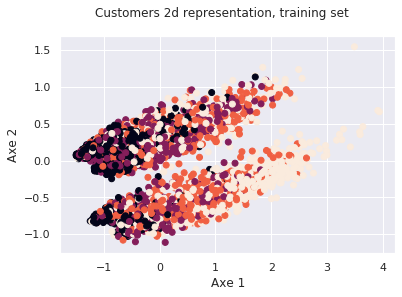

In [146]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [147]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_nca_allfeats.html') 

'clusters_plot_clients_nca_allfeats.html'

# Model with all features and NCA, final representation with tSNE

In [148]:
importlib.reload(sys.modules['functions'])
from functions import *

In [149]:
df_train = df_train_ori
df_test = df_test_ori

In [150]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='NCA', n_dim=200, labels_featurename='TotalPricePerMonth')),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [151]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

In [152]:
df_train

BoughtTopValueProduct  TotalPricePerMonth  HasEverCancelled  \
CustomerID                                                                
12346                         1.0            0.877446               1.0   
12347                         1.0            0.572415               0.0   
12348                         0.0            0.474029               0.0   
12349                         1.0            0.707529               0.0   
12350                         0.0            0.330609               0.0   
...                           ...                 ...               ...   
18280                         0.0            0.286691               0.0   
18281                         0.0            0.265155               0.0   
18282                         1.0            0.370964               1.0   
18283                         1.0            0.505393               0.0   
18287                         0.0            0.547572               0.0   

                   0         1         2         3         4         5  \
CustomerID                                                               
12346       0.046983  0.544162  0.569010  0.578984  0.604324  0.257648   
12347       0.564794  0.425418  0.464870  0.538003  0.447188  0.395250   
12348       0.228890  0.465449  0.610888  0.517569  0.533763  0.218619   
12349       0.370229  0.349728  0.318196  0.424990  0.513333  0.347236   
12350       0.161225  0.438421  0.616754  0.630383  0.507210  0.288784   
...              ...       ...       ...       ...       ...       ...   
18280       0.086734  0.455771  0.574675  0.639160  0.565182  0.351370   
18281       0.089450  0.426684  0.607303  0.563269  0.654445  0.255308   
18282       0.115471  0.565695  0.358744  0.517463  0.717624  0.262040   
18283       0.618828  0.242817  0.458706  0.413288  0.656783  0.577393   
18287       0.344179  0.555663  0.642568  0.474694  0.361413  0.319666   

                   6         7         8         9        10        11  \
CustomerID                                                               
12346       0.551413  0.727304  0.363242  0.645852  0.279837  0.671140   
12347       0.310058  0.561618  0.280745  0.547363  0.316086  0.533782   
12348       0.570450  0.714599  0.416324  0.585073  0.395716  0.639417   
12349       0.358678  0.437545  0.547634  0.718109  0.488459  0.388120   
12350       0.560663  0.691022  0.286856  0.607965  0.150699  0.679833   
...              ...       ...       ...       ...       ...       ...   
18280       0.456992  0.774996  0.410526  0.520118  0.253824  0.740606   
18281       0.457569  0.774950  0.331244  0.622195  0.341458  0.723869   
18282       0.497292  0.579957  0.199569  0.644370  0.223924  0.699772   
18283       0.713355  0.536244  0.815704  0.359640  0.795237  0.319325   
18287       0.386782  0.544669  0.334965  0.538026  0.470905  0.511760   

                  12        13        14        15        16        17  \
CustomerID                                                               
12346       0.366633  0.580891  0.412079  0.556849  0.357000  0.543681   
12347       0.446466  0.543122  0.500716  0.182959  0.714377  0.663975   
12348       0.411343  0.558621  0.485376  0.558322  0.562144  0.576066   
12349       0.634334  0.425746  0.176352  0.201610  0.577118  0.323702   
12350       0.231700  0.623110  0.294364  0.551491  0.452044  0.467461   
...              ...       ...       ...       ...       ...       ...   
18280       0.275192  0.516310  0.285090  0.536899  0.473054  0.566778   
18281       0.373636  0.584424  0.359368  0.590812  0.382831  0.551935   
18282       0.279578  0.375773  0.515164  0.705660  0.434731  0.524383   
18283       0.494567  0.255317  0.490748  0.350031  0.715747  0.546561   
18287       0.380630  0.687802  0.437565  0.492471  0.613265  0.546898   

                  18        19        20        21        22        23  \
CustomerID                                                               

In [153]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4332 entries, 12346 to 18287
Columns: 203 entries, BoughtTopValueProduct to 199
dtypes: float64(203)
memory usage: 6.7+ MB


In [154]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

In [155]:
X_transformed[:,1]

array([ 22.097382,  21.037863, -29.664833, ...,  24.173304,  31.831484,
       -29.181562], dtype=float32)

Text(0, 0.5, 'Axe 2')

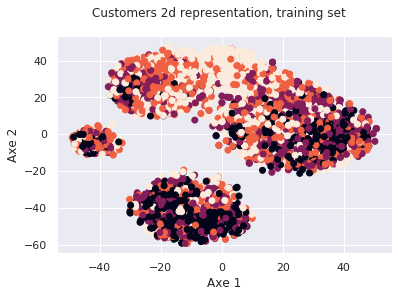

In [156]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [157]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_nca_allfeats_final_tsne.html') 

'clusters_plot_clients_nca_allfeats_final_tsne.html'

# Model with all features and PCA, final representation with tSNE

In [158]:
importlib.reload(sys.modules['functions'])
from functions import *

In [159]:
df_train = df_train_ori
df_test = df_test_ori

In [160]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='PCA', n_dim=200)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [161]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

In [162]:
df_train

BoughtTopValueProduct  TotalPricePerMonth  HasEverCancelled  \
CustomerID                                                                
12346                         1.0            0.877446               1.0   
12347                         1.0            0.572415               0.0   
12348                         0.0            0.474029               0.0   
12349                         1.0            0.707529               0.0   
12350                         0.0            0.330609               0.0   
...                           ...                 ...               ...   
18280                         0.0            0.286691               0.0   
18281                         0.0            0.265155               0.0   
18282                         1.0            0.370964               1.0   
18283                         1.0            0.505393               0.0   
18287                         0.0            0.547572               0.0   

                   0         1         2         3         4         5  \
CustomerID                                                               
12346       0.012337  0.471255  0.453895  0.473793  0.422515  0.477429   
12347       0.356103  0.422611  0.371563  0.401206  0.423753  0.459668   
12348       0.103371  0.307434  0.409747  0.364878  0.219234  0.380141   
12349       0.330665  0.428293  0.241569  0.239619  0.325675  0.390270   
12350       0.073958  0.425343  0.446213  0.538686  0.277486  0.450344   
...              ...       ...       ...       ...       ...       ...   
18280       0.065726  0.437382  0.430594  0.463784  0.332083  0.577169   
18281       0.043881  0.360628  0.483579  0.481299  0.388442  0.438993   
18282       0.104478  0.484576  0.220636  0.328119  0.405983  0.524318   
18283       0.555281  0.163908  0.491656  0.360686  0.404089  0.404025   
18287       0.231274  0.528386  0.659911  0.299427  0.257503  0.494932   

                   6         7         8         9        10        11  \
CustomerID                                                               
12346       0.511299  0.621572  0.503608  0.457640  0.488112  0.409851   
12347       0.244695  0.315718  0.324960  0.332577  0.361417  0.446315   
12348       0.622568  0.405009  0.446482  0.327183  0.559740  0.570360   
12349       0.379993  0.644576  0.617557  0.450200  0.457560  0.312062   
12350       0.462819  0.479767  0.508583  0.404837  0.429034  0.542592   
...              ...       ...       ...       ...       ...       ...   
18280       0.449719  0.555757  0.531172  0.374963  0.477719  0.642753   
18281       0.351419  0.536795  0.537429  0.391859  0.591394  0.484468   
18282       0.437660  0.466580  0.276274  0.435515  0.430024  0.562708   
18283       0.757682  0.457156  0.857524  0.361941  0.660414  0.087293   
18287       0.598595  0.352469  0.151850  0.535111  0.436187  0.214171   

                  12        13        14        15        16        17  \
CustomerID                                                               
12346       0.507055  0.489921  0.535112  0.450099  0.416215  0.433678   
12347       0.447542  0.669783  0.790501  0.482164  0.576499  0.752753   
12348       0.614771  0.511387  0.560368  0.436389  0.408881  0.598621   
12349       0.629936  0.598997  0.312526  0.235226  0.519489  0.271736   
12350       0.385430  0.502766  0.403973  0.552232  0.487449  0.446393   
...              ...       ...       ...       ...       ...       ...   
18280       0.346193  0.486223  0.347720  0.462146  0.495635  0.567033   
18281       0.526235  0.502483  0.474550  0.468647  0.472686  0.449721   
18282       0.377260  0.484394  0.659830  0.750543  0.450058  0.538172   
18283       0.391632  0.671431  0.717217  0.433293  0.378400  0.609851   
18287       0.545815  0.827947  0.320604  0.425448  0.630294  0.438199   

                  18        19        20        21        22        23  \
CustomerID                                                               

In [163]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4332 entries, 12346 to 18287
Columns: 203 entries, BoughtTopValueProduct to 199
dtypes: float64(203)
memory usage: 6.7+ MB


In [164]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

In [165]:
X_transformed[:,1]

array([ 10.128316  , -10.440334  ,  -0.33006346, ...,  10.081147  ,
       -16.101868  ,   2.3950124 ], dtype=float32)

Text(0, 0.5, 'Axe 2')

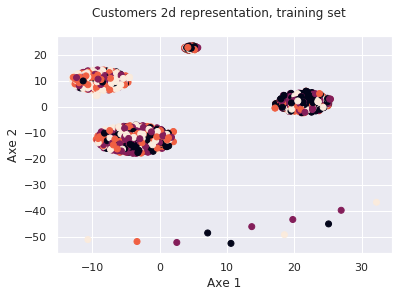

In [166]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [167]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_pca_allfeats_final_tsne.html') 

'clusters_plot_clients_pca_allfeats_final_tsne.html'

# Model with all features and tSNE, final representation with tSNE (2ND BEST)

In [168]:
importlib.reload(sys.modules['functions'])
from functions import *

In [169]:
df_train = df_train_ori
df_test = df_test_ori

In [170]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='TSNE', n_dim=3)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [171]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

No fit for TSNE


In [172]:
df_train

BoughtTopValueProduct  TotalPricePerMonth  HasEverCancelled  \
CustomerID                                                                
12346                         1.0            0.877446               1.0   
12347                         1.0            0.572415               0.0   
12348                         0.0            0.474029               0.0   
12349                         1.0            0.707529               0.0   
12350                         0.0            0.330609               0.0   
...                           ...                 ...               ...   
18280                         0.0            0.286691               0.0   
18281                         0.0            0.265155               0.0   
18282                         1.0            0.370964               1.0   
18283                         1.0            0.505393               0.0   
18287                         0.0            0.547572               0.0   

                   0         1         2  
CustomerID                                
12346       0.783543  0.628913  0.878636  
12347       0.727786  0.430184  0.704302  
12348       0.741093  0.560714  0.462285  
12349       0.648290  0.514565  0.458161  
12350       0.759664  0.587738  0.564628  
...              ...       ...       ...  
18280       0.747399  0.632402  0.684291  
18281       0.766730  0.647952  0.548147  
18282       0.716419  0.469840  0.643490  
18283       0.727965  0.528250  0.312737  
18287       0.902739  0.582266  0.476758  

[4332 rows x 6 columns]

In [173]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4332 entries, 12346 to 18287
Data columns (total 6 columns):
BoughtTopValueProduct    4332 non-null float64
TotalPricePerMonth       4332 non-null float64
HasEverCancelled         4332 non-null float64
0                        4332 non-null float64
1                        4332 non-null float64
2                        4332 non-null float64
dtypes: float64(6)
memory usage: 236.9+ KB


In [174]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

In [175]:
X_transformed[:,1]

array([-12.465547,  20.816553, -38.893944, ...,  -5.508614,  51.804184,
       -56.67659 ], dtype=float32)

Text(0, 0.5, 'Axe 2')

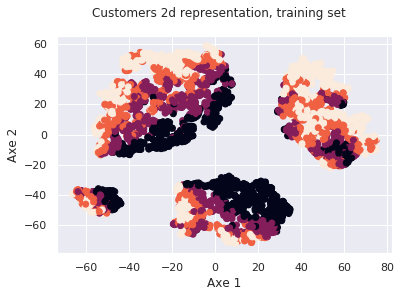

In [176]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [177]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_allfeats_final_tsne.html') 

'clusters_plot_clients_sne_allfeats_final_tsne.html'

# Model with all features *except* BoW, and tSNE, final representation with tSNE

In [178]:
importlib.reload(sys.modules['functions'])
from functions import *

In [179]:
df_train = df_train_ori
df_test = df_test_ori

In [180]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    #('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    #('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
    #                                                    algorithm_to_use='TSNE', n_dim=3)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [181]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

In [182]:
df_train

TotalPricePerMonth  HasEverCancelled  BoughtTopValueProduct
CustomerID                                                             
12346                 0.877446               1.0                    1.0
12347                 0.572415               0.0                    1.0
12348                 0.474029               0.0                    0.0
12349                 0.707529               0.0                    1.0
12350                 0.330609               0.0                    0.0
...                        ...               ...                    ...
18280                 0.286691               0.0                    0.0
18281                 0.265155               0.0                    0.0
18282                 0.370964               1.0                    1.0
18283                 0.505393               0.0                    1.0
18287                 0.547572               0.0                    0.0

[4332 rows x 3 columns]

In [183]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4332 entries, 12346 to 18287
Data columns (total 3 columns):
TotalPricePerMonth       4332 non-null float64
HasEverCancelled         4332 non-null float64
BoughtTopValueProduct    4332 non-null float64
dtypes: float64(3)
memory usage: 135.4+ KB


In [184]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

In [185]:
X_transformed[:,1]

array([-60.21876  ,  37.987988 ,  21.43146  , ...,  -4.0314097,
        70.640335 ,  29.690075 ], dtype=float32)

Text(0, 0.5, 'Axe 2')

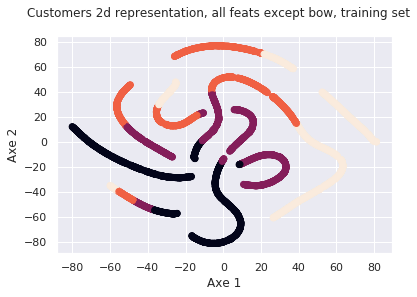

In [186]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, all feats except bow, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

Text(0, 0.5, 'Axe 2')

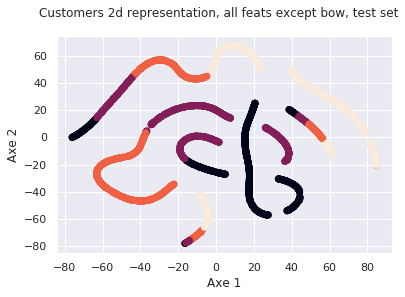

In [187]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, all feats except bow, test set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_test_transformed[:,0], X_test_transformed[:,1], c=df_score_cat_test)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [188]:
df_train.iloc[:, 0]

CustomerID
12346    0.877446
12347    0.572415
12348    0.474029
12349    0.707529
12350    0.330609
           ...   
18280    0.286691
18281    0.265155
18282    0.370964
18283    0.505393
18287    0.547572
Name: TotalPricePerMonth, Length: 4332, dtype: float64

In [189]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter3d(x = df_train.iloc[:,0], y = df_train.iloc[:,1], z = df_train.iloc[:, 2],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 3 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_allfeatsexceptbow_3d.html') 

'clusters_plot_clients_sne_allfeatsexceptbow_3d.html'

In [190]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter3d(x = df_train.iloc[:,0], y = df_train.iloc[:,1], z = df_train.iloc[:, 2],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_train['BoughtTopValueProduct']),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 3 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_allfeatsexceptbow_3d_color_topvalue.html') 

'clusters_plot_clients_sne_allfeatsexceptbow_3d_color_topvalue.html'

In [191]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter3d(x = df_train.iloc[:,0], y = df_train.iloc[:,1], z = df_train.iloc[:, 2],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_train['HasEverCancelled']),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 3 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_allfeatsexceptbow_3d_color_cancel.html') 

'clusters_plot_clients_sne_allfeatsexceptbow_3d_color_cancel.html'

# Model with all features and tSNE, BoW not apart from the rest, final representation with tSNE

In [207]:
importlib.reload(sys.modules['functions'])
from functions import *

In [208]:
df_train = df_train_ori
df_test = df_test_ori

In [209]:
preparation_pipeline_agg = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
])

In [210]:
df_train_agg = preparation_pipeline_agg.fit_transform(df_train)
df_test_agg = preparation_pipeline_agg.transform(df_test)

In [211]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized', 'TotalPricePerMonth', 'HasEverCancelled', 'BoughtTopValueProduct'], \
                                                        algorithm_to_use='TSNE', n_dim=2)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [212]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

No fit for TSNE


In [213]:
df_train

0         1
0     0.485951  0.160709
1     0.510417  0.456580
2     0.196422  0.415772
3     0.153005  0.472337
4     0.383346  0.296471
...        ...       ...
4327  0.363371  0.242751
4328  0.280691  0.282607
4329  0.479769  0.431286
4330  0.228942  0.604307
4331  0.701981  0.207829

[4332 rows x 2 columns]

In [214]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4332 entries, 0 to 4331
Data columns (total 2 columns):
0    4332 non-null float32
1    4332 non-null float32
dtypes: float32(2)
memory usage: 34.0 KB


In [215]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

In [216]:
X_transformed[:,1]

array([-53.34998  ,  19.46191  ,   8.562764 , ...,  14.1556835,
        43.87705  , -20.129354 ], dtype=float32)

Text(0, 0.5, 'Axe 2')

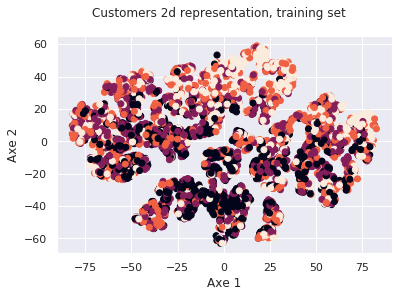

In [217]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [219]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train_agg['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_allfeats_final_tsne.html') 

'clusters_plot_clients_sne_allfeats_final_tsne.html'

# Model with all features and tSNE, final representation with tSNE 3D

In [220]:
importlib.reload(sys.modules['functions'])
from functions import *

In [221]:
df_train = df_train_ori
df_test = df_test_ori

In [222]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='TSNE', n_dim=3)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [223]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

No fit for TSNE


In [224]:
df_train

BoughtTopValueProduct  TotalPricePerMonth  HasEverCancelled  \
CustomerID                                                                
12346                         1.0            0.877446               1.0   
12347                         1.0            0.572415               0.0   
12348                         0.0            0.474029               0.0   
12349                         1.0            0.707529               0.0   
12350                         0.0            0.330609               0.0   
...                           ...                 ...               ...   
18280                         0.0            0.286691               0.0   
18281                         0.0            0.265155               0.0   
18282                         1.0            0.370964               1.0   
18283                         1.0            0.505393               0.0   
18287                         0.0            0.547572               0.0   

                   0         1         2  
CustomerID                                
12346       0.783543  0.628913  0.878636  
12347       0.727786  0.430184  0.704302  
12348       0.741093  0.560714  0.462285  
12349       0.648290  0.514565  0.458161  
12350       0.759664  0.587738  0.564628  
...              ...       ...       ...  
18280       0.747399  0.632402  0.684291  
18281       0.766730  0.647952  0.548147  
18282       0.716419  0.469840  0.643490  
18283       0.727965  0.528250  0.312737  
18287       0.902739  0.582266  0.476758  

[4332 rows x 6 columns]

In [225]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4332 entries, 12346 to 18287
Data columns (total 6 columns):
BoughtTopValueProduct    4332 non-null float64
TotalPricePerMonth       4332 non-null float64
HasEverCancelled         4332 non-null float64
0                        4332 non-null float64
1                        4332 non-null float64
2                        4332 non-null float64
dtypes: float64(6)
memory usage: 236.9+ KB


In [226]:
tsne = TSNE(n_components=3, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

In [227]:
X_transformed[:,1]

array([-7.9212937,  3.8351228, -2.1941373, ..., -7.4698176, 13.077991 ,
        4.946701 ], dtype=float32)

In [228]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter3d(x = X_transformed[:,0], y = X_transformed[:,1], z = X_transformed[:,2],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 3 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_allfeats_final_tsne_3d.html') 

'clusters_plot_clients_sne_allfeats_final_tsne_3d.html'

# Model with bow features + TotalPricePerMonth and NCA, final representation with tSNE

In [229]:
importlib.reload(sys.modules['functions'])
from functions import *

In [230]:
df_train = df_train_ori
df_test = df_test_ori

In [231]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='NCA', n_dim=200, labels_featurename='TotalPricePerMonth')),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [232]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

In [233]:
df_train

TotalPricePerMonth         0         1         2         3  \
CustomerID                                                               
12346                 0.877446  0.046983  0.544162  0.569010  0.578984   
12347                 0.572415  0.564794  0.425418  0.464870  0.538003   
12348                 0.474029  0.228890  0.465449  0.610888  0.517569   
12349                 0.707529  0.370229  0.349728  0.318196  0.424990   
12350                 0.330609  0.161225  0.438421  0.616754  0.630383   
...                        ...       ...       ...       ...       ...   
18280                 0.286691  0.086734  0.455771  0.574675  0.639160   
18281                 0.265155  0.089450  0.426684  0.607303  0.563269   
18282                 0.370964  0.115471  0.565695  0.358744  0.517463   
18283                 0.505393  0.618828  0.242817  0.458706  0.413288   
18287                 0.547572  0.344179  0.555663  0.642568  0.474694   

                   4         5         6         7         8         9  \
CustomerID                                                               
12346       0.604324  0.257648  0.551413  0.727304  0.363242  0.645852   
12347       0.447188  0.395250  0.310058  0.561618  0.280745  0.547363   
12348       0.533763  0.218619  0.570450  0.714599  0.416324  0.585073   
12349       0.513333  0.347236  0.358678  0.437545  0.547634  0.718109   
12350       0.507210  0.288784  0.560663  0.691022  0.286856  0.607965   
...              ...       ...       ...       ...       ...       ...   
18280       0.565182  0.351370  0.456992  0.774996  0.410526  0.520118   
18281       0.654445  0.255308  0.457569  0.774950  0.331244  0.622195   
18282       0.717624  0.262040  0.497292  0.579957  0.199569  0.644370   
18283       0.656783  0.577393  0.713355  0.536244  0.815704  0.359640   
18287       0.361413  0.319666  0.386782  0.544669  0.334965  0.538026   

                  10        11        12        13        14        15  \
CustomerID                                                               
12346       0.279837  0.671140  0.366633  0.580891  0.412079  0.556849   
12347       0.316086  0.533782  0.446466  0.543122  0.500716  0.182959   
12348       0.395716  0.639417  0.411343  0.558621  0.485376  0.558322   
12349       0.488459  0.388120  0.634334  0.425746  0.176352  0.201610   
12350       0.150699  0.679833  0.231700  0.623110  0.294364  0.551491   
...              ...       ...       ...       ...       ...       ...   
18280       0.253824  0.740606  0.275192  0.516310  0.285090  0.536899   
18281       0.341458  0.723869  0.373636  0.584424  0.359368  0.590812   
18282       0.223924  0.699772  0.279578  0.375773  0.515164  0.705660   
18283       0.795237  0.319325  0.494567  0.255317  0.490748  0.350031   
18287       0.470905  0.511760  0.380630  0.687802  0.437565  0.492471   

                  16        17        18        19        20        21  \
CustomerID                                                               
12346       0.357000  0.543681  0.455855  0.145499  0.548450  0.543905   
12347       0.714377  0.663975  0.345891  0.586333  0.570757  0.446034   
12348       0.562144  0.576066  0.389496  0.325900  0.539938  0.607046   
12349       0.577118  0.323702  0.271417  0.534389  0.628008  0.395005   
12350       0.452044  0.467461  0.438568  0.192470  0.610763  0.495533   
...              ...       ...       ...       ...       ...       ...   
18280       0.473054  0.566778  0.499832  0.164070  0.506497  0.480217   
18281       0.382831  0.551935  0.489146  0.151457  0.593638  0.557843   
18282       0.434731  0.524383  0.437548  0.265527  0.513010  0.421592   
18283       0.715747  0.546561  0.202554  0.399172  0.563712  0.666463   
18287       0.613265  0.546898  0.375746  0.411590  0.452797  0.537722   

                  22        23        24        25        26        27  \
CustomerID                                                               
12346       

In [234]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4332 entries, 12346 to 18287
Columns: 201 entries, TotalPricePerMonth to 199
dtypes: float64(201)
memory usage: 6.7+ MB


In [235]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

In [236]:
X_transformed[:,1]

array([  9.429349,  -8.441625, -26.02822 , ..., -20.09508 , -23.259813,
        13.288951], dtype=float32)

Text(0, 0.5, 'Axe 2')

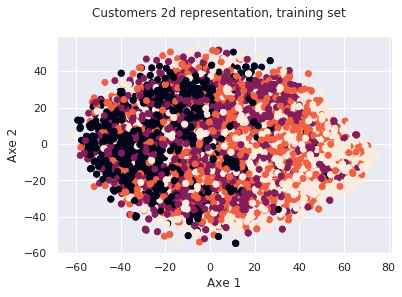

In [237]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [238]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_nca_bowandtotalpricepermonthfeats_final_tsne.html') 

'clusters_plot_clients_nca_bowandtotalpricepermonthfeats_final_tsne.html'

# Model with tSNE, then clustering algorithm KMeans

In [239]:
importlib.reload(sys.modules['functions'])
from functions import *

In [240]:
df_train = df_train_ori
df_test = df_test_ori

In [241]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='TSNE', n_dim=3)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [242]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

No fit for TSNE


In [243]:
df_train

BoughtTopValueProduct  TotalPricePerMonth  HasEverCancelled  \
CustomerID                                                                
12346                         1.0            0.877446               1.0   
12347                         1.0            0.572415               0.0   
12348                         0.0            0.474029               0.0   
12349                         1.0            0.707529               0.0   
12350                         0.0            0.330609               0.0   
...                           ...                 ...               ...   
18280                         0.0            0.286691               0.0   
18281                         0.0            0.265155               0.0   
18282                         1.0            0.370964               1.0   
18283                         1.0            0.505393               0.0   
18287                         0.0            0.547572               0.0   

                   0         1         2  
CustomerID                                
12346       0.783543  0.628913  0.878636  
12347       0.727786  0.430184  0.704302  
12348       0.741093  0.560714  0.462285  
12349       0.648290  0.514565  0.458161  
12350       0.759664  0.587738  0.564628  
...              ...       ...       ...  
18280       0.747399  0.632402  0.684291  
18281       0.766730  0.647952  0.548147  
18282       0.716419  0.469840  0.643490  
18283       0.727965  0.528250  0.312737  
18287       0.902739  0.582266  0.476758  

[4332 rows x 6 columns]

In [244]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df_train)
                for k in range(1, 50)]

In [245]:
labels_test_per_k = [model.predict(df_test) for model in kmeans_per_k[1:]]

In [246]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in kmeans_per_k[1:]]

In [247]:
silhouette_scores_test = [silhouette_score(df_test, labels_test) for labels_test in labels_test_per_k]

In [248]:
gini_mean_score_per_k_train = []

for model in kmeans_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    gini_sum = 0
    for unique_label in unique_labels:
        gini_sum += gini(df_train['TotalPricePerMonth'][model.labels_ == unique_label].to_numpy())
        
    gini_sum = gini_sum / len(unique_labels)
    
    gini_mean_score_per_k_train.append(gini_sum)

    
gini_mean_score_per_k_test = []

for labels_test in labels_test_per_k:
    unique_labels = np.unique(labels_test)
    
    gini_sum = 0
    for unique_label in unique_labels:
        gini_sum += gini(df_test['TotalPricePerMonth'][labels_test == unique_label].to_numpy())
        
    gini_sum = gini_sum / len(unique_labels)
    
    gini_mean_score_per_k_test.append(gini_sum)    
    

In [249]:
entropy_mean_score_per_k_train = []

for model in kmeans_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(df_train['TotalPricePerMonth'][model.labels_ == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_train.append(entropy_sum)

    
entropy_mean_score_per_k_test = []

for labels_test in labels_test_per_k:
    unique_labels = np.unique(labels_test)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(df_test['TotalPricePerMonth'][labels_test == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_test.append(entropy_sum)    
    

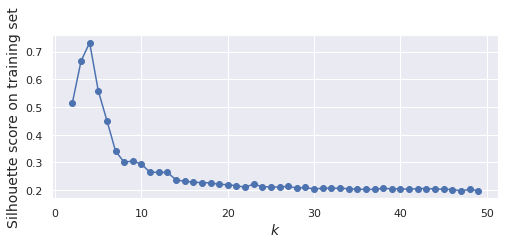

In [250]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

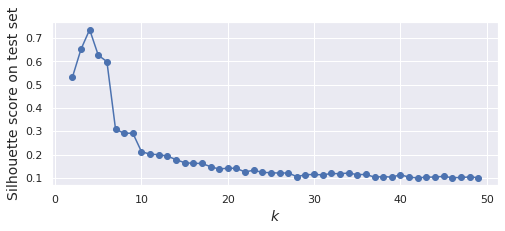

In [251]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [252]:
print('Gini before clustering :')
gini(df_train['TotalPricePerMonth'].to_numpy())

Gini before clustering :


0.14231138191824186

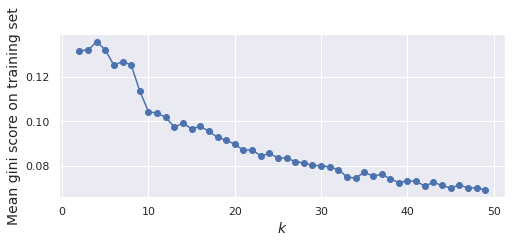

In [253]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), gini_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean gini score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

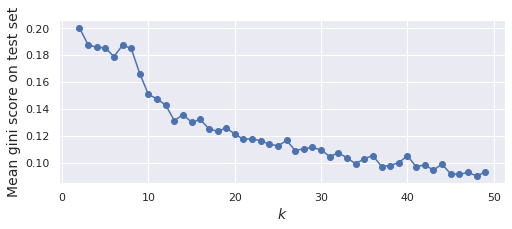

In [254]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), gini_mean_score_per_k_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean gini score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [255]:
print('Entropy before clustering :')
entropy(df_train['TotalPricePerMonth'])

Entropy before clustering :


8.340339103018163

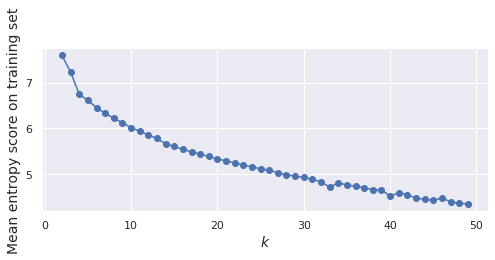

In [256]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

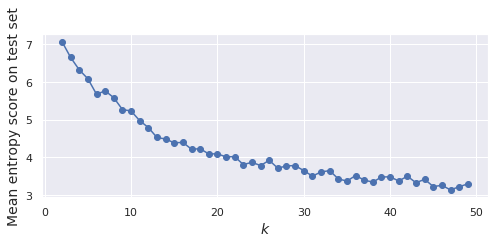

In [257]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

# Model with tSNE, then clustering algorithm Ward
No visualisation on test set because AgglomerativeClustering has no predict function, only fit_predict

In [258]:
clusterer_per_k = [AgglomerativeClustering(n_clusters=k, affinity='euclidean').fit(df_train) for k in range(1,50)]

In [259]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in clusterer_per_k[1:]]

In [260]:
gini_mean_score_per_k_train = []

for model in clusterer_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    gini_sum = 0
    for unique_label in unique_labels:
        gini_sum += gini(df_train['TotalPricePerMonth'][model.labels_ == unique_label].to_numpy())
        
    gini_sum = gini_sum / len(unique_labels)
    
    gini_mean_score_per_k_train.append(gini_sum)


    

In [261]:
entropy_mean_score_per_k_train = []

for model in clusterer_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(df_train['TotalPricePerMonth'][model.labels_ == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_train.append(entropy_sum)

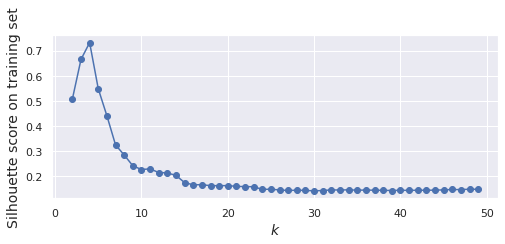

In [262]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

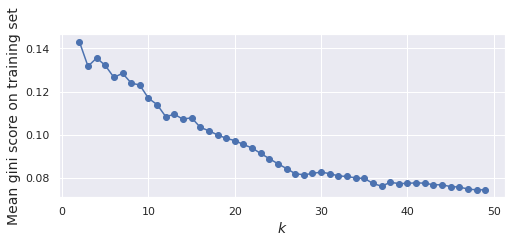

In [263]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), gini_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean gini score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [264]:
print('Entropy before clustering :')
entropy(df_train['TotalPricePerMonth'])

Entropy before clustering :


8.340339103018163

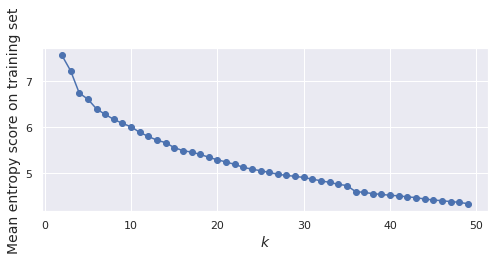

In [265]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

# Model with tSNE, then clustering algorithm Ward, distance threshold
No visualisation on test set because AgglomerativeClustering has no predict function, only fit_predict

In [266]:
np.unique(AgglomerativeClustering(distance_threshold=1, n_clusters=None, affinity='euclidean').fit(df_train).labels_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55])

In [270]:
clusterer_ward_per_thr = [AgglomerativeClustering(distance_threshold=thr, n_clusters=None, affinity='euclidean').fit(df_train) for thr in reversed(range(0,12))]

In [271]:
clusterer_ward_per_thr

[AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                         connectivity=None, distance_threshold=11,
                         linkage='ward', memory=None, n_clusters=None,
                         pooling_func='deprecated'),
 AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                         connectivity=None, distance_threshold=10,
                         linkage='ward', memory=None, n_clusters=None,
                         pooling_func='deprecated'),
 AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                         connectivity=None, distance_threshold=9, linkage='ward',
                         memory=None, n_clusters=None,
                         pooling_func='deprecated'),
 AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                         connectivity=None, distance_threshold=8, linkage='ward',
                         memory=None, n_clusters=None,

In [272]:
entropy_mean_score_per_k_train = []

for model in clusterer_ward_per_thr[1:]:
    unique_labels = np.unique(model.labels_)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(df_train['TotalPricePerMonth'][model.labels_ == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_train.append(entropy_sum)

/home/francois/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2614: RuntimeWarning:

invalid value encountered in true_divide



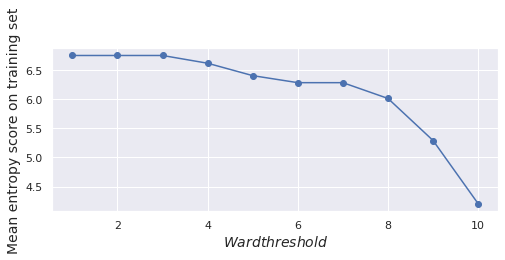

In [273]:
plt.figure(figsize=(8, 3))
plt.plot(range(1,12), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$Ward threshold$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

# => Around 50 clusters => entropy of TotalPrice around 4.5

# Prepation model with LLE reduce to 200, then clustering algorithm Ward

In [274]:
importlib.reload(sys.modules['functions'])
from functions import *

In [275]:
df_train = df_train_ori
df_test = df_test_ori


In [276]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='LLE', n_dim=200, n_neighbors=10)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [277]:
df_train = preparation_pipeline.fit_transform(df_train)

In [278]:
df_test = preparation_pipeline.transform(df_test)

In [279]:
clusterer_per_k = [AgglomerativeClustering(n_clusters=k, affinity='euclidean').fit(df_train) for k in range(1,50)]

In [281]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in clusterer_per_k[1:]]

In [282]:
entropy_mean_score_per_k_train = []

for model in clusterer_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(df_train['TotalPricePerMonth'][model.labels_ == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_train.append(entropy_sum)

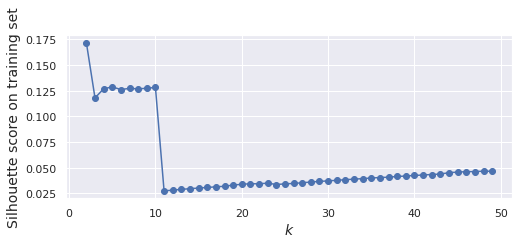

In [283]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [284]:
print('Entropy before clustering :')
entropy(df_train['TotalPricePerMonth'])

Entropy before clustering :


8.340339103018163

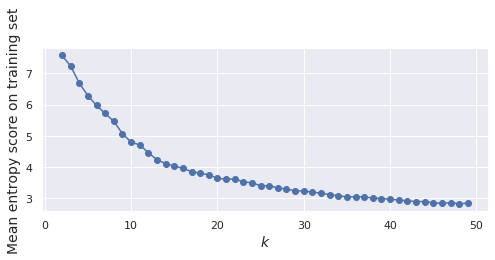

In [285]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

# Prepation model with LLE reduce to 3, then clustering algorithm Ward

In [286]:
importlib.reload(sys.modules['functions'])
from functions import *

In [287]:
df_train = df_train_ori
df_test = df_test_ori


In [288]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='LLE', n_dim=3, n_neighbors=10)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [289]:
df_train = preparation_pipeline.fit_transform(df_train)

In [290]:
df_test = preparation_pipeline.transform(df_test)

In [291]:
clusterer_per_k = [AgglomerativeClustering(n_clusters=k, affinity='euclidean').fit(df_train) for k in range(1,50)]

In [292]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in clusterer_per_k[1:]]

In [293]:
entropy_mean_score_per_k_train = []

for model in clusterer_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(df_train['TotalPricePerMonth'][model.labels_ == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_train.append(entropy_sum)

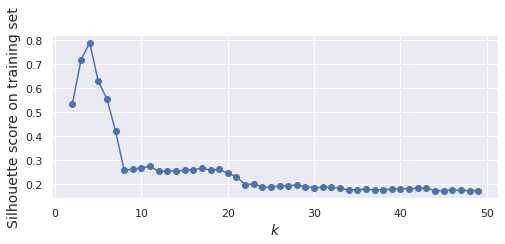

In [294]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [295]:
print('Entropy before clustering :')
entropy(df_train['TotalPricePerMonth'])

Entropy before clustering :


8.340339103018163

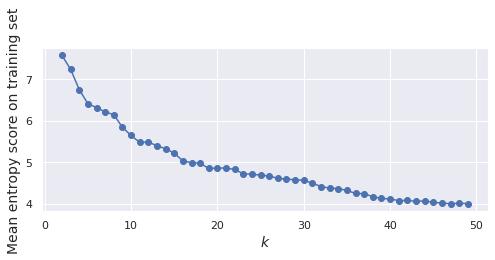

In [296]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

# Preparation model BoW feats only, then LLE reduce to 200, then KMeans and Ward

In [297]:
importlib.reload(sys.modules['functions'])
from functions import *

In [298]:
df_train = df_train_ori
df_test = df_test_ori


In [299]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    #('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    #('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='LLE', n_dim=200, n_neighbors=10)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [300]:
df_train = preparation_pipeline.fit_transform(df_train)

In [301]:
df_test = preparation_pipeline.transform(df_test)

In [302]:
df_train

0         1         2         3         4         5         6  \
0     0.070266  0.866875  0.713318  0.460115  0.863221  0.431550  0.536350   
1     0.156365  0.579371  0.478420  0.707986  0.661040  0.454051  0.570945   
2     0.161355  0.632033  0.498368  0.791762  0.631296  0.565009  0.560440   
3     0.116654  0.558755  0.487852  0.703197  0.678159  0.379200  0.617604   
4     0.215421  0.637681  0.421959  0.846181  0.705704  0.307077  0.630998   
...        ...       ...       ...       ...       ...       ...       ...   
4327  0.827676  0.853398  0.369199  0.697179  0.590485  0.333221  0.212182   
4328  0.071993  0.693057  0.489952  0.853455  0.603962  0.389066  0.469962   
4329  0.229847  0.208244  0.769806  0.763834  0.641421  0.621625  0.683999   
4330  0.140146  0.617572  0.502182  0.783047  0.671382  0.403092  0.547635   
4331  0.139803  0.638857  0.481960  0.675371  0.670384  0.344563  0.528933   

             7         8         9        10        11        12        13  \
0     0.812617  0.342428  0.923869  0.577394  0.179362  0.770566  0.314765   
1     0.788447  0.472721  0.720127  0.574795  0.197042  0.730587  0.348650   
2     0.793859  0.469092  0.714410  0.556187  0.192830  0.746765  0.314391   
3     0.804108  0.430118  0.731471  0.575446  0.194461  0.751565  0.295617   
4     0.797553  0.410153  0.736959  0.636951  0.182717  0.749683  0.301199   
...        ...       ...       ...       ...       ...       ...       ...   
4327  0.776894  0.584255  0.714071  0.645857  0.192477  0.751183  0.378630   
4328  0.797395  0.474349  0.717087  0.598267  0.188626  0.754960  0.327969   
4329  0.794013  0.468698  0.708608  0.547027  0.213978  0.774716  0.330156   
4330  0.789021  0.475740  0.727101  0.580177  0.202781  0.731360  0.320507   
4331  0.813792  0.567276  0.725081  0.522198  0.230844  0.718558  0.327512   

            14        15        16        17        18        19        20  \
0     0.100587  0.430214  0.017869  0.295874  0.826286  0.371261  0.973674   
1     0.093863  0.446614  0.014503  0.313362  0.818329  0.353243  0.949206   
2     0.091993  0.445639  0.014178  0.382740  0.844512  0.328722  0.942916   
3     0.097561  0.421157  0.017349  0.389736  0.799655  0.349649  0.908984   
4     0.088279  0.389272  0.014508  0.321823  0.848739  0.381229  0.942832   
...        ...       ...       ...       ...       ...       ...       ...   
4327  0.068136  0.462686  0.015401  0.310551  0.940744  0.311877  0.970922   
4328  0.085962  0.444178  0.013358  0.268448  0.894573  0.285826  0.955623   
4329  0.105268  0.431842  0.007908  0.282008  0.749205  0.351332  0.963414   
4330  0.095285  0.430108  0.015518  0.345939  0.815351  0.346536  0.943248   
4331  0.094627  0.441559  0.017846  0.363104  0.893536  0.339122  0.947182   

            21        22        23        24        25        26        27  \
0     0.250333  0.650744  0.642150  0.814737  0.613729  0.580238  0.393253   
1     0.346848  0.613328  0.670994  0.743037  0.594862  0.521146  0.529247   
2     0.355365  0.550963  0.740861  0.754683  0.557007  0.312051  0.436997   
3     0.358930  0.563987  0.684251  0.716123  0.560773  0.520379  0.504374   
4     0.515936  0.647522  0.739552  0.699624  0.401874  0.515131  0.489046   
...        ...       ...       ...       ...       ...       ...       ...   
4327  0.380201  0.729425  0.821431  0.740277  0.454762  0.587593  0.579322   
4328  0.351814  0.657754  0.477676  0.764978  0.425704  0.528625  0.547920   
4329  0.350360  0.689863  0.683038  0.753399  0.544260  0.709908  0.567566   
4330  0.343257  0.585348  0.680851  0.738126  0.559893  0.494416  0.510511   
4331  0.377296  0.599356  0.689075  0.771135  0.487873  0.514710  0.509210   

            28        29        30        31        32        33        34  \
0     0.927041  0.613220  0.136785  0.615248  0.263532  0.900667  0.757752   
1     0.598224  0.316217  0.497287  0.470563  0.444874  0.377664  0.742559   
2     0.599991  0.282848  0.615

In [303]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df_train)
                for k in range(1, 50)]

In [304]:
labels_test_per_k = [model.predict(df_test) for model in kmeans_per_k[1:]]

In [305]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in kmeans_per_k[1:]]

In [306]:
silhouette_scores_test = [silhouette_score(df_test, labels_test) for labels_test in labels_test_per_k]

In [307]:
entropy_mean_score_per_k_train = []

for model in kmeans_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(series_total_price_per_month_train[model.labels_ == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_train.append(entropy_sum)

    
entropy_mean_score_per_k_test = []

for labels_test in labels_test_per_k:
    unique_labels = np.unique(labels_test)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(series_total_price_per_month_test[labels_test == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_test.append(entropy_sum)    
    

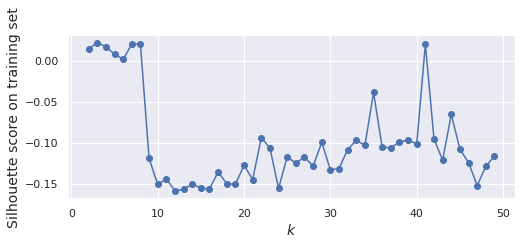

In [308]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

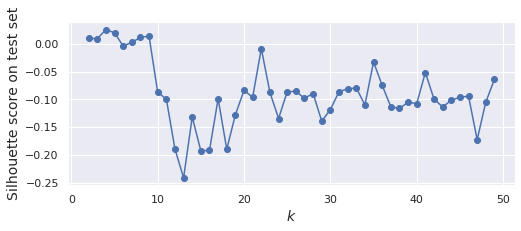

In [309]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [310]:
print('Entropy before clustering :')
entropy(series_total_price_per_month_train)

Entropy before clustering :


8.340339103018163

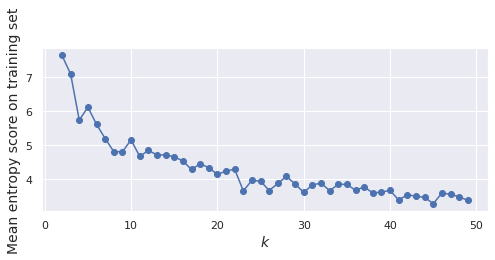

In [311]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

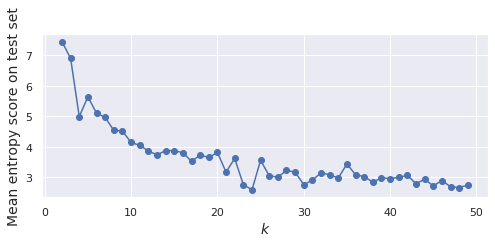

In [312]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

## 2nd clustering : Ward

In [313]:
clusterer_per_k = [AgglomerativeClustering(n_clusters=k, affinity='euclidean').fit(df_train) for k in range(1,50)]

In [314]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in clusterer_per_k[1:]]

In [315]:
entropy_mean_score_per_k_train = []

for model in clusterer_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(series_total_price_per_month_train[model.labels_ == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_train.append(entropy_sum)

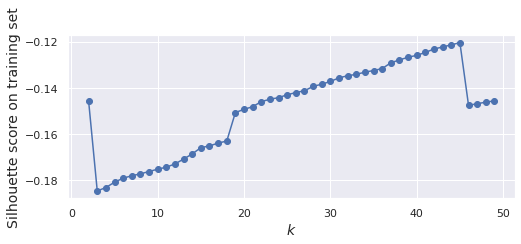

In [316]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [317]:
print('Entropy before clustering :')
entropy(series_total_price_per_month_train)

Entropy before clustering :


8.340339103018163

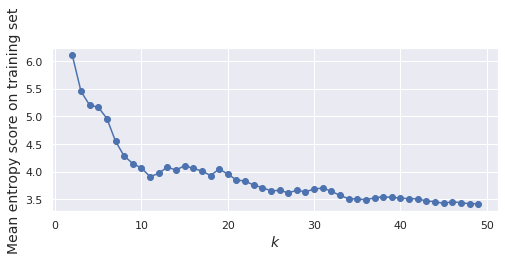

In [318]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

# Preparation model BoW feats only, then LLE reduce to 3 then KMeans and Ward

In [319]:
importlib.reload(sys.modules['functions'])
from functions import *

In [320]:
df_train = df_train_ori
df_test = df_test_ori


In [321]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products)),
    #('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    #('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth'])),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='LLE', n_dim=3, n_neighbors=10)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [322]:
df_train = preparation_pipeline.fit_transform(df_train)

In [323]:
df_test = preparation_pipeline.transform(df_test)

In [324]:
df_train

0         1         2
0     0.929734  0.133125  0.286682
1     0.843635  0.420629  0.521580
2     0.838645  0.367967  0.501632
3     0.883346  0.441245  0.512148
4     0.784579  0.362319  0.578041
...        ...       ...       ...
4327  0.172324  0.146602  0.630801
4328  0.928007  0.306943  0.510048
4329  0.770153  0.791756  0.230194
4330  0.859854  0.382429  0.497818
4331  0.860197  0.361143  0.518040

[4332 rows x 3 columns]

In [325]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df_train)
                for k in range(1, 50)]

In [326]:
labels_test_per_k = [model.predict(df_test) for model in kmeans_per_k[1:]]

In [327]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in kmeans_per_k[1:]]

In [328]:
silhouette_scores_test = [silhouette_score(df_test, labels_test) for labels_test in labels_test_per_k]

In [329]:
entropy_mean_score_per_k_train = []

for model in kmeans_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(series_total_price_per_month_train[model.labels_ == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_train.append(entropy_sum)

    
entropy_mean_score_per_k_test = []

for labels_test in labels_test_per_k:
    unique_labels = np.unique(labels_test)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(series_total_price_per_month_test[labels_test == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_test.append(entropy_sum)    
    

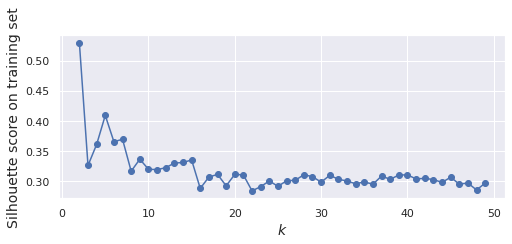

In [330]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

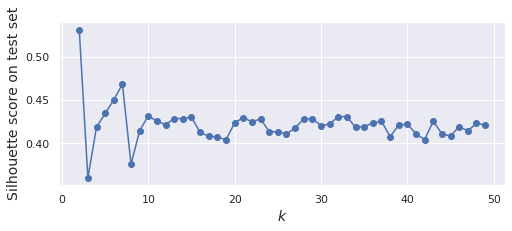

In [331]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [332]:
print('Entropy before clustering :')
entropy(series_total_price_per_month_train)

Entropy before clustering :


8.340339103018163

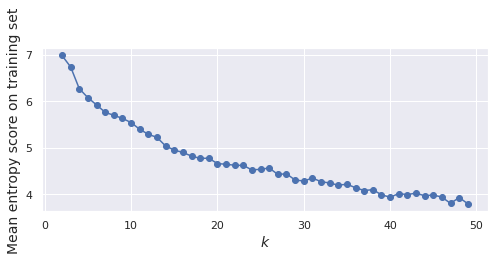

In [333]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

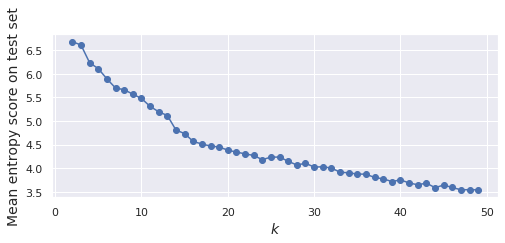

In [334]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

## 2nd clustering : ward

In [335]:
clusterer_per_k = [AgglomerativeClustering(n_clusters=k, affinity='euclidean').fit(df_train) for k in range(1,50)]

In [336]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in clusterer_per_k[1:]]

In [337]:
entropy_mean_score_per_k_train = []

for model in clusterer_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(series_total_price_per_month_train[model.labels_ == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_train.append(entropy_sum)

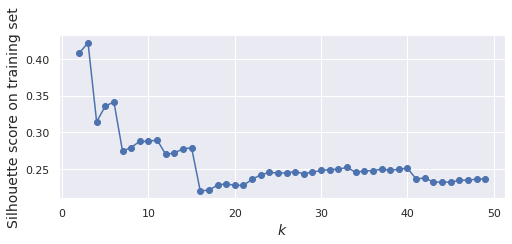

In [338]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [339]:
print('Entropy before clustering :')
entropy(series_total_price_per_month_train)

Entropy before clustering :


8.340339103018163

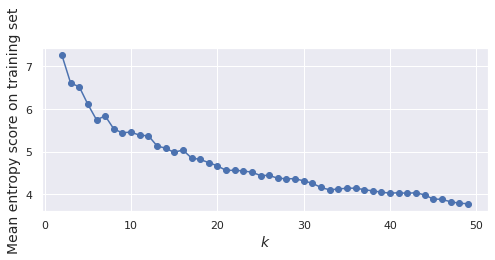

In [340]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

# Plot representation

In [342]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter3d(x = df_train.loc[:,0], y = df_train.loc[:,1], z = df_train.loc[:,2],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = series_total_price_per_month_train,
                    )


layout = go.Layout(title = 'Représentation des clients en 3 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_lle_bowfeats_3d.html') 

'clusters_plot_clients_lle_bowfeats_3d.html'

# Model with 'TotalPricePerMonth', 'TotalQuantityPerMonth', 'Recency', 'HasEverCancelled', 'BoughtTopValueProduct', 'DescriptionNormalized', and TSNE, with KMeans (INTERESTING)

In [343]:
importlib.reload(sys.modules['functions'])
from functions import *

In [344]:
df_train = df_train_ori
df_test = df_test_ori

In [345]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('features_selector', FeaturesSelector(features_toselect=['TotalPricePerMonth', 'TotalQuantityPerMonth', 'Recency', 'HasEverCancelled', 'BoughtTopValueProduct', 'DescriptionNormalized'])),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth', 'TotalQuantityPerMonth', 'Recency'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth', 'TotalQuantityPerMonth', 'Recency'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='TSNE', n_dim=3)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [346]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

No fit for TSNE


In [347]:
rfm_scores_train = get_rfm_scores(df_train)

In [348]:
unique_rfm_scores = np.sort(rfm_scores_train.unique())

In [349]:
rfm_dict_colors = {}
cnt = 0

for unique_rfm_score in unique_rfm_scores:
    rfm_dict_colors[unique_rfm_score] = cnt
    cnt += 1
    

In [350]:
rfm_scores_train_colors = rfm_scores_train.apply(lambda x : rfm_dict_colors[x])

In [351]:
rfm_scores_train_colors

CustomerID
12346    2
12347    3
12348    4
12349    0
12350    8
        ..
18280    8
18281    7
18282    7
18283    5
18287    1
Name: RFMScore, Length: 4332, dtype: int64

In [352]:
rfm_scores_train

CustomerID
12346     5
12347     6
12348     7
12349     3
12350    11
         ..
18280    11
18281    10
18282    10
18283     8
18287     4
Name: RFMScore, Length: 4332, dtype: int64

In [353]:
df_train

Recency  TotalQuantityPerMonth  HasEverCancelled  \
CustomerID                                                      
12346       0.932971               0.915344               1.0   
12347       0.991722               0.536506               0.0   
12348       0.979372               0.543549               0.0   
12349       0.000000               0.657517               0.0   
12350       0.909797               0.299590               0.0   
...              ...                    ...               ...   
18280       0.856316               0.171885               0.0   
18281       0.655912               0.233494               0.0   
18282       0.498845               0.319077               1.0   
18283       0.950265               0.484163               0.0   
18287       0.706200               0.553078               0.0   

            BoughtTopValueProduct  TotalPricePerMonth         0         1  \
CustomerID                                                                  
12346                         1.0            0.877446  0.783543  0.628913   
12347                         1.0            0.572415  0.727786  0.430184   
12348                         0.0            0.474029  0.741093  0.560714   
12349                         1.0            0.707529  0.648290  0.514565   
12350                         0.0            0.330609  0.759664  0.587738   
...                           ...                 ...       ...       ...   
18280                         0.0            0.286691  0.747399  0.632402   
18281                         0.0            0.265155  0.766730  0.647952   
18282                         1.0            0.370964  0.716419  0.469840   
18283                         1.0            0.505393  0.727965  0.528250   
18287                         0.0            0.547572  0.902739  0.582266   

                   2  
CustomerID            
12346       0.878636  
12347       0.704302  
12348       0.462285  
12349       0.458161  
12350       0.564628  
...              ...  
18280       0.684291  
18281       0.548147  
18282       0.643490  
18283       0.312737  
18287       0.476758  

[4332 rows x 8 columns]

In [354]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4332 entries, 12346 to 18287
Data columns (total 8 columns):
Recency                  4332 non-null float64
TotalQuantityPerMonth    4332 non-null float64
HasEverCancelled         4332 non-null float64
BoughtTopValueProduct    4332 non-null float64
TotalPricePerMonth       4332 non-null float64
0                        4332 non-null float64
1                        4332 non-null float64
2                        4332 non-null float64
dtypes: float64(8)
memory usage: 304.6+ KB


In [355]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

In [356]:
X_transformed[:,1]

array([  2.6228526,  29.104588 , -65.24375  , ..., -29.51727  ,
        36.627422 , -54.926    ], dtype=float32)

Text(0, 0.5, 'Axe 2')

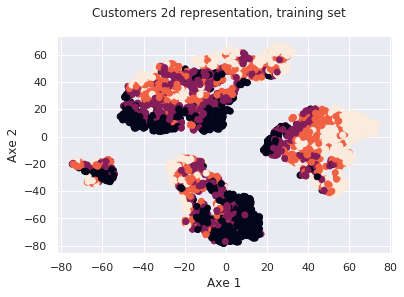

In [357]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [358]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_allfeatswithRFM_final_tsne.html') 

'clusters_plot_clients_sne_allfeatswithRFM_final_tsne.html'

Text(0, 0.5, 'Axe 2')

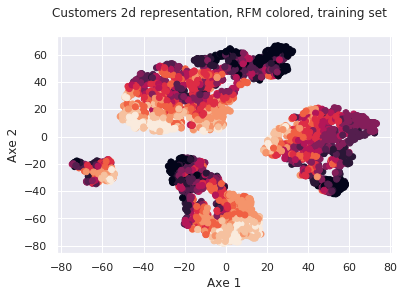

In [359]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, RFM colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=rfm_scores_train_colors)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

In [360]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=rfm_scores_train_colors),
                    text = rfm_scores_train,
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_allfeatswithRFM_color_RFM_final_tsne.html') 

'clusters_plot_clients_sne_allfeatswithRFM_color_RFM_final_tsne.html'

In [361]:
## Add bow coloration

Text(0, 0.5, 'Axe 2')

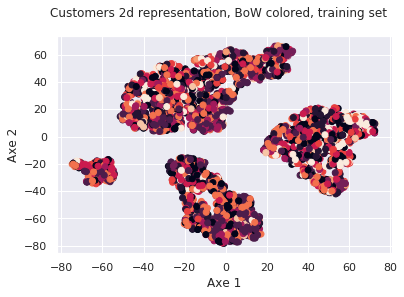

In [362]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, BoW colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=bow_labels_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

## RFM and bow (without BoughtTopValueProduct and HasEverCancelled)

In [363]:
df_train[['TotalPricePerMonth', 'Recency', 'TotalQuantityPerMonth', 0, 1, 2]]

TotalPricePerMonth   Recency  TotalQuantityPerMonth         0  \
CustomerID                                                                  
12346                 0.877446  0.932971               0.915344  0.783543   
12347                 0.572415  0.991722               0.536506  0.727786   
12348                 0.474029  0.979372               0.543549  0.741093   
12349                 0.707529  0.000000               0.657517  0.648290   
12350                 0.330609  0.909797               0.299590  0.759664   
...                        ...       ...                    ...       ...   
18280                 0.286691  0.856316               0.171885  0.747399   
18281                 0.265155  0.655912               0.233494  0.766730   
18282                 0.370964  0.498845               0.319077  0.716419   
18283                 0.505393  0.950265               0.484163  0.727965   
18287                 0.547572  0.706200               0.553078  0.902739   

                   1         2  
CustomerID                      
12346       0.628913  0.878636  
12347       0.430184  0.704302  
12348       0.560714  0.462285  
12349       0.514565  0.458161  
12350       0.587738  0.564628  
...              ...       ...  
18280       0.632402  0.684291  
18281       0.647952  0.548147  
18282       0.469840  0.643490  
18283       0.528250  0.312737  
18287       0.582266  0.476758  

[4332 rows x 6 columns]

In [364]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train[['TotalPricePerMonth', 'Recency', 'TotalQuantityPerMonth', 0, 1, 2]])
X_test_transformed = tsne.fit_transform(df_test[['TotalPricePerMonth', 'Recency', 'TotalQuantityPerMonth', 0, 1, 2]])

In [365]:
X_transformed[:,1]

array([ 63.194237,  -6.357803,  37.56004 , ..., -11.643651,  45.900055,
        36.52802 ], dtype=float32)

Text(0, 0.5, 'Axe 2')

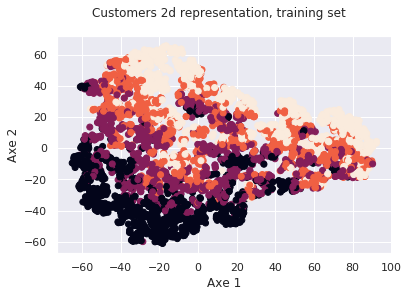

In [366]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [367]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_bowandRfm_final_tsne.html') 

'clusters_plot_clients_sne_bowandRfm_final_tsne.html'

Text(0, 0.5, 'Axe 2')

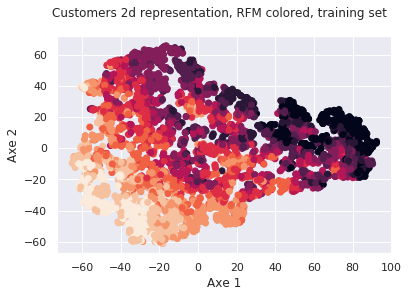

In [368]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, RFM colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=rfm_scores_train_colors)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

## RFM and bow (without HasEverCancelled, but WITH BoughtTopValueProduct)

In [369]:
df_train[['TotalPricePerMonth', 'Recency', 'TotalQuantityPerMonth', 'BoughtTopValueProduct', 0, 1, 2]]

TotalPricePerMonth   Recency  TotalQuantityPerMonth  \
CustomerID                                                        
12346                 0.877446  0.932971               0.915344   
12347                 0.572415  0.991722               0.536506   
12348                 0.474029  0.979372               0.543549   
12349                 0.707529  0.000000               0.657517   
12350                 0.330609  0.909797               0.299590   
...                        ...       ...                    ...   
18280                 0.286691  0.856316               0.171885   
18281                 0.265155  0.655912               0.233494   
18282                 0.370964  0.498845               0.319077   
18283                 0.505393  0.950265               0.484163   
18287                 0.547572  0.706200               0.553078   

            BoughtTopValueProduct         0         1         2  
CustomerID                                                       
12346                         1.0  0.783543  0.628913  0.878636  
12347                         1.0  0.727786  0.430184  0.704302  
12348                         0.0  0.741093  0.560714  0.462285  
12349                         1.0  0.648290  0.514565  0.458161  
12350                         0.0  0.759664  0.587738  0.564628  
...                           ...       ...       ...       ...  
18280                         0.0  0.747399  0.632402  0.684291  
18281                         0.0  0.766730  0.647952  0.548147  
18282                         1.0  0.716419  0.469840  0.643490  
18283                         1.0  0.727965  0.528250  0.312737  
18287                         0.0  0.902739  0.582266  0.476758  

[4332 rows x 7 columns]

In [370]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train[['TotalPricePerMonth', 'Recency', 'TotalQuantityPerMonth', 'BoughtTopValueProduct', 0, 1, 2]])
X_test_transformed = tsne.fit_transform(df_test[['TotalPricePerMonth', 'Recency', 'TotalQuantityPerMonth', 'BoughtTopValueProduct', 0, 1, 2]])

In [371]:
X_transformed[:,1]

array([ 68.24322 ,  30.58995 , -60.437893, ...,  11.125152,  65.72598 ,
       -63.495106], dtype=float32)

Text(0, 0.5, 'Axe 2')

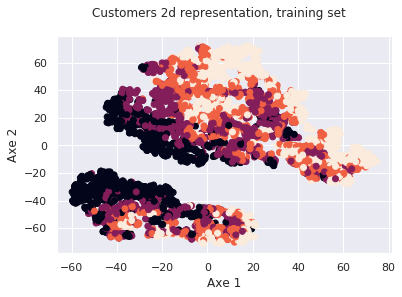

In [372]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [373]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_bowandRfmandboughttopvalue_final_tsne.html') 

'clusters_plot_clients_sne_bowandRfmandboughttopvalue_final_tsne.html'

Text(0, 0.5, 'Axe 2')

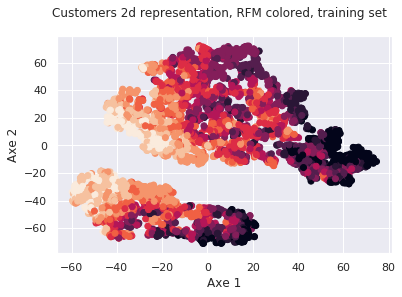

In [374]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, RFM colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=rfm_scores_train_colors)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

## RFM only (without bow, BoughtTopValueProduct and HasEverCancelled)

In [375]:
df_train[['TotalPricePerMonth', 'Recency', 'TotalQuantityPerMonth']]

TotalPricePerMonth   Recency  TotalQuantityPerMonth
CustomerID                                                     
12346                 0.877446  0.932971               0.915344
12347                 0.572415  0.991722               0.536506
12348                 0.474029  0.979372               0.543549
12349                 0.707529  0.000000               0.657517
12350                 0.330609  0.909797               0.299590
...                        ...       ...                    ...
18280                 0.286691  0.856316               0.171885
18281                 0.265155  0.655912               0.233494
18282                 0.370964  0.498845               0.319077
18283                 0.505393  0.950265               0.484163
18287                 0.547572  0.706200               0.553078

[4332 rows x 3 columns]

In [376]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train[['TotalPricePerMonth', 'Recency', 'TotalQuantityPerMonth']])
X_test_transformed = tsne.fit_transform(df_test[['TotalPricePerMonth', 'Recency', 'TotalQuantityPerMonth']])

In [377]:
X_transformed[:,1]

array([ 64.5019  ,  62.6094  ,  49.83136 , ..., -35.8076  ,  35.60723 ,
         4.498776], dtype=float32)

Text(0, 0.5, 'Axe 2')

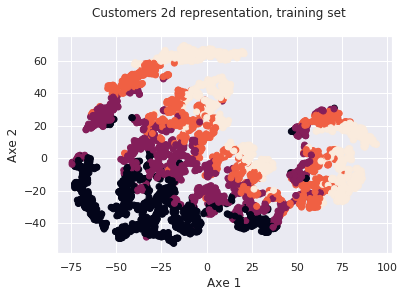

In [378]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [379]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_rfmOnly_final_tsne.html') 

'clusters_plot_clients_sne_rfmOnly_final_tsne.html'

Text(0, 0.5, 'Axe 2')

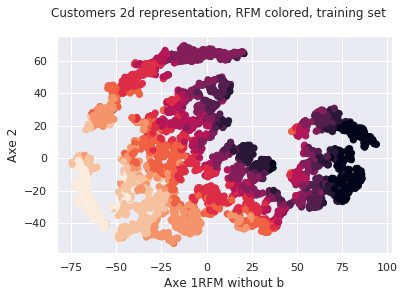

In [380]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, RFM colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=rfm_scores_train_colors)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1RFM without b')
plt.ylabel("Axe 2")

#plt.yscale('log')

# RFM with 'TotalPricePerMonth', 'Recency', 'TotalQuantityPerMonth', 'BoughtTopValueProduct', 'HasEverCancelled' (GOOD)

In [381]:
df_train[['TotalPricePerMonth', 'Recency', 'TotalQuantityPerMonth', 'BoughtTopValueProduct', 'HasEverCancelled']]

TotalPricePerMonth   Recency  TotalQuantityPerMonth  \
CustomerID                                                        
12346                 0.877446  0.932971               0.915344   
12347                 0.572415  0.991722               0.536506   
12348                 0.474029  0.979372               0.543549   
12349                 0.707529  0.000000               0.657517   
12350                 0.330609  0.909797               0.299590   
...                        ...       ...                    ...   
18280                 0.286691  0.856316               0.171885   
18281                 0.265155  0.655912               0.233494   
18282                 0.370964  0.498845               0.319077   
18283                 0.505393  0.950265               0.484163   
18287                 0.547572  0.706200               0.553078   

            BoughtTopValueProduct  HasEverCancelled  
CustomerID                                           
12346                         1.0               1.0  
12347                         1.0               0.0  
12348                         0.0               0.0  
12349                         1.0               0.0  
12350                         0.0               0.0  
...                           ...               ...  
18280                         0.0               0.0  
18281                         0.0               0.0  
18282                         1.0               1.0  
18283                         1.0               0.0  
18287                         0.0               0.0  

[4332 rows x 5 columns]

In [382]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train[['TotalPricePerMonth', 'Recency', 'TotalQuantityPerMonth', 'BoughtTopValueProduct', 'HasEverCancelled']])
X_test_transformed = tsne.fit_transform(df_test[['TotalPricePerMonth', 'Recency', 'TotalQuantityPerMonth', 'BoughtTopValueProduct', 'HasEverCancelled']])

In [383]:
X_transformed[:,1]

array([ 22.810349,  36.53609 , -69.994576, ...,  46.596912,  28.40872 ,
       -63.634438], dtype=float32)

Text(0, 0.5, 'Axe 2')

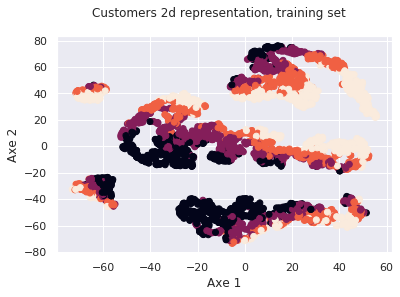

In [384]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")
#plt.yscale('log')

In [385]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=df_score_cat_train),
                    text = df_train['TotalPricePerMonth'],
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_rfmBoughtTopValueProductsHasEverCancelled_withoutBow_final_tsne.html') 

'clusters_plot_clients_sne_rfmBoughtTopValueProductsHasEverCancelled_withoutBow_final_tsne.html'

Text(0, 0.5, 'Axe 2')

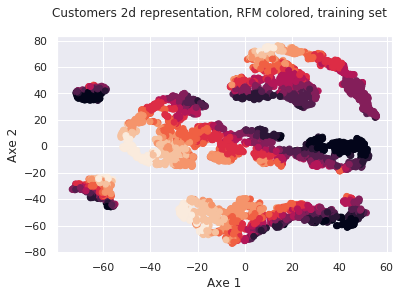

In [386]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, RFM colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=rfm_scores_train_colors)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

# Model with all bow features and RFM score (not individual feats), and TSNE, with KMeans

In [387]:
importlib.reload(sys.modules['functions'])
from functions import *

In [388]:
df_train = df_train_ori
df_test = df_test_ori

In [389]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'RfmScore'])),
    #('scaler', LogScalerMultiple(features_toscale=['RfmScore'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['RfmScore'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='TSNE', n_dim=3)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [390]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

No fit for TSNE


In [391]:
rfm_scores_train = df_train['RfmScore']

In [392]:
unique_rfm_scores = np.sort(rfm_scores_train.unique())

In [393]:
rfm_dict_colors = {}
cnt = 0

for unique_rfm_score in unique_rfm_scores:
    rfm_dict_colors[unique_rfm_score] = cnt
    cnt += 1
    

In [394]:
rfm_scores_train_colors = rfm_scores_train.apply(lambda x : rfm_dict_colors[x])

In [395]:
rfm_scores_train_colors

CustomerID
12346    2
12347    3
12348    4
12349    0
12350    8
        ..
18280    8
18281    7
18282    7
18283    5
18287    1
Name: RfmScore, Length: 4332, dtype: int64

In [396]:
rfm_scores_train

CustomerID
12346    0.222222
12347    0.333333
12348    0.444444
12349    0.000000
12350    0.888889
           ...   
18280    0.888889
18281    0.777778
18282    0.777778
18283    0.555556
18287    0.111111
Name: RfmScore, Length: 4332, dtype: float64

In [397]:
df_train

RfmScore         0         1         2
CustomerID                                        
12346       0.222222  0.783543  0.628913  0.878636
12347       0.333333  0.727786  0.430184  0.704302
12348       0.444444  0.741093  0.560714  0.462285
12349       0.000000  0.648290  0.514565  0.458161
12350       0.888889  0.759664  0.587738  0.564628
...              ...       ...       ...       ...
18280       0.888889  0.747399  0.632402  0.684291
18281       0.777778  0.766730  0.647952  0.548147
18282       0.777778  0.716419  0.469840  0.643490
18283       0.555556  0.727965  0.528250  0.312737
18287       0.111111  0.902739  0.582266  0.476758

[4332 rows x 4 columns]

In [398]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4332 entries, 12346 to 18287
Data columns (total 4 columns):
RfmScore    4332 non-null float64
0           4332 non-null float64
1           4332 non-null float64
2           4332 non-null float64
dtypes: float64(4)
memory usage: 329.2+ KB


In [399]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

In [400]:
X_transformed[:,1]

array([ 13.682132 ,  47.244    ,  50.210014 , ..., -62.672047 ,
         7.1409106,   9.08382  ], dtype=float32)

Text(0, 0.5, 'Axe 2')

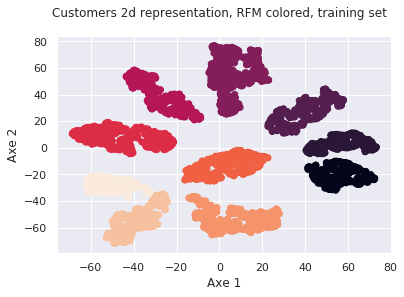

In [401]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, RFM colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=rfm_scores_train_colors)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

In [402]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=rfm_scores_train_colors),
                    text = rfm_scores_train,
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_bowwithRFMscore_color_RFM_final_tsne.html') 

'clusters_plot_clients_sne_bowwithRFMscore_color_RFM_final_tsne.html'

# Model with 'DescriptionNormalized', 'BoughtTopValueProduct', 'HasEverCancelled', 'RfmScore' (concat), and TSNE (BEST)

In [403]:
importlib.reload(sys.modules['functions'])
from functions import *

In [404]:
df_train = df_train_ori
df_test = df_test_ori

In [405]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'BoughtTopValueProduct', 'HasEverCancelled', 'RfmScore'])),
    #('scaler', LogScalerMultiple(features_toscale=['RfmScore'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['RfmScore'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='TSNE', n_dim=3)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [406]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

No fit for TSNE


In [407]:
rfm_scores_train = df_train['RfmScore']

In [408]:
unique_rfm_scores = np.sort(rfm_scores_train.unique())

In [409]:
rfm_dict_colors = {}
cnt = 0

for unique_rfm_score in unique_rfm_scores:
    rfm_dict_colors[unique_rfm_score] = cnt
    cnt += 1
    

In [410]:
rfm_scores_train_colors = rfm_scores_train.apply(lambda x : rfm_dict_colors[x])

In [411]:
rfm_scores_train_colors

CustomerID
12346    2
12347    3
12348    4
12349    0
12350    8
        ..
18280    8
18281    7
18282    7
18283    5
18287    1
Name: RfmScore, Length: 4332, dtype: int64

In [412]:
rfm_scores_train

CustomerID
12346    0.222222
12347    0.333333
12348    0.444444
12349    0.000000
12350    0.888889
           ...   
18280    0.888889
18281    0.777778
18282    0.777778
18283    0.555556
18287    0.111111
Name: RfmScore, Length: 4332, dtype: float64

In [413]:
df_train

RfmScore  BoughtTopValueProduct  HasEverCancelled         0  \
CustomerID                                                                
12346       0.222222                    1.0               1.0  0.783543   
12347       0.333333                    1.0               0.0  0.727786   
12348       0.444444                    0.0               0.0  0.741093   
12349       0.000000                    1.0               0.0  0.648290   
12350       0.888889                    0.0               0.0  0.759664   
...              ...                    ...               ...       ...   
18280       0.888889                    0.0               0.0  0.747399   
18281       0.777778                    0.0               0.0  0.766730   
18282       0.777778                    1.0               1.0  0.716419   
18283       0.555556                    1.0               0.0  0.727965   
18287       0.111111                    0.0               0.0  0.902739   

                   1         2  
CustomerID                      
12346       0.628913  0.878636  
12347       0.430184  0.704302  
12348       0.560714  0.462285  
12349       0.514565  0.458161  
12350       0.587738  0.564628  
...              ...       ...  
18280       0.632402  0.684291  
18281       0.647952  0.548147  
18282       0.469840  0.643490  
18283       0.528250  0.312737  
18287       0.582266  0.476758  

[4332 rows x 6 columns]

In [414]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4332 entries, 12346 to 18287
Data columns (total 6 columns):
RfmScore                 4332 non-null float64
BoughtTopValueProduct    4332 non-null float64
HasEverCancelled         4332 non-null float64
0                        4332 non-null float64
1                        4332 non-null float64
2                        4332 non-null float64
dtypes: float64(6)
memory usage: 396.9+ KB


In [415]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

In [416]:
X_transformed[:,1]

array([ -5.896981,  53.675617, -33.842377, ...,   9.166147,  50.54962 ,
       -59.559383], dtype=float32)

Text(0, 0.5, 'Axe 2')

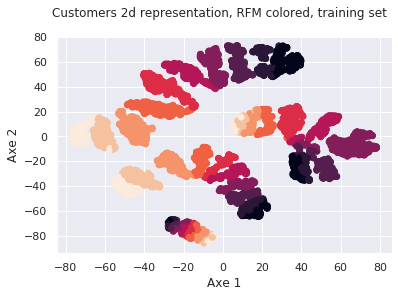

In [417]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, RFM colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=rfm_scores_train_colors)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

In [418]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=rfm_scores_train_colors),
                    text = rfm_scores_train,
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_allFeatswithRFMscore_color_RFM_final_tsne.html') 

'clusters_plot_clients_sne_allFeatswithRFMscore_color_RFM_final_tsne.html'

# Model with only bow features without RfmScore, coloration with RfmScore

In [419]:
importlib.reload(sys.modules['functions'])
from functions import *

In [420]:
df_train = df_train_ori
df_test = df_test_ori

In [421]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized'])),
    #('scaler', LogScalerMultiple(features_toscale=['RfmScore'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    #('minmaxscaler', MinMaxScalerMultiple(features_toscale=['RfmScore'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='TSNE', n_dim=3)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [422]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

No fit for TSNE


In [423]:
#rfm_scores_train = df_train['RfmScore']  # we reuse rfm_scores_train calculated on above model

In [424]:
unique_rfm_scores = np.sort(rfm_scores_train.unique())

In [425]:
rfm_dict_colors = {}
cnt = 0

for unique_rfm_score in unique_rfm_scores:
    rfm_dict_colors[unique_rfm_score] = cnt
    cnt += 1
    

In [426]:
rfm_scores_train_colors = rfm_scores_train.apply(lambda x : rfm_dict_colors[x])

In [427]:
rfm_scores_train_colors

CustomerID
12346    2
12347    3
12348    4
12349    0
12350    8
        ..
18280    8
18281    7
18282    7
18283    5
18287    1
Name: RfmScore, Length: 4332, dtype: int64

In [428]:
rfm_scores_train

CustomerID
12346    0.222222
12347    0.333333
12348    0.444444
12349    0.000000
12350    0.888889
           ...   
18280    0.888889
18281    0.777778
18282    0.777778
18283    0.555556
18287    0.111111
Name: RfmScore, Length: 4332, dtype: float64

In [429]:
df_train

0         1         2
0     0.783543  0.628913  0.878636
1     0.727786  0.430184  0.704302
2     0.741093  0.560714  0.462285
3     0.648290  0.514565  0.458161
4     0.759664  0.587738  0.564628
...        ...       ...       ...
4327  0.747399  0.632402  0.684291
4328  0.766730  0.647952  0.548147
4329  0.716419  0.469840  0.643490
4330  0.727965  0.528250  0.312737
4331  0.902739  0.582266  0.476758

[4332 rows x 3 columns]

In [430]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4332 entries, 0 to 4331
Data columns (total 3 columns):
0    4332 non-null float32
1    4332 non-null float32
2    4332 non-null float32
dtypes: float32(3)
memory usage: 50.9 KB


In [431]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

In [432]:
X_transformed[:,1]

array([-67.1679   , -49.622208 ,  27.984085 , ..., -11.2271185,
        63.46297  ,  43.64952  ], dtype=float32)

Text(0, 0.5, 'Axe 2')

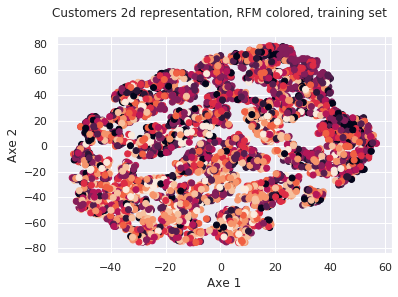

In [433]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, RFM colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=rfm_scores_train_colors)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

In [434]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=rfm_scores_train_colors),
                    text = rfm_scores_train,
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_onlybow_color_RFM_final_tsne.html') 

'clusters_plot_clients_sne_onlybow_color_RFM_final_tsne.html'

# Model with 'BoughtTopValueProduct', 'HasEverCancelled', 'RfmScore', coloration with RfmScore (INTERESTING)

In [435]:
importlib.reload(sys.modules['functions'])
from functions import *

In [436]:
df_train = df_train_ori
df_test = df_test_ori

In [437]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    #('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('features_selector', FeaturesSelector(features_toselect=['BoughtTopValueProduct', 'HasEverCancelled', 'RfmScore'])),
    #('scaler', LogScalerMultiple(features_toscale=['RfmScore'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    #('minmaxscaler', MinMaxScalerMultiple(features_toscale=['RfmScore'])),
    #('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
    #                                                    algorithm_to_use='TSNE', n_dim=3)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [438]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

In [439]:
#rfm_scores_train = df_train['RfmScore']  # we reuse rfm_scores_train calculated on above model

In [440]:
unique_rfm_scores = np.sort(rfm_scores_train.unique())

In [441]:
rfm_dict_colors = {}
cnt = 0

for unique_rfm_score in unique_rfm_scores:
    rfm_dict_colors[unique_rfm_score] = cnt
    cnt += 1
    

In [442]:
rfm_scores_train_colors = rfm_scores_train.apply(lambda x : rfm_dict_colors[x])

In [443]:
rfm_scores_train_colors

CustomerID
12346    2
12347    3
12348    4
12349    0
12350    8
        ..
18280    8
18281    7
18282    7
18283    5
18287    1
Name: RfmScore, Length: 4332, dtype: int64

In [444]:
rfm_scores_train

CustomerID
12346    0.222222
12347    0.333333
12348    0.444444
12349    0.000000
12350    0.888889
           ...   
18280    0.888889
18281    0.777778
18282    0.777778
18283    0.555556
18287    0.111111
Name: RfmScore, Length: 4332, dtype: float64

In [445]:
df_train

BoughtTopValueProduct  HasEverCancelled  RfmScore
CustomerID                                                   
12346                         1.0               1.0  0.222222
12347                         1.0               0.0  0.333333
12348                         0.0               0.0  0.444444
12349                         1.0               0.0  0.000000
12350                         0.0               0.0  0.888889
...                           ...               ...       ...
18280                         0.0               0.0  0.888889
18281                         0.0               0.0  0.777778
18282                         1.0               1.0  0.777778
18283                         1.0               0.0  0.555556
18287                         0.0               0.0  0.111111

[4332 rows x 3 columns]

In [446]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4332 entries, 12346 to 18287
Data columns (total 3 columns):
BoughtTopValueProduct    4332 non-null float64
HasEverCancelled         4332 non-null float64
RfmScore                 4332 non-null float64
dtypes: float64(3)
memory usage: 135.4+ KB


In [447]:
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

In [448]:
X_transformed[:,1]

array([-35.05074 ,  19.259274,  53.333263, ...,  10.042918, -19.394342,
       -60.06598 ], dtype=float32)

Text(0, 0.5, 'Axe 2')

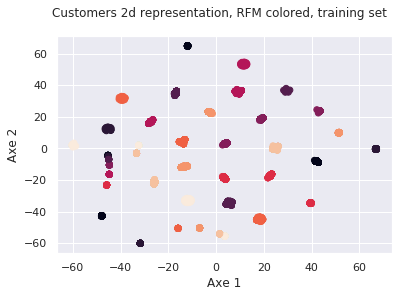

In [449]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, RFM colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=rfm_scores_train_colors)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

In [450]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=rfm_scores_train_colors),
                    text = rfm_scores_train,
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_allFeatsExceptBow_RfmScore_color_RFM_final_tsne.html') 

'clusters_plot_clients_sne_allFeatsExceptBow_RfmScore_color_RFM_final_tsne.html'

# Model with all features and RFM score (not individual RFM feats), and LLE

In [451]:
importlib.reload(sys.modules['functions'])
from functions import *

In [452]:
df_train = df_train_ori
df_test = df_test_ori

In [453]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'BoughtTopValueProduct', 'HasEverCancelled', 'RfmScore'])),
    #('scaler', LogScalerMultiple(features_toscale=['RfmScore'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['RfmScore'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='LLE', n_dim=3)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [454]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

In [455]:
rfm_scores_train = df_train['RfmScore']

In [456]:
unique_rfm_scores = np.sort(rfm_scores_train.unique())

In [457]:
rfm_dict_colors = {}
cnt = 0

for unique_rfm_score in unique_rfm_scores:
    rfm_dict_colors[unique_rfm_score] = cnt
    cnt += 1
    

In [458]:
rfm_scores_train_colors = rfm_scores_train.apply(lambda x : rfm_dict_colors[x])

In [459]:
rfm_scores_train_colors

CustomerID
12346    2
12347    3
12348    4
12349    0
12350    8
        ..
18280    8
18281    7
18282    7
18283    5
18287    1
Name: RfmScore, Length: 4332, dtype: int64

In [460]:
rfm_scores_train

CustomerID
12346    0.222222
12347    0.333333
12348    0.444444
12349    0.000000
12350    0.888889
           ...   
18280    0.888889
18281    0.777778
18282    0.777778
18283    0.555556
18287    0.111111
Name: RfmScore, Length: 4332, dtype: float64

In [461]:
df_train

RfmScore  BoughtTopValueProduct  HasEverCancelled         0  \
CustomerID                                                                
12346       0.222222                    1.0               1.0  0.929734   
12347       0.333333                    1.0               0.0  0.843635   
12348       0.444444                    0.0               0.0  0.838645   
12349       0.000000                    1.0               0.0  0.883346   
12350       0.888889                    0.0               0.0  0.784579   
...              ...                    ...               ...       ...   
18280       0.888889                    0.0               0.0  0.172324   
18281       0.777778                    0.0               0.0  0.928007   
18282       0.777778                    1.0               1.0  0.770153   
18283       0.555556                    1.0               0.0  0.859854   
18287       0.111111                    0.0               0.0  0.860197   

                   1         2  
CustomerID                      
12346       0.133125  0.286682  
12347       0.420629  0.521580  
12348       0.367967  0.501632  
12349       0.441245  0.512148  
12350       0.362319  0.578041  
...              ...       ...  
18280       0.146602  0.630801  
18281       0.306943  0.510048  
18282       0.791756  0.230194  
18283       0.382429  0.497818  
18287       0.361143  0.518040  

[4332 rows x 6 columns]

In [462]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4332 entries, 12346 to 18287
Data columns (total 6 columns):
RfmScore                 4332 non-null float64
BoughtTopValueProduct    4332 non-null float64
HasEverCancelled         4332 non-null float64
0                        4332 non-null float64
1                        4332 non-null float64
2                        4332 non-null float64
dtypes: float64(6)
memory usage: 396.9+ KB


In [463]:
'''
lle = LocallyLinearEmbedding(n_components=2, random_state=42)
X_transformed = lle.fit_transform(df_train)
X_test_transformed = lle.fit_transform(df_test)
'''
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)

In [464]:
X_transformed[:,1]

array([-14.130598,  32.97864 , -36.069946, ...,  65.11909 ,  29.876406,
       -37.786377], dtype=float32)

Text(0, 0.5, 'Axe 2')

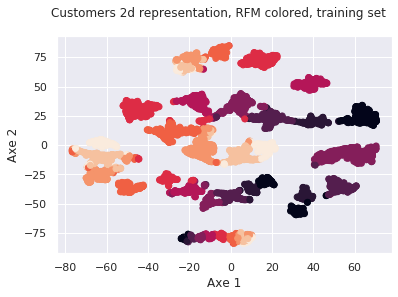

In [465]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, RFM colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=rfm_scores_train_colors)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

In [466]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=rfm_scores_train_colors),
                    text = rfm_scores_train,
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_allFeatswithRFMscore_color_RFM_final_lle.html') 

'clusters_plot_clients_sne_allFeatswithRFMscore_color_RFM_final_lle.html'

# Model with all features and RFM score (not individual RFM feats), and Isomap

In [467]:
importlib.reload(sys.modules['functions'])
from functions import *

In [468]:
df_train = df_train_ori
df_test = df_test_ori

In [469]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'BoughtTopValueProduct', 'HasEverCancelled', 'RfmScore'])),
    #('scaler', LogScalerMultiple(features_toscale=['RfmScore'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['RfmScore'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='ISOMAP', n_dim=3)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [470]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

In [471]:
rfm_scores_train = df_train['RfmScore']

In [472]:
unique_rfm_scores = np.sort(rfm_scores_train.unique())

In [473]:
rfm_dict_colors = {}
cnt = 0

for unique_rfm_score in unique_rfm_scores:
    rfm_dict_colors[unique_rfm_score] = cnt
    cnt += 1
    

In [474]:
rfm_scores_train_colors = rfm_scores_train.apply(lambda x : rfm_dict_colors[x])

In [475]:
rfm_scores_train_colors

CustomerID
12346    2
12347    3
12348    4
12349    0
12350    8
        ..
18280    8
18281    7
18282    7
18283    5
18287    1
Name: RfmScore, Length: 4332, dtype: int64

In [476]:
rfm_scores_train

CustomerID
12346    0.222222
12347    0.333333
12348    0.444444
12349    0.000000
12350    0.888889
           ...   
18280    0.888889
18281    0.777778
18282    0.777778
18283    0.555556
18287    0.111111
Name: RfmScore, Length: 4332, dtype: float64

In [477]:
df_train

RfmScore  BoughtTopValueProduct  HasEverCancelled         0  \
CustomerID                                                                
12346       0.222222                    1.0               1.0  0.130221   
12347       0.333333                    1.0               0.0  0.092100   
12348       0.444444                    0.0               0.0  0.157459   
12349       0.000000                    1.0               0.0  0.087152   
12350       0.888889                    0.0               0.0  0.113605   
...              ...                    ...               ...       ...   
18280       0.888889                    0.0               0.0  0.097145   
18281       0.777778                    0.0               0.0  0.120115   
18282       0.777778                    1.0               1.0  0.132320   
18283       0.555556                    1.0               0.0  0.298067   
18287       0.111111                    0.0               0.0  0.080440   

                   1         2  
CustomerID                      
12346       0.503131  0.452280  
12347       0.488378  0.601755  
12348       0.577756  0.469424  
12349       0.600322  0.381877  
12350       0.537165  0.409637  
...              ...       ...  
18280       0.506489  0.471256  
18281       0.515198  0.446693  
18282       0.493318  0.601695  
18283       0.824862  0.353478  
18287       0.418782  0.398126  

[4332 rows x 6 columns]

In [478]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4332 entries, 12346 to 18287
Data columns (total 6 columns):
RfmScore                 4332 non-null float64
BoughtTopValueProduct    4332 non-null float64
HasEverCancelled         4332 non-null float64
0                        4332 non-null float64
1                        4332 non-null float64
2                        4332 non-null float64
dtypes: float64(6)
memory usage: 396.9+ KB


In [479]:
'''
lle = LocallyLinearEmbedding(n_components=2, random_state=42)
X_transformed = lle.fit_transform(df_train)
X_test_transformed = lle.fit_transform(df_test)
'''
'''
tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)
'''
isomap = Isomap(n_components=2)
X_transformed = isomap.fit_transform(df_train)
X_test_transformed = isomap.fit_transform(df_test)


In [480]:
X_transformed[:,1]

array([-0.505888  ,  0.01122257,  0.01696769, ...,  0.63148287,
        0.01131283,  0.01330419])

Text(0, 0.5, 'Axe 2')

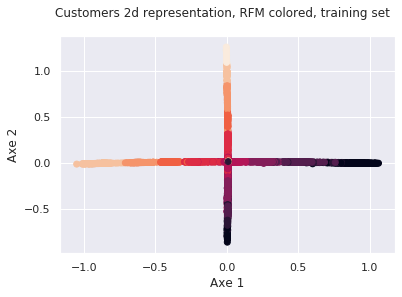

In [481]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, RFM colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=rfm_scores_train_colors)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

In [482]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=rfm_scores_train_colors),
                    text = rfm_scores_train,
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_sne_allFeatswithRFMscore_color_RFM_final_isomap.html') 

'clusters_plot_clients_sne_allFeatswithRFMscore_color_RFM_final_isomap.html'

# Model with all features and RFM score (cocncat) (not individual RFM feats), and NCA (BEST)

In [483]:
importlib.reload(sys.modules['functions'])
from functions import *

In [484]:
df_train = df_train_ori
df_test = df_test_ori

In [485]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'BoughtTopValueProduct', 'HasEverCancelled', 'RfmScore'])),
    #('scaler', LogScalerMultiple(features_toscale=['RfmScore'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['RfmScore'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='NCA', n_dim=3, labels_featurename='RfmScore')),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [486]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

/home/francois/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



In [487]:
rfm_scores_train = df_train['RfmScore']

In [488]:
unique_rfm_scores = np.sort(rfm_scores_train.unique())

In [489]:
rfm_dict_colors = {}
cnt = 0

for unique_rfm_score in unique_rfm_scores:
    rfm_dict_colors[unique_rfm_score] = cnt
    cnt += 1
    

In [490]:
rfm_scores_train_colors = rfm_scores_train.apply(lambda x : rfm_dict_colors[x])

In [491]:
rfm_scores_train_colors

CustomerID
12346    2
12347    3
12348    4
12349    0
12350    8
        ..
18280    8
18281    7
18282    7
18283    5
18287    1
Name: RfmScore, Length: 4332, dtype: int64

In [492]:
rfm_scores_train

CustomerID
12346    0.222222
12347    0.333333
12348    0.444444
12349    0.000000
12350    0.888889
           ...   
18280    0.888889
18281    0.777778
18282    0.777778
18283    0.555556
18287    0.111111
Name: RfmScore, Length: 4332, dtype: float64

In [493]:
df_train

RfmScore  BoughtTopValueProduct  HasEverCancelled         0  \
CustomerID                                                                
12346       0.222222                    1.0               1.0  0.676540   
12347       0.333333                    1.0               0.0  0.376058   
12348       0.444444                    0.0               0.0  0.620861   
12349       0.000000                    1.0               0.0  0.300920   
12350       0.888889                    0.0               0.0  0.671532   
...              ...                    ...               ...       ...   
18280       0.888889                    0.0               0.0  0.759341   
18281       0.777778                    0.0               0.0  0.647395   
18282       0.777778                    1.0               1.0  0.692695   
18283       0.555556                    1.0               0.0  0.485599   
18287       0.111111                    0.0               0.0  0.372088   

                   1         2  
CustomerID                      
12346       0.890660  0.200802  
12347       0.585569  0.546905  
12348       0.781429  0.435960  
12349       0.692551  0.559524  
12350       0.899365  0.167804  
...              ...       ...  
18280       0.895909  0.376530  
18281       0.898121  0.193688  
18282       0.830497  0.175052  
18283       0.360059  0.613170  
18287       0.734318  0.241995  

[4332 rows x 6 columns]

In [494]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4332 entries, 12346 to 18287
Data columns (total 6 columns):
RfmScore                 4332 non-null float64
BoughtTopValueProduct    4332 non-null float64
HasEverCancelled         4332 non-null float64
0                        4332 non-null float64
1                        4332 non-null float64
2                        4332 non-null float64
dtypes: float64(6)
memory usage: 396.9+ KB


In [495]:
'''
lle = LocallyLinearEmbedding(n_components=2, random_state=42)
X_transformed = lle.fit_transform(df_train)
X_test_transformed = lle.fit_transform(df_test)
'''

tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)


'''
isomap = Isomap(n_components=2)
X_transformed = isomap.fit_transform(df_train)
X_test_transformed = isomap.fit_transform(df_test)
'''


'\nisomap = Isomap(n_components=2)\nX_transformed = isomap.fit_transform(df_train)\nX_test_transformed = isomap.fit_transform(df_test)\n'

In [496]:
X_transformed[:,1]

array([-29.962112 ,  37.860367 , -26.154505 , ...,   1.4435217,
        30.728355 , -43.268574 ], dtype=float32)

Text(0, 0.5, 'Axe 2')

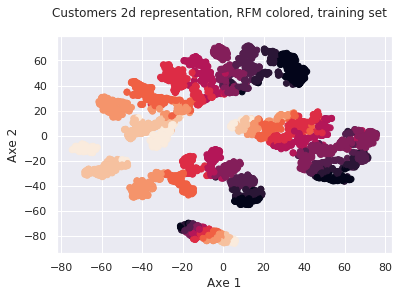

In [497]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, RFM colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=rfm_scores_train_colors)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

Text(0, 0.5, 'Axe 2')

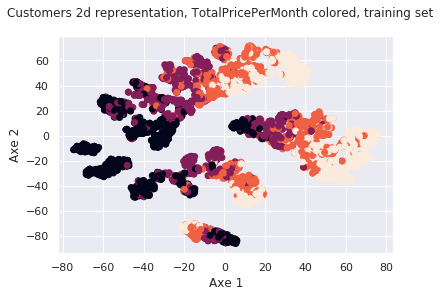

In [498]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, TotalPricePerMonth colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

In [499]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=rfm_scores_train_colors),
                    #text = rfm_scores_train,
                    #text = [('Bought top value product' if (boughttopvalueproduct == 1) else 'dit NOT buy top value product') for boughttopvalueproduct in df_train['BoughtTopValueProduct']],
                    text = list(map(str, zip('RFM: ' + rfm_scores_train.astype(str),\
                                             'BoughtTopValueProduct: ' + df_train['BoughtTopValueProduct'].astype(str),\
                                              'HasEverCancelled: '  + df_train['HasEverCancelled'].astype(str),\
                                              'Bow0: ' + df_train[0].astype(str),\
                                              'Bow1: ' + df_train[1].astype(str),\
                                              'Bow2: ' + df_train[2].astype(str),\
                                            ))\
                                        )
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_NCA_allFeatswithRFMscore_color_RFM_final_tsnelast.html') 

'clusters_plot_clients_NCA_allFeatswithRFMscore_color_RFM_final_tsnelast.html'

# Model with all features and RFM score (SUM) (not individual RFM feats), and NCA (BEST)

In [500]:
importlib.reload(sys.modules['functions'])
from functions import *

In [501]:
df_train = df_train_ori
df_test = df_test_ori

In [502]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'BoughtTopValueProduct', 'HasEverCancelled', 'RfmScore'])),
    #('scaler', LogScalerMultiple(features_toscale=['RfmScore'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['RfmScore'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='NCA', n_dim=3, labels_featurename='RfmScore')),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [503]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

/home/francois/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



In [504]:
rfm_scores_train = df_train['RfmScore']

In [505]:
unique_rfm_scores = np.sort(rfm_scores_train.unique())

In [506]:
rfm_dict_colors = {}
cnt = 0

for unique_rfm_score in unique_rfm_scores:
    rfm_dict_colors[unique_rfm_score] = cnt
    cnt += 1
    

In [507]:
rfm_scores_train_colors = rfm_scores_train.apply(lambda x : rfm_dict_colors[x])

In [508]:
rfm_scores_train_colors

CustomerID
12346    2
12347    3
12348    4
12349    0
12350    8
        ..
18280    8
18281    7
18282    7
18283    5
18287    1
Name: RfmScore, Length: 4332, dtype: int64

In [509]:
rfm_scores_train

CustomerID
12346    0.222222
12347    0.333333
12348    0.444444
12349    0.000000
12350    0.888889
           ...   
18280    0.888889
18281    0.777778
18282    0.777778
18283    0.555556
18287    0.111111
Name: RfmScore, Length: 4332, dtype: float64

In [510]:
df_train

RfmScore  BoughtTopValueProduct  HasEverCancelled         0  \
CustomerID                                                                
12346       0.222222                    1.0               1.0  0.676540   
12347       0.333333                    1.0               0.0  0.376058   
12348       0.444444                    0.0               0.0  0.620861   
12349       0.000000                    1.0               0.0  0.300920   
12350       0.888889                    0.0               0.0  0.671532   
...              ...                    ...               ...       ...   
18280       0.888889                    0.0               0.0  0.759341   
18281       0.777778                    0.0               0.0  0.647395   
18282       0.777778                    1.0               1.0  0.692695   
18283       0.555556                    1.0               0.0  0.485599   
18287       0.111111                    0.0               0.0  0.372088   

                   1         2  
CustomerID                      
12346       0.890660  0.200802  
12347       0.585569  0.546905  
12348       0.781429  0.435960  
12349       0.692551  0.559524  
12350       0.899365  0.167804  
...              ...       ...  
18280       0.895909  0.376530  
18281       0.898121  0.193688  
18282       0.830497  0.175052  
18283       0.360059  0.613170  
18287       0.734318  0.241995  

[4332 rows x 6 columns]

In [511]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4332 entries, 12346 to 18287
Data columns (total 6 columns):
RfmScore                 4332 non-null float64
BoughtTopValueProduct    4332 non-null float64
HasEverCancelled         4332 non-null float64
0                        4332 non-null float64
1                        4332 non-null float64
2                        4332 non-null float64
dtypes: float64(6)
memory usage: 396.9+ KB


In [512]:
'''
lle = LocallyLinearEmbedding(n_components=2, random_state=42)
X_transformed = lle.fit_transform(df_train)
X_test_transformed = lle.fit_transform(df_test)
'''

tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)


'''
isomap = Isomap(n_components=2)
X_transformed = isomap.fit_transform(df_train)
X_test_transformed = isomap.fit_transform(df_test)
'''


'\nisomap = Isomap(n_components=2)\nX_transformed = isomap.fit_transform(df_train)\nX_test_transformed = isomap.fit_transform(df_test)\n'

In [513]:
X_transformed[:,1]

array([-29.962112 ,  37.860367 , -26.154505 , ...,   1.4435217,
        30.728355 , -43.268574 ], dtype=float32)

Text(0, 0.5, 'Axe 2')

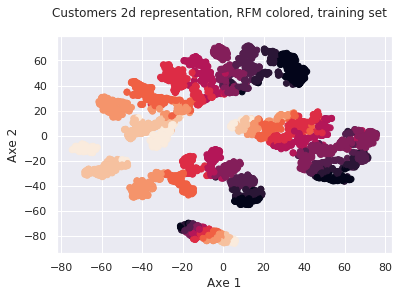

In [514]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, RFM colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=rfm_scores_train_colors)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

Text(0, 0.5, 'Axe 2')

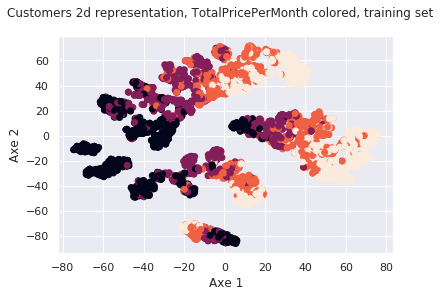

In [515]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, TotalPricePerMonth colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

In [516]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=rfm_scores_train_colors),
                    #text = rfm_scores_train,
                    #text = [('Bought top value product' if (boughttopvalueproduct == 1) else 'dit NOT buy top value product') for boughttopvalueproduct in df_train['BoughtTopValueProduct']],
                    text = list(map(str, zip('RFM: ' + rfm_scores_train.astype(str),\
                                             'BoughtTopValueProduct: ' + df_train['BoughtTopValueProduct'].astype(str),\
                                              'HasEverCancelled: '  + df_train['HasEverCancelled'].astype(str),\
                                              'Bow0: ' + df_train[0].astype(str),\
                                              'Bow1: ' + df_train[1].astype(str),\
                                              'Bow2: ' + df_train[2].astype(str),\
                                            ))\
                                        )
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_NCA_allFeatswithRFMscoreSUM_color_RFM_final_tsnelast.html') 

'clusters_plot_clients_NCA_allFeatswithRFMscoreSUM_color_RFM_final_tsnelast.html'

In [517]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=bow_labels_train),
                    #text = rfm_scores_train,
                    #text = [('Bought top value product' if (boughttopvalueproduct == 1) else 'dit NOT buy top value product') for boughttopvalueproduct in df_train['BoughtTopValueProduct']],
                    text = list(map(str, zip('RFM: ' + rfm_scores_train.astype(str),\
                                             'BoughtTopValueProduct: ' + df_train['BoughtTopValueProduct'].astype(str),\
                                              'HasEverCancelled: '  + df_train['HasEverCancelled'].astype(str),\
                                              'Bow0: ' + df_train[0].astype(str),\
                                              'Bow1: ' + df_train[1].astype(str),\
                                              'Bow2: ' + df_train[2].astype(str),\
                                            ))\
                                        )
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_NCA_allFeatswithRFMscoreSUM_color_BoW_final_tsnelast.html') 

'clusters_plot_clients_NCA_allFeatswithRFMscoreSUM_color_BoW_final_tsnelast.html'

Text(0, 0.5, 'Axe 2')

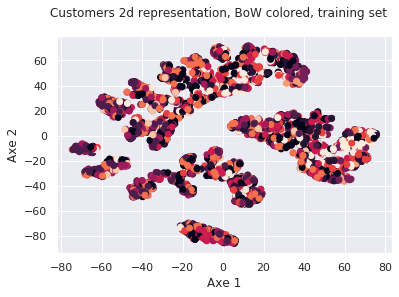

In [518]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, BoW colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=bow_labels_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

# Model with all features except RFM score, and TSNE, colored by RFM

In [519]:
importlib.reload(sys.modules['functions'])
from functions import *

In [520]:
df_train = df_train_ori
df_test = df_test_ori

In [521]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'BoughtTopValueProduct', 'HasEverCancelled'])),
    #('scaler', LogScalerMultiple(features_toscale=['RfmScore'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    #('minmaxscaler', MinMaxScalerMultiple(features_toscale=['RfmScore'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='TSNE', n_dim=3)),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [522]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

No fit for TSNE


In [523]:
#rfm_scores_train = df_train['RfmScore'] # rfm_scores_train value has been got from code above

In [524]:
unique_rfm_scores = np.sort(rfm_scores_train.unique())

In [525]:
rfm_dict_colors = {}
cnt = 0

for unique_rfm_score in unique_rfm_scores:
    rfm_dict_colors[unique_rfm_score] = cnt
    cnt += 1
    

In [526]:
rfm_scores_train_colors = rfm_scores_train.apply(lambda x : rfm_dict_colors[x])

In [527]:
rfm_scores_train_colors

CustomerID
12346    2
12347    3
12348    4
12349    0
12350    8
        ..
18280    8
18281    7
18282    7
18283    5
18287    1
Name: RfmScore, Length: 4332, dtype: int64

In [528]:
rfm_scores_train

CustomerID
12346    0.222222
12347    0.333333
12348    0.444444
12349    0.000000
12350    0.888889
           ...   
18280    0.888889
18281    0.777778
18282    0.777778
18283    0.555556
18287    0.111111
Name: RfmScore, Length: 4332, dtype: float64

In [529]:
df_train

BoughtTopValueProduct  HasEverCancelled         0         1  \
CustomerID                                                                
12346                         1.0               1.0  0.783543  0.628913   
12347                         1.0               0.0  0.727786  0.430184   
12348                         0.0               0.0  0.741093  0.560714   
12349                         1.0               0.0  0.648290  0.514565   
12350                         0.0               0.0  0.759664  0.587738   
...                           ...               ...       ...       ...   
18280                         0.0               0.0  0.747399  0.632402   
18281                         0.0               0.0  0.766730  0.647952   
18282                         1.0               1.0  0.716419  0.469840   
18283                         1.0               0.0  0.727965  0.528250   
18287                         0.0               0.0  0.902739  0.582266   

                   2  
CustomerID            
12346       0.878636  
12347       0.704302  
12348       0.462285  
12349       0.458161  
12350       0.564628  
...              ...  
18280       0.684291  
18281       0.548147  
18282       0.643490  
18283       0.312737  
18287       0.476758  

[4332 rows x 5 columns]

In [530]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4332 entries, 12346 to 18287
Data columns (total 5 columns):
BoughtTopValueProduct    4332 non-null float64
HasEverCancelled         4332 non-null float64
0                        4332 non-null float64
1                        4332 non-null float64
2                        4332 non-null float64
dtypes: float64(5)
memory usage: 203.1+ KB


In [531]:
'''
lle = LocallyLinearEmbedding(n_components=2, random_state=42)
X_transformed = lle.fit_transform(df_train)
X_test_transformed = lle.fit_transform(df_test)
'''

tsne = TSNE(n_components=2, random_state=42)
X_transformed = tsne.fit_transform(df_train)
X_test_transformed = tsne.fit_transform(df_test)


'''
isomap = Isomap(n_components=2)
X_transformed = isomap.fit_transform(df_train)
X_test_transformed = isomap.fit_transform(df_test)
'''


'\nisomap = Isomap(n_components=2)\nX_transformed = isomap.fit_transform(df_train)\nX_test_transformed = isomap.fit_transform(df_test)\n'

In [532]:
X_transformed[:,1]

array([-33.27289 ,   9.164245, -29.82518 , ..., -12.101926,  55.20925 ,
       -19.78339 ], dtype=float32)

Text(0, 0.5, 'Axe 2')

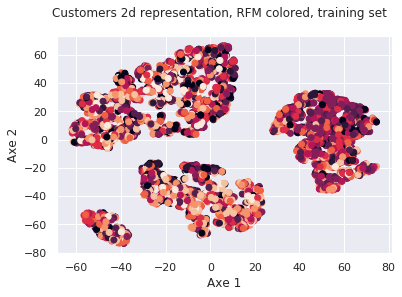

In [533]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, RFM colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=rfm_scores_train_colors)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

Text(0, 0.5, 'Axe 2')

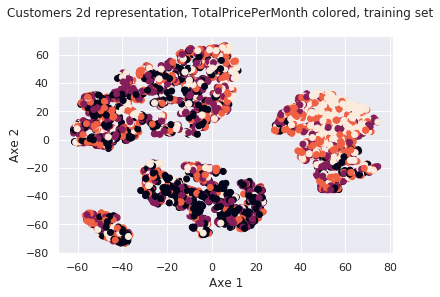

In [534]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, TotalPricePerMonth colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=df_score_cat_train)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

In [535]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter(x = X_transformed[:,0], y = X_transformed[:,1],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=rfm_scores_train_colors),
                    #text = rfm_scores_train,
                    #text = [('Bought top value product' if (boughttopvalueproduct == 1) else 'dit NOT buy top value product') for boughttopvalueproduct in df_train['BoughtTopValueProduct']],
                    text = list(map(str, zip('rfm: ' + rfm_scores_train.astype(str), 'BoughtTopValueProduct: ' + df_train['BoughtTopValueProduct'].astype(str),\
                                              'HasEverCancelled: '  + df_train['HasEverCancelled'].astype(str),\
                                            ))\
                                        )
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_TSNE_allFeatswithOUTRFMscore_color_RFM_final_tsnelast.html') 

'clusters_plot_clients_TSNE_allFeatswithOUTRFMscore_color_RFM_final_tsnelast.html'

# Model with 'DescriptionNormalized', 'BoughtTopValueProduct', 'HasEverCancelled', 'RfmScore' (concat) with NCA up to 200 then KMeans then NCA to visualize clusters   (GOOD, ONLY NCA not TSNE)

In [536]:
importlib.reload(sys.modules['functions'])
from functions import *

In [537]:
df_train = df_train_ori
df_test = df_test_ori

In [538]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'BoughtTopValueProduct', 'HasEverCancelled', 'RfmScore'])),
    #('scaler', LogScalerMultiple(features_toscale=['RfmScore'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['RfmScore'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='NCA', n_dim=3, labels_featurename='RfmScore')),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [539]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

/home/francois/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



In [540]:
rfm_scores_train = df_train['RfmScore']
rfm_scores_test = df_test['RfmScore']

In [541]:
unique_rfm_scores = np.sort(rfm_scores_train.unique())
unique_rfm_scores_test = np.sort(rfm_scores_test.unique())

In [542]:
rfm_dict_colors = {}
cnt = 0

for unique_rfm_score in unique_rfm_scores:
    rfm_dict_colors[unique_rfm_score] = cnt
    cnt += 1

rfm_dict_colors_test = {}
cnt = 0

for unique_rfm_score in unique_rfm_scores_test:
    rfm_dict_colors_test[unique_rfm_score] = cnt
    cnt += 1    

In [543]:
rfm_scores_train_colors = rfm_scores_train.apply(lambda x : rfm_dict_colors[x])
rfm_scores_test_colors = rfm_scores_test.apply(lambda x : rfm_dict_colors_test[x])

In [544]:
rfm_scores_train_colors

CustomerID
12346    2
12347    3
12348    4
12349    0
12350    8
        ..
18280    8
18281    7
18282    7
18283    5
18287    1
Name: RfmScore, Length: 4332, dtype: int64

In [545]:
rfm_scores_test_colors

CustomerID
12347    4
12348    8
12349    0
12350    8
12352    6
        ..
18276    5
18280    8
18282    4
18283    5
18287    2
Name: RfmScore, Length: 3771, dtype: int64

In [546]:
rfm_scores_train

CustomerID
12346    0.222222
12347    0.333333
12348    0.444444
12349    0.000000
12350    0.888889
           ...   
18280    0.888889
18281    0.777778
18282    0.777778
18283    0.555556
18287    0.111111
Name: RfmScore, Length: 4332, dtype: float64

In [547]:
df_train

RfmScore  BoughtTopValueProduct  HasEverCancelled         0  \
CustomerID                                                                
12346       0.222222                    1.0               1.0  0.676540   
12347       0.333333                    1.0               0.0  0.376058   
12348       0.444444                    0.0               0.0  0.620861   
12349       0.000000                    1.0               0.0  0.300920   
12350       0.888889                    0.0               0.0  0.671532   
...              ...                    ...               ...       ...   
18280       0.888889                    0.0               0.0  0.759341   
18281       0.777778                    0.0               0.0  0.647395   
18282       0.777778                    1.0               1.0  0.692695   
18283       0.555556                    1.0               0.0  0.485599   
18287       0.111111                    0.0               0.0  0.372088   

                   1         2  
CustomerID                      
12346       0.890660  0.200802  
12347       0.585569  0.546905  
12348       0.781429  0.435960  
12349       0.692551  0.559524  
12350       0.899365  0.167804  
...              ...       ...  
18280       0.895909  0.376530  
18281       0.898121  0.193688  
18282       0.830497  0.175052  
18283       0.360059  0.613170  
18287       0.734318  0.241995  

[4332 rows x 6 columns]

In [548]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4332 entries, 12346 to 18287
Data columns (total 6 columns):
RfmScore                 4332 non-null float64
BoughtTopValueProduct    4332 non-null float64
HasEverCancelled         4332 non-null float64
0                        4332 non-null float64
1                        4332 non-null float64
2                        4332 non-null float64
dtypes: float64(6)
memory usage: 396.9+ KB


In [549]:
'''
df_train_rfmscore_distances = pairwise_distances(df_train['RfmScore'].to_numpy().reshape(-1, 1))
df_test_rfmscore_distances = pairwise_distances(df_test['RfmScore'].to_numpy().reshape(-1, 1))
'''

"\ndf_train_rfmscore_distances = pairwise_distances(df_train['RfmScore'].to_numpy().reshape(-1, 1))\ndf_test_rfmscore_distances = pairwise_distances(df_test['RfmScore'].to_numpy().reshape(-1, 1))\n"

In [550]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df_train)
                for k in range(1, 50)]

In [551]:
labels_test_per_k = [model.predict(df_test) for model in kmeans_per_k[1:]]

In [552]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in kmeans_per_k[1:]]

In [553]:
silhouette_scores_test = [silhouette_score(df_test, labels_test) for labels_test in labels_test_per_k]

In [554]:
# Model corresponding to max silhouette score. We add +1 because "for model in kmeans_per_k[1:] above has suppressed one indice"
# kmeans_per_k[silhouette_scores.index(max(silhouette_scores)) + 1].labels_

In [555]:
entropy_mean_score_per_k_train = []

for model in kmeans_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(df_train['RfmScore'][model.labels_ == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_train.append(entropy_sum)

    
entropy_mean_score_per_k_test = []

for labels_test in labels_test_per_k:
    unique_labels = np.unique(labels_test)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(df_test['RfmScore'][labels_test == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_test.append(entropy_sum)    
    

/home/francois/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2614: RuntimeWarning:

invalid value encountered in true_divide



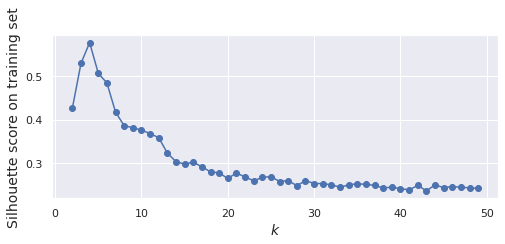

In [556]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

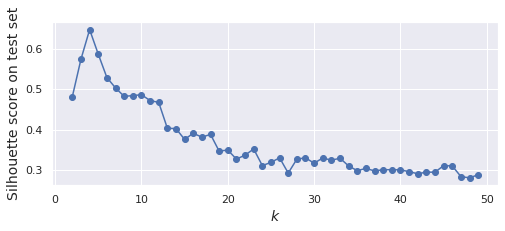

In [557]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [558]:
print('Entropy before clustering :')
entropy(df_train['RfmScore'])

Entropy before clustering :


8.163724487618794

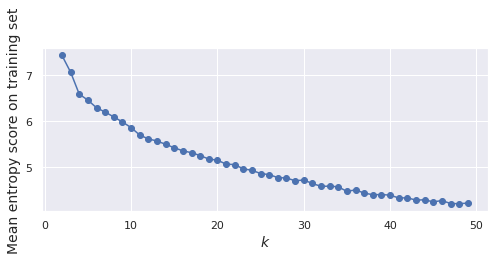

In [559]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

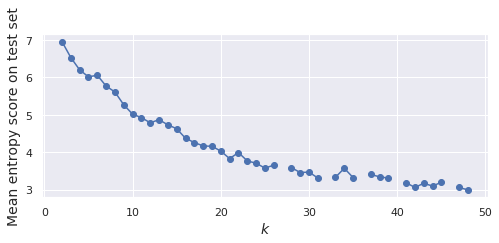

In [560]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

## Reduce and visualize

In [561]:
nca = NeighborhoodComponentsAnalysis(n_components=2, random_state=42)
X_transformed = nca.fit_transform(df_train, pd.cut(df_train['RfmScore'], bins=range(1,10), right=True).astype(str).tolist())
X_test_transformed = nca.transform(df_test)

Text(0, 0.5, 'Axe 2')

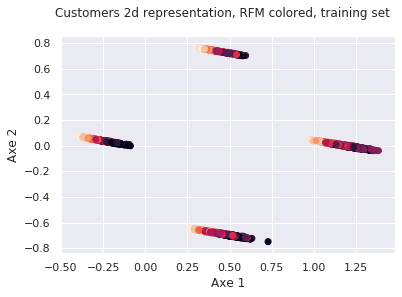

In [562]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, RFM colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=rfm_scores_train_colors)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

Text(0, 0.5, 'Axe 2')

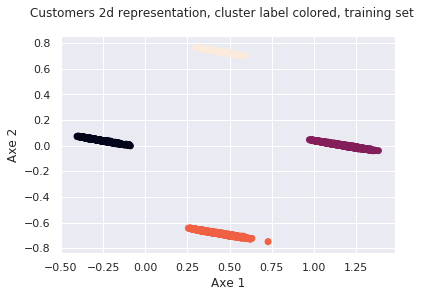

In [563]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, cluster label colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=kmeans_per_k[silhouette_scores.index(max(silhouette_scores)) + 1].labels_)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

In [564]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_transformed)
                for k in range(1, 50)]

In [565]:
labels_test_per_k = [model.predict(X_test_transformed) for model in kmeans_per_k[1:]]

In [566]:
silhouette_scores = [silhouette_score(X_transformed, model.labels_)
                     for model in kmeans_per_k[1:]]

In [567]:
silhouette_scores_test = [silhouette_score(X_test_transformed, labels_test) for labels_test in labels_test_per_k]

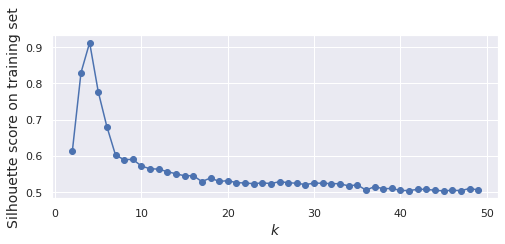

In [568]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

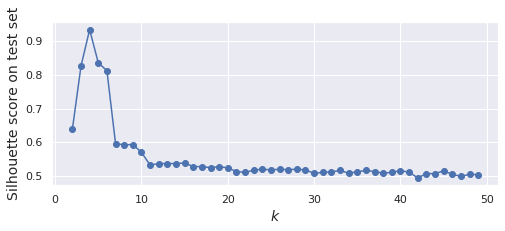

In [569]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [570]:
print('Entropy before clustering :')
entropy(df_train['RfmScore'])

Entropy before clustering :


8.163724487618794

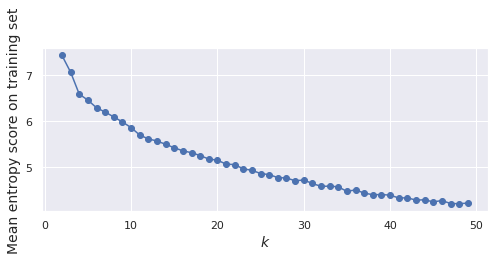

In [571]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

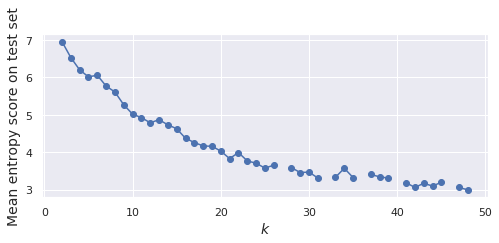

In [572]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

# Model with 'DescriptionNormalized', 'BoughtTopValueProduct', 'HasEverCancelled', 'RfmScore' (SUM) with NCA up to 200 then KMeans then NCA to visualize clusters   (GOOD, ONLY NCA not TSNE)

In [573]:
importlib.reload(sys.modules['functions'])
from functions import *

In [574]:
df_train = df_train_ori
df_test = df_test_ori

In [575]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'BoughtTopValueProduct', 'HasEverCancelled', 'RfmScore'])),
    #('scaler', LogScalerMultiple(features_toscale=['RfmScore'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['RfmScore'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='NCA', n_dim=3, labels_featurename='RfmScore')),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [576]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

/home/francois/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



In [577]:
rfm_scores_train = df_train['RfmScore']
rfm_scores_test = df_test['RfmScore']

In [578]:
unique_rfm_scores = np.sort(rfm_scores_train.unique())
unique_rfm_scores_test = np.sort(rfm_scores_test.unique())

In [579]:
rfm_dict_colors = {}
cnt = 0

for unique_rfm_score in unique_rfm_scores:
    rfm_dict_colors[unique_rfm_score] = cnt
    cnt += 1

rfm_dict_colors_test = {}
cnt = 0

for unique_rfm_score in unique_rfm_scores_test:
    rfm_dict_colors_test[unique_rfm_score] = cnt
    cnt += 1    

In [580]:
rfm_scores_train_colors = rfm_scores_train.apply(lambda x : rfm_dict_colors[x])
rfm_scores_test_colors = rfm_scores_test.apply(lambda x : rfm_dict_colors_test[x])

In [581]:
rfm_scores_train_colors

CustomerID
12346    2
12347    3
12348    4
12349    0
12350    8
        ..
18280    8
18281    7
18282    7
18283    5
18287    1
Name: RfmScore, Length: 4332, dtype: int64

In [582]:
rfm_scores_test_colors

CustomerID
12347    4
12348    8
12349    0
12350    8
12352    6
        ..
18276    5
18280    8
18282    4
18283    5
18287    2
Name: RfmScore, Length: 3771, dtype: int64

In [583]:
rfm_scores_train

CustomerID
12346    0.222222
12347    0.333333
12348    0.444444
12349    0.000000
12350    0.888889
           ...   
18280    0.888889
18281    0.777778
18282    0.777778
18283    0.555556
18287    0.111111
Name: RfmScore, Length: 4332, dtype: float64

In [584]:
df_train

RfmScore  BoughtTopValueProduct  HasEverCancelled         0  \
CustomerID                                                                
12346       0.222222                    1.0               1.0  0.676540   
12347       0.333333                    1.0               0.0  0.376058   
12348       0.444444                    0.0               0.0  0.620861   
12349       0.000000                    1.0               0.0  0.300920   
12350       0.888889                    0.0               0.0  0.671532   
...              ...                    ...               ...       ...   
18280       0.888889                    0.0               0.0  0.759341   
18281       0.777778                    0.0               0.0  0.647395   
18282       0.777778                    1.0               1.0  0.692695   
18283       0.555556                    1.0               0.0  0.485599   
18287       0.111111                    0.0               0.0  0.372088   

                   1         2  
CustomerID                      
12346       0.890660  0.200802  
12347       0.585569  0.546905  
12348       0.781429  0.435960  
12349       0.692551  0.559524  
12350       0.899365  0.167804  
...              ...       ...  
18280       0.895909  0.376530  
18281       0.898121  0.193688  
18282       0.830497  0.175052  
18283       0.360059  0.613170  
18287       0.734318  0.241995  

[4332 rows x 6 columns]

In [585]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4332 entries, 12346 to 18287
Data columns (total 6 columns):
RfmScore                 4332 non-null float64
BoughtTopValueProduct    4332 non-null float64
HasEverCancelled         4332 non-null float64
0                        4332 non-null float64
1                        4332 non-null float64
2                        4332 non-null float64
dtypes: float64(6)
memory usage: 396.9+ KB


In [586]:
'''
df_train_rfmscore_distances = pairwise_distances(df_train['RfmScore'].to_numpy().reshape(-1, 1))
df_test_rfmscore_distances = pairwise_distances(df_test['RfmScore'].to_numpy().reshape(-1, 1))
'''

"\ndf_train_rfmscore_distances = pairwise_distances(df_train['RfmScore'].to_numpy().reshape(-1, 1))\ndf_test_rfmscore_distances = pairwise_distances(df_test['RfmScore'].to_numpy().reshape(-1, 1))\n"

In [587]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df_train)
                for k in range(1, 50)]

In [588]:
labels_test_per_k = [model.predict(df_test) for model in kmeans_per_k[1:]]

In [589]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in kmeans_per_k[1:]]

In [590]:
silhouette_scores_test = [silhouette_score(df_test, labels_test) for labels_test in labels_test_per_k]

In [591]:
# Model corresponding to max silhouette score. We add +1 because "for model in kmeans_per_k[1:] above has suppressed one indice"
# kmeans_per_k[silhouette_scores.index(max(silhouette_scores)) + 1].labels_

In [592]:
entropy_mean_score_per_k_train = []

for model in kmeans_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(df_train['RfmScore'][model.labels_ == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_train.append(entropy_sum)

    
entropy_mean_score_per_k_test = []

for labels_test in labels_test_per_k:
    unique_labels = np.unique(labels_test)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(df_test['RfmScore'][labels_test == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_test.append(entropy_sum)    
    

/home/francois/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2614: RuntimeWarning:

invalid value encountered in true_divide



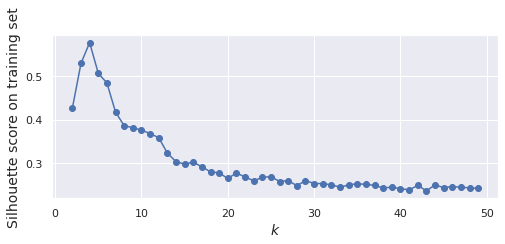

In [593]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

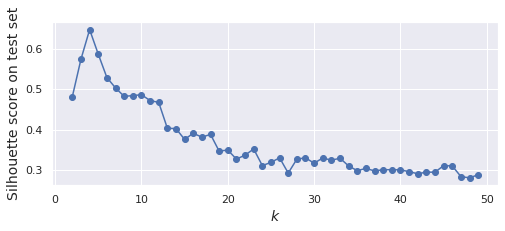

In [594]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [595]:
print('Entropy before clustering :')
entropy(df_train['RfmScore'])

Entropy before clustering :


8.163724487618794

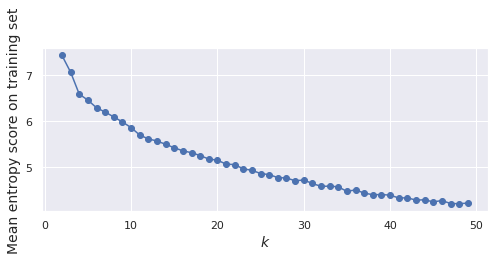

In [596]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

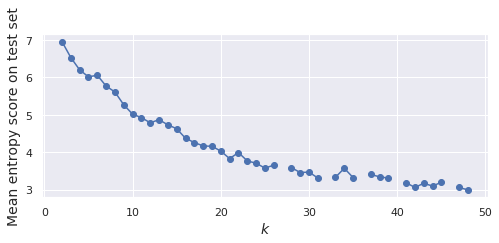

In [597]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

## Reduce and visualize

In [598]:
nca = NeighborhoodComponentsAnalysis(n_components=2, random_state=42)
X_transformed = nca.fit_transform(df_train, pd.cut(df_train['RfmScore'], bins=range(1,10), right=True).astype(str).tolist())
X_test_transformed = nca.transform(df_test)

Text(0, 0.5, 'Axe 2')

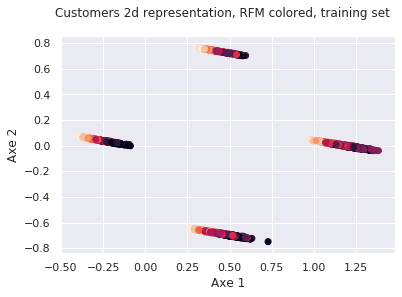

In [599]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, RFM colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=rfm_scores_train_colors)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

Text(0, 0.5, 'Axe 2')

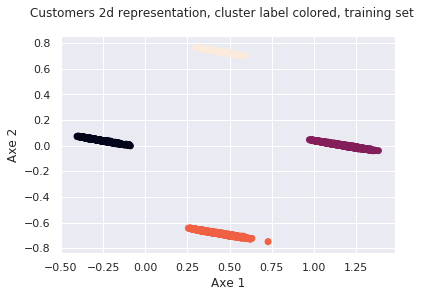

In [600]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, cluster label colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=kmeans_per_k[silhouette_scores.index(max(silhouette_scores)) + 1].labels_)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

In [601]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_transformed)
                for k in range(1, 50)]

In [602]:
labels_test_per_k = [model.predict(X_test_transformed) for model in kmeans_per_k[1:]]

In [603]:
silhouette_scores = [silhouette_score(X_transformed, model.labels_)
                     for model in kmeans_per_k[1:]]

In [604]:
silhouette_scores_test = [silhouette_score(X_test_transformed, labels_test) for labels_test in labels_test_per_k]

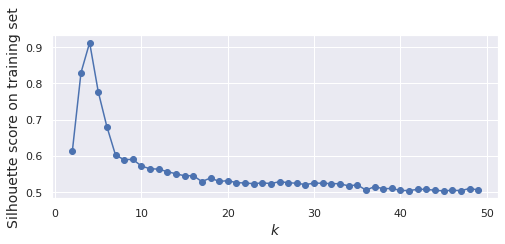

In [605]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

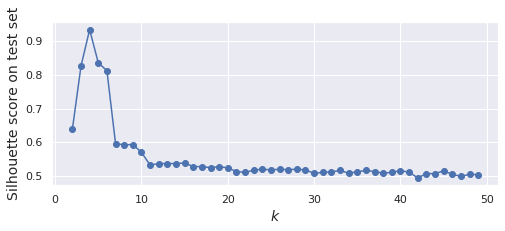

In [606]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [607]:
print('Entropy before clustering :')
entropy(df_train['RfmScore'])

Entropy before clustering :


8.163724487618794

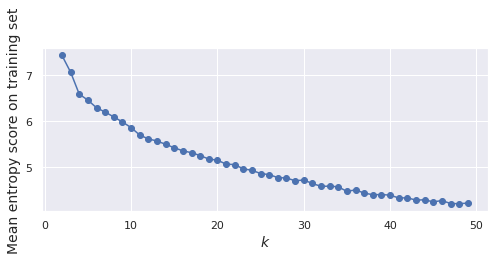

In [608]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), entropy_mean_score_per_k_train, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Mean entropy score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [609]:
df_test

RfmScore  BoughtTopValueProduct  HasEverCancelled         0  \
CustomerID                                                                
12347       0.444444                    0.0               0.0  0.509805   
12348       0.888889                    0.0               0.0  0.701943   
12349       0.000000                    1.0               0.0  0.726419   
12350       0.888889                    0.0               0.0  0.694705   
12352       0.666667                    0.0               1.0  0.731159   
...              ...                    ...               ...       ...   
18276       0.555556                    0.0               0.0  0.698233   
18280       0.888889                    1.0               0.0  0.719165   
18282       0.444444                    0.0               0.0  0.659869   
18283       0.555556                    1.0               0.0  0.591159   
18287       0.222222                    0.0               0.0  0.592849   

                   1         2  
CustomerID                      
12347       0.837135  0.369044  
12348       0.896124  0.148111  
12349       0.787971  0.323720  
12350       0.892958  0.166892  
12352       0.817971  0.315791  
...              ...       ...  
18276       0.906024  0.169599  
18280       0.885434  0.161395  
18282       0.928005  0.173816  
18283       0.681600  0.372192  
18287       0.774528  0.173737  

[3771 rows x 6 columns]

In [610]:
importlib.reload(sys.modules['functions'])
from functions import *

In [611]:
clusterer = Clusterer(n_clusters=11, algorithm_to_use='WARD')
clusterer.fit(df_train)

Clusterer(algorithm_to_use='WARD', n_clusters=11)

In [612]:
cluster_labels_test = clusterer.predict(df_test)

In [613]:
cluster_labels_train = clusterer.predict(df_train)

In [615]:
df_train[df_train.index == 0]

Empty DataFrame
Columns: [RfmScore, BoughtTopValueProduct, HasEverCancelled, 0, 1, 2]
Index: []

In [686]:
len(cluster_labels_test)

3771

In [688]:
cluster_labels_test

CustomerID
12347    5
12348    2
12349    1
12350    2
12352    7
        ..
18276    2
18280    4
18282    5
18283    0
18287    5
Name: 0, Length: 3771, dtype: int64

In [756]:
df_train

index InvoiceNo StockCode                         Description  \
0        11503    537781     21377  SMALL CAMPHOR WOOD FIELD  MUSHROOM   
1        40887    541855     21947           SET OF 6 HEART CHOPSTICKS   
2       103799    549646    85031A      ROMANTIC IMAGES SCRAP BOOK SET   
3       372911    578856     23535             WALL ART BICYCLE SAFETY   
4       297823    571747     23396   LE JARDIN BOTANIQUE CUSHION COVER   
...        ...       ...       ...                                 ...   
359915  128343    552843     22692         DOORMAT WELCOME TO OUR HOME   
359916  272049    569401     23356               LOVE HOT WATER BOTTLE   
359917  225276    564554     23280   FOLDING BUTTERFLY MIRROR HOT PINK   
359918  302898    572274     22423            REGENCY CAKESTAND 3 TIER   
359919  153432    555944     23165       LARGE CERAMIC TOP STORAGE JAR   

        Quantity          InvoiceDate  UnitPrice CustomerID         Country  \
0              1  2010-12-08 12:46:00       1.65      17341  United Kingdom   
1              1  2011-01-23 14:59:00       1.25      13742  United Kingdom   
2              6  2011-04-11 11:51:00       1.25      12982  United Kingdom   
3              4  2011-11-27 11:18:00       5.95      17769  United Kingdom   
4              4  2011-10-19 10:59:00       3.75      13849  United Kingdom   
...          ...                  ...        ...        ...             ...   
359915         1  2011-05-11 14:37:00       7.95      14649  United Kingdom   
359916         3  2011-10-04 08:56:00       5.95      15111  United Kingdom   
359917         1  2011-08-25 19:39:00       0.83      17189  United Kingdom   
359918        16  2011-10-21 16:48:00      10.95      14031  United Kingdom   
359919        12  2011-06-08 10:36:00       1.65      16955  United Kingdom   

        TotalPrice               DescriptionNormalized         InvoiceMonth  
0             1.65  SMALL CAMPHOR WOOD FIELD  MUSHROOM  2010-12-01 00:00:00  
1             1.25           SET OF 6 HEART CHOPSTICKS  2011-01-01 00:00:00  
2             7.50      ROMANTIC IMAGES SCRAP BOOK SET  2011-04-01 00:00:00  
3            23.80             WALL ART BICYCLE SAFETY  2011-11-01 00:00:00  
4            15.00   LE JARDIN BOTANIQUE CUSHION COVER  2011-10-01 00:00:00  
...            ...                                 ...                  ...  
359915        7.95         DOORMAT WELCOME TO OUR HOME  2011-05-01 00:00:00  
359916       17.85               LOVE HOT WATER BOTTLE  2011-10-01 00:00:00  
359917        0.83   FOLDING BUTTERFLY MIRROR HOT PINK  2011-08-01 00:00:00  
359918      175.20            REGENCY CAKESTAND 3 TIER  2011-10-01 00:00:00  
359919       19.80       LARGE CERAMIC TOP STORAGE JAR  2011-06-01 00:00:00  

[359920 rows x 12 columns]

In [690]:
cluster_labels_train

CustomerID
12346    8
12347    0
12348    5
12349    1
12350    2
        ..
18280    2
18281    2
18282    3
18283    0
18287    5
Name: 0, Length: 4332, dtype: int64

In [691]:
clusterer.clusterer.labels_

array([8, 0, 5, ..., 3, 0, 5])

In [757]:
#clusterer.score(df_train)

In [758]:
silhouette_scores_test

[0.6244096822449406,
 0.5981096412915031,
 0.5173012481812483,
 0.4779494303214941,
 0.5010829034155179,
 0.5094863669817404,
 0.5065195657700132,
 0.5094802470561863,
 0.5024392278639829,
 0.500513045638125,
 0.5200054062792391,
 0.5131984767463625,
 0.521735484649217,
 0.5239210676172005,
 0.5115536590325755,
 0.5164961244321518,
 0.5131377385539545,
 0.5121807972386891,
 0.5122416791766793,
 0.508503832889327,
 0.5075124307710288,
 0.5230416875758424,
 0.5230289461473404,
 0.5239024715995013,
 0.5226745360266627,
 0.5144709420638173,
 0.5100474325433546,
 0.5136566531532945,
 0.5176822762597376,
 0.5145469644352973,
 0.5179363066088329,
 0.5151236140421986,
 0.5138300425337826,
 0.5147486799723694,
 0.5166071800158053,
 0.5088437923420314,
 0.5163388251742033,
 0.5111717988836062,
 0.512601413497077,
 0.5112759758210171,
 0.521557275727367,
 0.515972164904521,
 0.5118783024200689,
 0.5082353788203857,
 0.5076876856912852,
 0.5076413972211298,
 0.5131798111022029,
 0.5151749077115938

# Model with 'TotalPricePerMonth', 'Recency', 'TotalQuantityPerMonth', 'BoughtTopValueProduct', 'HasEverCancelled' with NCA up to 200 then KMeans then NCA to visualize clusters

In [759]:
importlib.reload(sys.modules['functions'])
from functions import *

In [760]:
df_train = df_train_ori
df_test = df_test_ori

In [761]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('features_selector', FeaturesSelector(features_toselect=['TotalPricePerMonth', 'Recency', 'TotalQuantityPerMonth', 'BoughtTopValueProduct', 'HasEverCancelled'])),
    #('scaler', LogScalerMultiple(features_toscale=['RfmScore'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth', 'Recency', 'TotalQuantityPerMonth'])),
    #('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
    #                                                    algorithm_to_use='NCA', n_dim=3, labels_featurename='RfmScore')),
    #('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [762]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

In [763]:
#rfm_scores_train = df_train['RfmScore']  # Got from code above
#rfm_scores_test = df_test['RfmScore']

In [764]:
unique_rfm_scores = np.sort(rfm_scores_train.unique())
unique_rfm_scores_test = np.sort(rfm_scores_test.unique())

In [765]:
rfm_dict_colors = {}
cnt = 0

for unique_rfm_score in unique_rfm_scores:
    rfm_dict_colors[unique_rfm_score] = cnt
    cnt += 1

rfm_dict_colors_test = {}
cnt = 0

for unique_rfm_score in unique_rfm_scores_test:
    rfm_dict_colors_test[unique_rfm_score] = cnt
    cnt += 1    

In [766]:
rfm_scores_train_colors = rfm_scores_train.apply(lambda x : rfm_dict_colors[x])
rfm_scores_test_colors = rfm_scores_test.apply(lambda x : rfm_dict_colors_test[x])

In [767]:
rfm_scores_train_colors

CustomerID
12346    2
12347    3
12348    4
12349    0
12350    8
        ..
18280    8
18281    7
18282    7
18283    5
18287    1
Name: RfmScore, Length: 4332, dtype: int64

In [768]:
rfm_scores_test_colors

CustomerID
12347    4
12348    8
12349    0
12350    8
12352    6
        ..
18276    5
18280    8
18282    4
18283    5
18287    2
Name: RfmScore, Length: 3771, dtype: int64

In [769]:
rfm_scores_train

CustomerID
12346    0.222222
12347    0.333333
12348    0.444444
12349    0.000000
12350    0.888889
           ...   
18280    0.888889
18281    0.777778
18282    0.777778
18283    0.555556
18287    0.111111
Name: RfmScore, Length: 4332, dtype: float64

In [770]:
df_train

BoughtTopValueProduct  HasEverCancelled   Recency  \
CustomerID                                                      
12346                           1                 1  0.859762   
12347                           1                 0  0.981702   
12348                           0                 0  0.954933   
12349                           1                 0  0.000000   
12350                           0                 0  0.815269   
...                           ...               ...       ...   
18280                           0                 0  0.719735   
18281                           0                 0  0.436604   
18282                           1                 1  0.278725   
18283                           1                 0  0.894261   
18287                           0                 0  0.497902   

            TotalPricePerMonth  TotalQuantityPerMonth  
CustomerID                                             
12346                 0.289049               0.444426  
12347                 0.013128               0.011732  
12348                 0.004822               0.012556  
12349                 0.051691               0.037543  
12350                 0.001098               0.001151  
...                        ...                    ...  
18280                 0.000689               0.000290  
18281                 0.000546               0.000579  
18282                 0.001672               0.001401  
18283                 0.006640               0.007079  
18287                 0.010199               0.013762  

[4332 rows x 5 columns]

In [771]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4332 entries, 12346 to 18287
Data columns (total 5 columns):
BoughtTopValueProduct    4332 non-null int64
HasEverCancelled         4332 non-null int64
Recency                  4332 non-null float64
TotalPricePerMonth       4332 non-null float64
TotalQuantityPerMonth    4332 non-null float64
dtypes: float64(3), int64(2)
memory usage: 203.1+ KB


In [772]:
'''
df_train_rfmscore_distances = pairwise_distances(df_train['RfmScore'].to_numpy().reshape(-1, 1))
df_test_rfmscore_distances = pairwise_distances(df_test['RfmScore'].to_numpy().reshape(-1, 1))
'''

"\ndf_train_rfmscore_distances = pairwise_distances(df_train['RfmScore'].to_numpy().reshape(-1, 1))\ndf_test_rfmscore_distances = pairwise_distances(df_test['RfmScore'].to_numpy().reshape(-1, 1))\n"

In [773]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df_train)
                for k in range(1, 50)]

In [774]:
labels_test_per_k = [model.predict(df_test) for model in kmeans_per_k[1:]]

In [775]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in kmeans_per_k[1:]]

In [776]:
silhouette_scores_test = [silhouette_score(df_test, labels_test) for labels_test in labels_test_per_k]

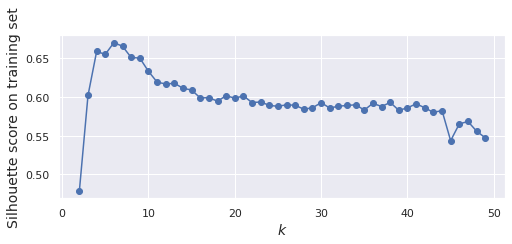

In [777]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

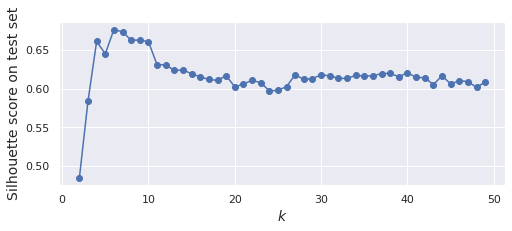

In [778]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

## Reduce and visualize

In [779]:
nca = NeighborhoodComponentsAnalysis(n_components=2, random_state=42)
X_transformed = nca.fit_transform(df_train, pd.cut(rfm_scores_train, bins=range(1,10), right=True).astype(str).tolist())
X_test_transformed = nca.transform(df_test)

Text(0, 0.5, 'Axe 2')

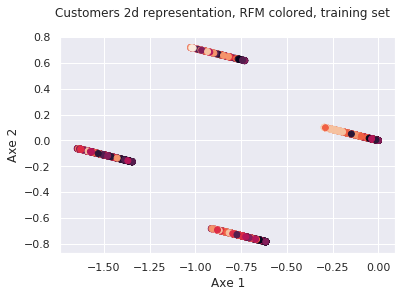

In [780]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, RFM colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=rfm_scores_train_colors)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

In [781]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_transformed)
                for k in range(1, 50)]

In [782]:
labels_test_per_k = [model.predict(X_test_transformed) for model in kmeans_per_k[1:]]

In [783]:
silhouette_scores = [silhouette_score(X_transformed, model.labels_)
                     for model in kmeans_per_k[1:]]

In [784]:
silhouette_scores_test = [silhouette_score(X_test_transformed, labels_test) for labels_test in labels_test_per_k]

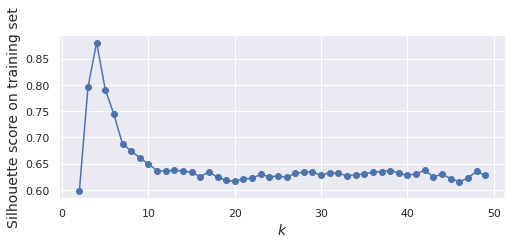

In [785]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

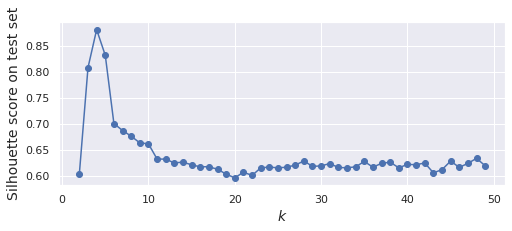

In [786]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

# Model with 'TotalPricePerMonth', 'TotalQuantityPerMonth', 'Recency' then KMeans then 3D visualisation

In [787]:
importlib.reload(sys.modules['functions'])
from functions import *

In [788]:
df_train = df_train_ori
df_test = df_test_ori

In [789]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    #('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('features_selector', FeaturesSelector(features_toselect=['TotalPricePerMonth', 'TotalQuantityPerMonth', 'Recency'])),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth', 'TotalQuantityPerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    #('minmaxscaler', MinMaxScalerMultiple(features_toscale=['RfmScore'])),
    #('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
    #                                                    algorithm_to_use='NCA', n_dim=3, labels_featurename='RfmScore')),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [790]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

In [791]:
#rfm_scores_train = df_train['RfmScore']  # Got from above
#rfm_scores_test = df_test['RfmScore']

In [792]:
unique_rfm_scores = np.sort(rfm_scores_train.unique())
unique_rfm_scores_test = np.sort(rfm_scores_test.unique())

In [793]:
rfm_dict_colors = {}
cnt = 0

for unique_rfm_score in unique_rfm_scores:
    rfm_dict_colors[unique_rfm_score] = cnt
    cnt += 1

rfm_dict_colors_test = {}
cnt = 0

for unique_rfm_score in unique_rfm_scores_test:
    rfm_dict_colors_test[unique_rfm_score] = cnt
    cnt += 1    

In [794]:
rfm_scores_train_colors = rfm_scores_train.apply(lambda x : rfm_dict_colors[x])
rfm_scores_test_colors = rfm_scores_test.apply(lambda x : rfm_dict_colors_test[x])

In [795]:
rfm_scores_train_colors

CustomerID
12346    2
12347    3
12348    4
12349    0
12350    8
        ..
18280    8
18281    7
18282    7
18283    5
18287    1
Name: RfmScore, Length: 4332, dtype: int64

In [796]:
rfm_scores_test_colors

CustomerID
12347    4
12348    8
12349    0
12350    8
12352    6
        ..
18276    5
18280    8
18282    4
18283    5
18287    2
Name: RfmScore, Length: 3771, dtype: int64

In [797]:
rfm_scores_train

CustomerID
12346    0.222222
12347    0.333333
12348    0.444444
12349    0.000000
12350    0.888889
           ...   
18280    0.888889
18281    0.777778
18282    0.777778
18283    0.555556
18287    0.111111
Name: RfmScore, Length: 4332, dtype: float64

In [798]:
df_train

Recency  TotalPricePerMonth  TotalQuantityPerMonth
CustomerID                                                     
12346       0.859762            0.877446               0.915344
12347       0.981702            0.572415               0.536506
12348       0.954933            0.474029               0.543549
12349       0.000000            0.707529               0.657517
12350       0.815269            0.330609               0.299590
...              ...                 ...                    ...
18280       0.719735            0.286691               0.171885
18281       0.436604            0.265155               0.233494
18282       0.278725            0.370964               0.319077
18283       0.894261            0.505393               0.484163
18287       0.497902            0.547572               0.553078

[4332 rows x 3 columns]

In [799]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4332 entries, 12346 to 18287
Data columns (total 3 columns):
Recency                  4332 non-null float64
TotalPricePerMonth       4332 non-null float64
TotalQuantityPerMonth    4332 non-null float64
dtypes: float64(3)
memory usage: 135.4+ KB


In [800]:
'''
df_train_rfmscore_distances = pairwise_distances(df_train['RfmScore'].to_numpy().reshape(-1, 1))
df_test_rfmscore_distances = pairwise_distances(df_test['RfmScore'].to_numpy().reshape(-1, 1))
'''

"\ndf_train_rfmscore_distances = pairwise_distances(df_train['RfmScore'].to_numpy().reshape(-1, 1))\ndf_test_rfmscore_distances = pairwise_distances(df_test['RfmScore'].to_numpy().reshape(-1, 1))\n"

In [801]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df_train)
                for k in range(1, 50)]

In [802]:
labels_test_per_k = [model.predict(df_test) for model in kmeans_per_k[1:]]

In [803]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in kmeans_per_k[1:]]

In [804]:
silhouette_scores_test = [silhouette_score(df_test, labels_test) for labels_test in labels_test_per_k]

In [805]:
# Model corresponding to max silhouette score. We add +1 because "for model in kmeans_per_k[1:] above has suppressed one indice"
# kmeans_per_k[silhouette_scores.index(max(silhouette_scores)) + 1].labels_

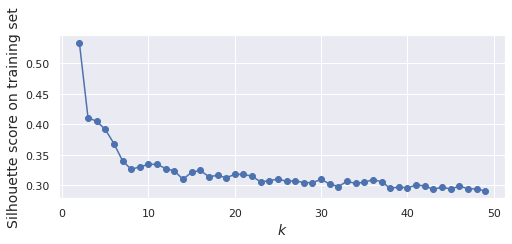

In [806]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

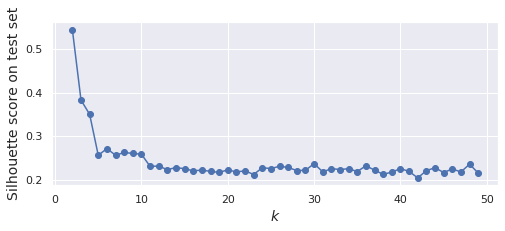

In [807]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

## Visualize

In [808]:
df_train

Recency  TotalPricePerMonth  TotalQuantityPerMonth
CustomerID                                                     
12346       0.859762            0.877446               0.915344
12347       0.981702            0.572415               0.536506
12348       0.954933            0.474029               0.543549
12349       0.000000            0.707529               0.657517
12350       0.815269            0.330609               0.299590
...              ...                 ...                    ...
18280       0.719735            0.286691               0.171885
18281       0.436604            0.265155               0.233494
18282       0.278725            0.370964               0.319077
18283       0.894261            0.505393               0.484163
18287       0.497902            0.547572               0.553078

[4332 rows x 3 columns]

In [809]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter3d(x = df_train.loc[:,'Recency'], y = df_train.loc[:,'TotalPricePerMonth'], z = df_train.loc[:,'TotalQuantityPerMonth'],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=rfm_scores_train_colors),
                    #text = rfm_scores_train,
                    #text = [('Bought top value product' if (boughttopvalueproduct == 1) else 'dit NOT buy top value product') for boughttopvalueproduct in df_train['BoughtTopValueProduct']],
                    text = list(map(str, zip(
                                              '0: ' + df_train['Recency'].astype(str),\
                                              '1: ' + df_train['TotalPricePerMonth'].astype(str),\
                                              '2: ' + df_train['TotalQuantityPerMonth'].astype(str),\
                                            ))\
                                        )
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_NCA_3RFMfeats_color_RFM.html') 

'clusters_plot_clients_NCA_3RFMfeats_color_RFM.html'

In [810]:
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

py.offline.init_notebook_mode(connected=True)


trace_1 = go.Scatter3d(x = df_train.loc[:,'Recency'], y = df_train.loc[:,'TotalPricePerMonth'], z = df_train.loc[:,'TotalQuantityPerMonth'],
                    name = 'Clients',
                    mode = 'markers',
                    marker=dict(color=kmeans_per_k[silhouette_scores.index(max(silhouette_scores)) + 1].labels_),
                    #text = rfm_scores_train,
                    #text = [('Bought top value product' if (boughttopvalueproduct == 1) else 'dit NOT buy top value product') for boughttopvalueproduct in df_train['BoughtTopValueProduct']],
                    text = list(map(str, zip(
                                              '0: ' + df_train['Recency'].astype(str),\
                                              '1: ' + df_train['TotalPricePerMonth'].astype(str),\
                                              '2: ' + df_train['TotalQuantityPerMonth'].astype(str),\
                                            ))\
                                        )
                    )


layout = go.Layout(title = 'Représentation des clients en 2 dimensions',
                   hovermode = 'closest',
)

fig = go.Figure(data = [trace_1], layout = layout)

#py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

py.offline.plot(fig, filename='clusters_plot_clients_NCA_3RFMfeats_color_clusterlabels.html') 

'clusters_plot_clients_NCA_3RFMfeats_color_clusterlabels.html'

Text(0, 0.5, 'Axe 2')

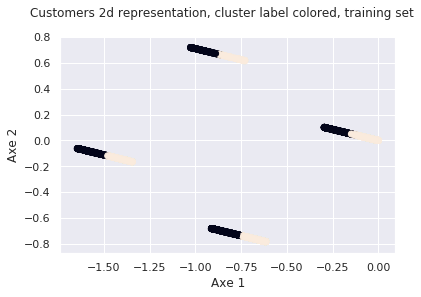

In [811]:
fig = plt.figure()
fig.suptitle('Customers 2d representation, cluster label colored, training set')

ax = plt.gca()
#plt.hist(df_nocancel['TotalPrice'], bins=50, range=(0,100))
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=kmeans_per_k[silhouette_scores.index(max(silhouette_scores)) + 1].labels_)
#ax.set_xlim([0,500])
plt.xlabel('Axe 1')
plt.ylabel("Axe 2")

#plt.yscale('log')

In [812]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_transformed)
                for k in range(1, 50)]

In [813]:
labels_test_per_k = [model.predict(X_test_transformed) for model in kmeans_per_k[1:]]

In [814]:
silhouette_scores = [silhouette_score(X_transformed, model.labels_)
                     for model in kmeans_per_k[1:]]

In [815]:
silhouette_scores_test = [silhouette_score(X_test_transformed, labels_test) for labels_test in labels_test_per_k]

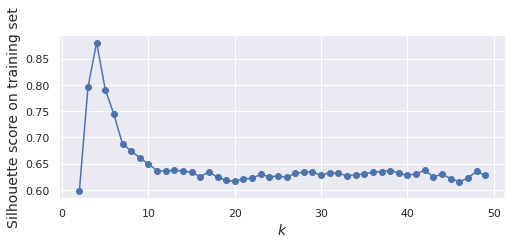

In [816]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

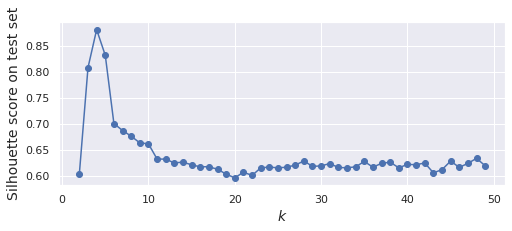

In [817]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

# Correlations

In [819]:
importlib.reload(sys.modules['functions'])
from functions import *

In [820]:
df_train = df_train_ori
df_test = df_test_ori

In [821]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'TotalPricePerMonth', 'Recency', 'TotalQuantityPerMonth', 'RfmScore', 'BoughtTopValueProduct', 'HasEverCancelled'])),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth', 'TotalQuantityPerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    ('minmaxscaler', MinMaxScalerMultiple(features_toscale=['TotalPricePerMonth', 'Recency', 'TotalQuantityPerMonth', 'RfmScore'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='NCA', n_dim=3, labels_featurename='RfmScore')),
    #('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [822]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

/home/francois/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



In [823]:
corr_matrix = df_train.corr()

In [824]:
corr_matrix

Recency  TotalQuantityPerMonth  HasEverCancelled  \
Recency                1.000000              -0.220202          0.271188   
TotalQuantityPerMonth -0.220202               1.000000          0.275306   
HasEverCancelled       0.271188               0.275306          1.000000   
RfmScore               0.606397              -0.832953         -0.125938   
BoughtTopValueProduct  0.171966               0.247532          0.207875   
TotalPricePerMonth    -0.206441               0.924135          0.310096   
0                      0.049608              -0.618341         -0.270481   
1                     -0.382837              -0.447438         -0.386542   
2                      0.280493               0.342720          0.254350   

                       RfmScore  BoughtTopValueProduct  TotalPricePerMonth  \
Recency                0.606397               0.171966           -0.206441   
TotalQuantityPerMonth -0.832953               0.247532            0.924135   
HasEverCancelled      -0.125938               0.207875            0.310096   
RfmScore               1.000000              -0.147869           -0.827117   
BoughtTopValueProduct -0.147869               1.000000            0.321118   
TotalPricePerMonth    -0.827117               0.321118            1.000000   
0                      0.541648              -0.313766           -0.610150   
1                      0.215024              -0.430989           -0.474358   
2                     -0.151298               0.371859            0.366014   

                              0         1         2  
Recency                0.049608 -0.382837  0.280493  
TotalQuantityPerMonth -0.618341 -0.447438  0.342720  
HasEverCancelled      -0.270481 -0.386542  0.254350  
RfmScore               0.541648  0.215024 -0.151298  
BoughtTopValueProduct -0.313766 -0.430989  0.371859  
TotalPricePerMonth    -0.610150 -0.474358  0.366014  
0                      1.000000  0.553008 -0.391872  
1                      0.553008  1.000000 -0.617559  
2                     -0.391872 -0.617559  1.000000

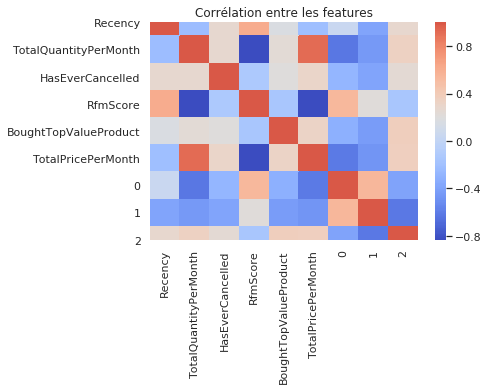

In [825]:
plt.title('Corrélation entre les features')
sns.heatmap(corr_matrix, 
        xticklabels=corr_matrix.columns,
        yticklabels=corr_matrix.columns, cmap='coolwarm' ,center=0.20)

In [826]:
'''
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols("BMI ~ 0 + 1 + 2", data=df_train).fit()
#print model.params
#print model.summary()
'''

'\nimport statsmodels.api as sm\nfrom statsmodels.formula.api import ols\n\nmodel = ols("BMI ~ 0 + 1 + 2", data=df_train).fit()\n#print model.params\n#print model.summary()\n'

# Generate bow colors

In [827]:
importlib.reload(sys.modules['functions'])
from functions import *

In [828]:
df_train = df_train_ori
df_test = df_test_ori

In [829]:
preparation_pipeline = Pipeline([
    #('features_selector', FeaturesSelector(features_toselect=MODEL_FEATURES)),
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'RfmScore'])),
    #('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth', 'TotalQuantityPerMonth'])),
    
    
    # Faire la réduction dimensionnelle à part pour les bag of words et pour les autres features
   
    #('minmaxscaler', MinMaxScalerMultiple(features_toscale=['RfmScore'])),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                        algorithm_to_use='NCA', n_dim=1, labels_featurename='RfmScore')),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])

In [830]:
df_train = preparation_pipeline.fit_transform(df_train)
df_test = preparation_pipeline.transform(df_test)

/home/francois/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



In [831]:
df_train.loc[:, 0].to_numpy()

array([0.33538075, 0.619129  , 0.44806522, ..., 0.36293558, 0.452482  ,
       0.64851582])

In [832]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df_train.loc[:, 0].to_numpy().reshape(-1,1))
                for k in range(1, 50)]

In [833]:
labels_test_per_k = [model.predict(df_test.loc[:, 0].to_numpy().reshape(-1,1)) for model in kmeans_per_k[1:]]

In [834]:
silhouette_scores = [silhouette_score(df_train.loc[:, 0].to_numpy().reshape(-1,1), model.labels_)
                     for model in kmeans_per_k[1:]]

In [835]:
silhouette_scores_test = [silhouette_score(df_test.loc[:, 0].to_numpy().reshape(-1,1), labels_test) for labels_test in labels_test_per_k]

In [836]:
# Model corresponding to max silhouette score. We add +1 because "for model in kmeans_per_k[1:] above has suppressed one indice"
# kmeans_per_k[silhouette_scores.index(max(silhouette_scores)) + 1].labels_

In [837]:
entropy_mean_score_per_k_train = []

for model in kmeans_per_k[1:]:
    unique_labels = np.unique(model.labels_)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(df_train['RfmScore'][model.labels_ == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_train.append(entropy_sum)

    
entropy_mean_score_per_k_test = []

for labels_test in labels_test_per_k:
    unique_labels = np.unique(labels_test)
    
    entropy_sum = 0
    for unique_label in unique_labels:
        entropy_sum += entropy(df_test['RfmScore'][labels_test == unique_label].to_numpy())
        
    entropy_sum = entropy_sum / len(unique_labels)
    
    entropy_mean_score_per_k_test.append(entropy_sum)    
    

/home/francois/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2614: RuntimeWarning:

invalid value encountered in true_divide



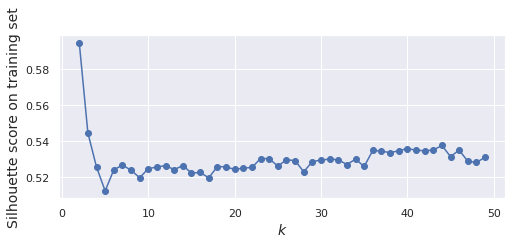

In [838]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

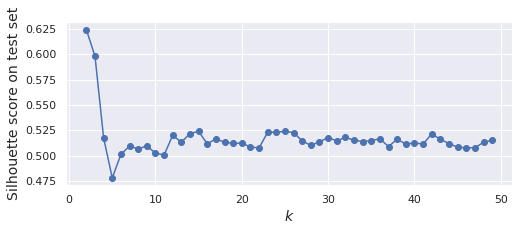

In [839]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [840]:
bow_labels_train = kmeans_per_k[10].labels_

In [841]:
bow_labels_test = kmeans_per_k[10].predict(df_test.loc[:, 0].to_numpy().reshape(-1,1))

# Pipeline with clustering, and GridSearch to select the best model

A GridSearch using pipeline is implemented separately, in .py files  
To run the gridsearch, open a python3 console and :

1/ Launch a python3 console  
2/ Run PJ5_GridSearch_prerequisites.py : exec(open('PJ5_GridSearch_prerequisites.py').read())  
3/ Run PJ5_GridSearch1.py : exec(open('PJ5_GridSearch1.py').read())  

Before 3, you can edit source code of PJ5_GridSearch1.py, and uncomment the GridSearch code you want to run.

# Visualize best models found via GridSearch
Generate pickle files with PJ5_GridSearch1.py before running this part  (see §above : Pipeline with clustering, and GridSearch to select the best model) 

In [46]:
from functions import *
importlib.reload(sys.modules['functions'])
from functions import *

In [47]:
df_train = df_train_ori
df_test = df_test_ori

## Agregate to client level to get text labels for visualisation, and interprete model with surrogate Decision Tree

In [48]:
#model_agregate = AgregateToClientLevel(top_value_products, compute_rfm=True)
model_agregate = Pipeline([
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                                algorithm_to_use='ISOMAP', n_dim=3)),
])

In [49]:
model_agregate.fit(df_train)

Pipeline(memory=None,
         steps=[('bow_encoder', BowEncoder(min_df=0.001)),
                ('agregate_to_client_level',
                 AgregateToClientLevel(compute_rfm=True,
                                       stockcodes_top_value_products=Index(['23843', '22423', '85123A', '23166', '85099B', '47566', '84879',
       '23084', '79321', '21137', '22386', '22086', '23203', '23298', '22197',
       '22720', '82484', '22960', '23284', '22470'],
      dtype='object', name='StockCode'))),
                ('dimensionality_reductor',
                 DimensionalityReductor(algorithm_to_use='ISOMAP',
                                        features_totransform=['DescriptionNormalized'],
                                        labels_featurename=None, n_dim=3,
                                        n_neighbors=10))],
         verbose=False)

In [50]:
df_clients_train_agreg = model_agregate.transform(df_train)

In [51]:
df_clients_test_agreg = model_agregate.transform(df_test)

In [52]:
df_clients_test_agreg

TotalPricePerMonth  HasEverCancelled    Recency  \
CustomerID                                                    
12347                29.347537                 0  12.054845   
12348                 1.952009                 0  10.450774   
12349               165.360000                 0   1.000000   
12350                 1.473382                 0  10.180656   
12352                 7.053670                 1   9.725434   
...                        ...               ...        ...   
18276                 8.831384                 0   1.415407   
18280                 2.603004                 0   9.104864   
18282                 5.040000                 0   1.000000   
18283                18.253543                 0  11.070179   
18287                23.121560                 0   6.606821   

            TotalQuantityPerMonth  BoughtTopValueProduct  RfmScore         0  \
CustomerID                                                                     
12347                   20.406733                      0         7 -2.617863   
12348                    2.296481                      0        11  0.407662   
12349                   43.000000                      1         3 -1.462711   
12350                    1.178706                      0        11  0.231203   
12352                    3.701634                      0         9 -1.336484   
...                           ...                    ...       ...       ...   
18276                    1.413021                      0         8 -0.001162   
18280                    0.329494                      1        11 -0.047736   
18282                   12.000000                      0         7  0.407662   
18283                   11.652928                      1         8 -0.701196   
18287                   24.822832                      0         5 -2.968481   

                    1         2  
CustomerID                       
12347        3.372619  0.287828  
12348        0.601199  0.889536  
12349        0.529934  3.456168  
12350        0.565126  0.877802  
12352       -0.298022  0.287928  
...               ...       ...  
18276        0.618932  0.947075  
18280        0.816117  0.849002  
18282        0.601199  0.889536  
18283       11.698681 -7.078159  
18287       -0.415432  0.643470  

[3771 rows x 9 columns]

In [53]:
df_clients_test_agreg.shape

(3771, 9)

## Loop on top 6 models

In [54]:
df_train = df_train_ori
df_test = df_test_ori

In [55]:
models = [
    Pipeline([
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('features_selector', FeaturesSelector(features_toselect=['BoughtTopValueProduct', 'HasEverCancelled', 'RfmScore'])),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
    ('clusterer', Clusterer(n_clusters=4, algorithm_to_use='WARD'))
    ]),
    
    Pipeline([
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('features_selector', FeaturesSelector(features_toselect=['BoughtTopValueProduct', 'HasEverCancelled', 'TotalPricePerMonth', 'TotalQuantityPerMonth', 'Recency'])),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth', 'TotalQuantityPerMonth'])),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
    ('clusterer', Clusterer(n_clusters=8, algorithm_to_use='KMEANS'))
    ]),
        
    Pipeline([
        ('bow_encoder', BowEncoder()),
        ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
        ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'BoughtTopValueProduct', 'HasEverCancelled', 'RfmScore'])),

        ('minmaxscaler', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
        ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                                algorithm_to_use='NCA', n_dim=3, labels_featurename=None)),
        ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
        ('clusterer', Clusterer(n_clusters=4, algorithm_to_use='WARD'))
        ]),

    Pipeline([
        ('bow_encoder', BowEncoder()),
        ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
        ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'BoughtTopValueProduct', 'HasEverCancelled', 'TotalPricePerMonth', 'TotalQuantityPerMonth', 'Recency'])),
        ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth', 'TotalQuantityPerMonth'])),
        ('minmaxscaler', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
        ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                                algorithm_to_use='ISOMAP', n_dim=3)),
        ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
        ('clusterer', Clusterer(n_clusters=6, algorithm_to_use='KMEANS'))
        ]),
    
    Pipeline([
        ('bow_encoder', BowEncoder()),
        ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
        ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'TotalPricePerMonth', 'TotalQuantityPerMonth', 'Recency'])),
        ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth', 'TotalQuantityPerMonth'])),
        ('minmaxscaler', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
        ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                                algorithm_to_use='ISOMAP', n_dim=3)),
        ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
        ('clusterer', Clusterer(n_clusters=6, algorithm_to_use='KMEANS'))
        ]),

    Pipeline([
        ('bow_encoder', BowEncoder()),
        ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
        ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'RfmScore'])),

        ('minmaxscaler', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
        ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                                algorithm_to_use='NCA', n_dim=3, labels_featurename=None)),
        ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
        ('clusterer', Clusterer(n_clusters=4, algorithm_to_use='KMEANS'))
        ]),

]


models_before_clustering = [
    Pipeline([
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('features_selector', FeaturesSelector(features_toselect=['BoughtTopValueProduct', 'HasEverCancelled', 'RfmScore'])),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
    ]),
    
    Pipeline([
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('features_selector', FeaturesSelector(features_toselect=['BoughtTopValueProduct', 'HasEverCancelled', 'TotalPricePerMonth', 'TotalQuantityPerMonth', 'Recency'])),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth', 'TotalQuantityPerMonth'])),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
    ]),
        
    Pipeline([
        ('bow_encoder', BowEncoder()),
        ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
        ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'BoughtTopValueProduct', 'HasEverCancelled', 'RfmScore'])),

        ('minmaxscaler', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
        ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                                algorithm_to_use='NCA', n_dim=3, labels_featurename=None)),
        ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
        ]),

    Pipeline([
        ('bow_encoder', BowEncoder()),
        ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
        ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'BoughtTopValueProduct', 'HasEverCancelled', 'TotalPricePerMonth', 'TotalQuantityPerMonth', 'Recency'])),
        ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth', 'TotalQuantityPerMonth'])),
        ('minmaxscaler', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
        ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                                algorithm_to_use='ISOMAP', n_dim=3)),
        ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
        ]),
    
    Pipeline([
        ('bow_encoder', BowEncoder()),
        ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
        ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'TotalPricePerMonth', 'TotalQuantityPerMonth', 'Recency'])),
        ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth', 'TotalQuantityPerMonth'])),
        ('minmaxscaler', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
        ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                                algorithm_to_use='ISOMAP', n_dim=3)),
        ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
        ]),

    Pipeline([
        ('bow_encoder', BowEncoder()),
        ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
        ('features_selector', FeaturesSelector(features_toselect=['DescriptionNormalized', 'RfmScore'])),

        ('minmaxscaler', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
        ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                                algorithm_to_use='NCA', n_dim=3, labels_featurename=None)),
        ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
        ]),

]

models_clustering = [
        Clusterer(n_clusters=4, algorithm_to_use='WARD'),
        Clusterer(n_clusters=8, algorithm_to_use='KMEANS'),
        Clusterer(n_clusters=4, algorithm_to_use='WARD'),
        Clusterer(n_clusters=6, algorithm_to_use='KMEANS'),
        Clusterer(n_clusters=6, algorithm_to_use='KMEANS'),
        Clusterer(n_clusters=4, algorithm_to_use='KMEANS'),
]


In [56]:
# Below code can be uncommented to run only one model with code in next cell
'''
models = [
    Pipeline([
        ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
        ('features_selector', FeaturesSelector(features_toselect=['TotalPricePerMonth', 'TotalQuantityPerMonth', 'Recency'])),
        ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth', 'TotalQuantityPerMonth'])),
        ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
        ('clusterer', Clusterer(n_clusters=4, algorithm_to_use='KMEANS'))
        ]),

]


models_before_clustering = [
    Pipeline([
        ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
        ('features_selector', FeaturesSelector(features_toselect=['TotalPricePerMonth', 'TotalQuantityPerMonth', 'Recency'])),
        ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth', 'TotalQuantityPerMonth'])),
        ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
        ]),
    ]

models_clustering = [
        Clusterer(n_clusters=4, algorithm_to_use='KMEANS'),
]
'''

"\nmodels = [\n    Pipeline([\n        ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),\n        ('features_selector', FeaturesSelector(features_toselect=['TotalPricePerMonth', 'TotalQuantityPerMonth', 'Recency'])),\n        ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth', 'TotalQuantityPerMonth'])),\n        ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),\n        ('clusterer', Clusterer(n_clusters=4, algorithm_to_use='KMEANS'))\n        ]),\n\n]\n\n\nmodels_before_clustering = [\n    Pipeline([\n        ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),\n        ('features_selector', FeaturesSelector(features_toselect=['TotalPricePerMonth', 'TotalQuantityPerMonth', 'Recency'])),\n        ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth', 'TotalQuantityPerMonth'])),\n        ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='

In [57]:
model_number = 0

for model_prep, model_clusterer in zip(models_before_clustering, models_clustering):
    model_number += 1
    df_train = df_train_ori
    df_test = df_test_ori    
    
    print('Model ' + str(model_number) + ':\n' + str(model_prep) + '\n' + str(model_clusterer))
    
    print('Running preparation model')
    
    if ((model_number == 3) or (model_number == 6)): # For NCA we must pass a dimensionality reductor label
        model_prep.fit(df_train, dimensionality_reductor__labels=df_clients_train_agreg['RfmScore'])
        
    else:
        model_prep.fit(df_train)
        
    df_clients_train = model_prep.transform(df_train)
    df_clients_test = model_prep.transform(df_test)
        
    print('Running clusterer model : calculating cluster labels and test set score')
    #print('1')
    model_clusterer.fit(df_clients_train)
    
    #print('2')
    df_predictions_test = model_clusterer.predict(df_clients_test)
    
    #print('3')
    score_test = model_clusterer.score(df_clients_test)
    print(f'> Score on test set : {score_test}')
    
    print('Client representation')
    reductor = DimensionalityReductor(algorithm_to_use='TSNE', n_dim=2, features_totransform='ALL')
    df_clients_test_reduced = reductor.fit_transform(df_clients_test)


    py.offline.init_notebook_mode(connected=True)

    trace_1 = go.Scatter(x = df_clients_test_reduced.loc[:,0], y = df_clients_test_reduced.loc[:,1],
                        name = 'Clients',
                        mode = 'markers',
                        marker=dict(color=df_predictions_test),
                        #text = rfm_scores_train,
                        #text = [('Bought top value product' if (boughttopvalueproduct == 1) else 'dit NOT buy top value product') for boughttopvalueproduct in df_train['BoughtTopValueProduct']],
                        text = list(map(str, zip('RFM: ' + df_clients_test_agreg['RfmScore'].astype(str),\
                                                 'BoughtTopValueProduct: ' + df_clients_test_agreg['BoughtTopValueProduct'].astype(str),\
                                                  'HasEverCancelled: '  + df_clients_test_agreg['HasEverCancelled'].astype(str),\
                                                ))\
                                            )
                        )


    layout = go.Layout(title = 'Model ' + str(model_number) + ' : client representation, colored by cluster',
                       hovermode = 'closest',
    )

    fig = go.Figure(data = [trace_1], layout = layout)

    #py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

    py.offline.plot(fig, filename='clusters_model' + str(model_number) + '.html') 
    
    print('Interpreted clusters with decision tree:')
    dt = DecisionTreeClassifier(max_depth=3)
    dt.fit(df_clients_test_agreg, df_predictions_test)
    
    for col, val in sorted(zip(df_clients_test_agreg.columns, dt.feature_importances_), key=lambda col_val: col_val[1], reverse=True):
        print(f'{col:10} {val:10.3f}')
        
    print('Draw decision tree')
    from io import StringIO
    import pydotplus
    dot_data = StringIO()
    tree.export_graphviz(
        dt,
        out_file=dot_data,
        feature_names=df_clients_test_agreg.columns,
        #class_names=["0", "1"],
        class_names=df_predictions_test.astype(str).unique(),
        max_depth=3,
        filled=True,
    )
    g = pydotplus.graph_from_dot_data(
        dot_data.getvalue()
    )
    g.write_png('graph_model' + str(model_number) + '_logscale.png')
    #g.write_png('graph_model_rfm_basic_logscale.png') # Uncomment to run only 1 model (and also uncomment previous cell)

    

Model 1:
Pipeline(memory=None,
         steps=[('agregate_to_client_level',
                 AgregateToClientLevel(compute_rfm=True,
                                       stockcodes_top_value_products=Index(['23843', '22423', '85123A', '23166', '85099B', '47566', '84879',
       '23084', '79321', '21137', '22386', '22086', '23203', '23298', '22197',
       '22720', '82484', '22960', '23284', '22470'],
      dtype='object', name='StockCode'))),
                ('features_selector',
                 FeaturesSelector(features_toselect=['BoughtTopValueProduct',
                                                     'HasEverCancelled',
                                                     'RfmScore'])),
                ('minmaxscaler_final',
                 MinMaxScalerMultiple(features_toscale='ALL_FEATURES'))],
         verbose=False)
Clusterer(algorithm_to_use='WARD', n_clusters=4)
Running preparation model
Running clusterer model : calculating cluster labels and test set score
> Score on

Interpreted clusters with decision tree:
BoughtTopValueProduct      0.588
HasEverCancelled      0.412
TotalPricePerMonth      0.000
Recency         0.000
TotalQuantityPerMonth      0.000
RfmScore        0.000
         0      0.000
         1      0.000
         2      0.000
Draw decision tree
Model 2:
Pipeline(memory=None,
         steps=[('agregate_to_client_level',
                 AgregateToClientLevel(compute_rfm=True,
                                       stockcodes_top_value_products=Index(['23843', '22423', '85123A', '23166', '85099B', '47566', '84879',
       '23084', '79321', '21137', '22386', '22086', '23203', '23298', '22197',
       '22720', '82484', '22960', '23284', '22470'],
      dtype='object', name='StockCode'))),
                ('features_selector',
                 FeaturesSelector(features_toselect=['BoughtTopValueProduct',
                                                     'HasEverCancelled',
                                                     'TotalPricePerM

Interpreted clusters with decision tree:
BoughtTopValueProduct      0.377
Recency         0.349
HasEverCancelled      0.274
TotalPricePerMonth      0.000
TotalQuantityPerMonth      0.000
RfmScore        0.000
         0      0.000
         1      0.000
         2      0.000
Draw decision tree
Model 3:
Pipeline(memory=None,
         steps=[('bow_encoder', BowEncoder(min_df=0.001)),
                ('agregate_to_client_level',
                 AgregateToClientLevel(compute_rfm=True,
                                       stockcodes_top_value_products=Index(['23843', '22423', '85123A', '23166', '85099B', '47566', '84879',
       '23084', '79321', '21137', '22386', '22086', '23203', '23298', '22197',
       '22720', '82484', '22960', '23284', '22470'],
      dtype='object'...
                                                     'HasEverCancelled',
                                                     'RfmScore'])),
                ('minmaxscaler',
                 MinMaxScalerMultiple(featu

/home/francois/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Running clusterer model : calculating cluster labels and test set score
> Score on test set : 0.6478952911143654
Client representation
No fit for TSNE


Interpreted clusters with decision tree:
BoughtTopValueProduct      0.588
HasEverCancelled      0.412
TotalPricePerMonth      0.000
Recency         0.000
TotalQuantityPerMonth      0.000
RfmScore        0.000
         0      0.000
         1      0.000
         2      0.000
Draw decision tree
Model 4:
Pipeline(memory=None,
         steps=[('bow_encoder', BowEncoder(min_df=0.001)),
                ('agregate_to_client_level',
                 AgregateToClientLevel(compute_rfm=True,
                                       stockcodes_top_value_products=Index(['23843', '22423', '85123A', '23166', '85099B', '47566', '84879',
       '23084', '79321', '21137', '22386', '22086', '23203', '23298', '22197',
       '22720', '82484', '22960', '23284', '22470'],
      dtype='object'...
                ('scaler', LogScalerMultiple(features_toscale=None)),
                ('minmaxscaler',
                 MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
                ('dimensionality_reductor

Interpreted clusters with decision tree:
BoughtTopValueProduct      0.405
Recency         0.302
HasEverCancelled      0.293
TotalPricePerMonth      0.000
TotalQuantityPerMonth      0.000
RfmScore        0.000
         0      0.000
         1      0.000
         2      0.000
Draw decision tree
Model 5:
Pipeline(memory=None,
         steps=[('bow_encoder', BowEncoder(min_df=0.001)),
                ('agregate_to_client_level',
                 AgregateToClientLevel(compute_rfm=True,
                                       stockcodes_top_value_products=Index(['23843', '22423', '85123A', '23166', '85099B', '47566', '84879',
       '23084', '79321', '21137', '22386', '22086', '23203', '23298', '22197',
       '22720', '82484', '22960', '23284', '22470'],
      dtype='object'...
                ('scaler', LogScalerMultiple(features_toscale=None)),
                ('minmaxscaler',
                 MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
                ('dimensionality_reductor

Interpreted clusters with decision tree:
Recency         0.762
RfmScore        0.129
TotalQuantityPerMonth      0.109
TotalPricePerMonth      0.000
HasEverCancelled      0.000
BoughtTopValueProduct      0.000
         0      0.000
         1      0.000
         2      0.000
Draw decision tree
Model 6:
Pipeline(memory=None,
         steps=[('bow_encoder', BowEncoder(min_df=0.001)),
                ('agregate_to_client_level',
                 AgregateToClientLevel(compute_rfm=True,
                                       stockcodes_top_value_products=Index(['23843', '22423', '85123A', '23166', '85099B', '47566', '84879',
       '23084', '79321', '21137', '22386', '22086', '23203', '23298', '22197',
       '22720', '82484', '22960', '23284', '22470'],
      dtype='object'...
                 FeaturesSelector(features_toselect=['DescriptionNormalized',
                                                     'RfmScore'])),
                ('minmaxscaler',
                 MinMaxScalerMultiple(

/home/francois/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



Running clusterer model : calculating cluster labels and test set score
> Score on test set : 0.37133062675519773
Client representation
No fit for TSNE


Interpreted clusters with decision tree:
RfmScore        0.963
         0      0.022
Recency         0.014
         1      0.001
TotalPricePerMonth      0.000
HasEverCancelled      0.000
TotalQuantityPerMonth      0.000
BoughtTopValueProduct      0.000
         2      0.000
Draw decision tree


In [58]:
len(bow_labels_test)

3771

In [901]:
    trace_1 = go.Scatter(x = df_clients_test_reduced.loc[:,0], y = df_clients_test_reduced.loc[:,1],
                        name = 'Clients',
                        mode = 'markers',
                        marker=dict(color=bow_labels_test),
                        #text = rfm_scores_train,
                        #text = [('Bought top value product' if (boughttopvalueproduct == 1) else 'dit NOT buy top value product') for boughttopvalueproduct in df_train['BoughtTopValueProduct']],
                        text = list(map(str, zip('RFM: ' + df_clients_test_agreg['RfmScore'].astype(str),\
                                                 'BoughtTopValueProduct: ' + df_clients_test_agreg['BoughtTopValueProduct'].astype(str),\
                                                  'HasEverCancelled: '  + df_clients_test_agreg['HasEverCancelled'].astype(str),\
                                                ))\
                                            )
                        )


    layout = go.Layout(title = 'Model ' + str(model_number) + ' : client representation, colored by bow',
                       hovermode = 'closest',
    )

    fig = go.Figure(data = [trace_1], layout = layout)

    #py.offline.iplot(fig) # Display in the notebook works with jupyter notebook, but not with jupyter lab

    py.offline.plot(fig, filename='clusters_model' + str(model_number) + '.html') 
    

'clusters_model2.html'

In [853]:
df_predictions_test.astype(str).unique()

array(['0', '3', '4', '5', '1', '2'], dtype=object)

# Export to pickle

## Export sample input file for the UI

In [85]:
df_train_ori[['InvoiceNo','StockCode','Quantity','InvoiceDate','CustomerID','TotalPrice','DescriptionNormalized','InvoiceMonth']].sort_values(by='CustomerID').head(1000).to_csv('UI_input_sample.csv')

## Retrain model

In [63]:
df_train = df_train_ori
df_test = df_test_ori    
    
model_final = Pipeline([
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('features_selector', FeaturesSelector(features_toselect=['BoughtTopValueProduct', 'HasEverCancelled', 'TotalPricePerMonth', 'TotalQuantityPerMonth', 'Recency'])),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth', 'TotalQuantityPerMonth'])),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
    ('clusterer', Clusterer(n_clusters=8, algorithm_to_use='KMEANS'))
    ])


In [64]:
model_final.fit(df_train)

Pipeline(memory=None,
         steps=[('agregate_to_client_level',
                 AgregateToClientLevel(compute_rfm=True,
                                       stockcodes_top_value_products=Index(['23843', '22423', '85123A', '23166', '85099B', '47566', '84879',
       '23084', '79321', '21137', '22386', '22086', '23203', '23298', '22197',
       '22720', '82484', '22960', '23284', '22470'],
      dtype='object', name='StockCode'))),
                ('features_selector',
                 FeaturesSelector(features_toselect=['BoughtTopValueProduct',
                                                     'HasEverCancelled',
                                                     'TotalPricePerMonth',
                                                     'TotalQuantityPerMonth',
                                                     'Recency'])),
                ('scaler', LogScalerMultiple(features_toscale=None)),
                ('minmaxscaler_final',
                 MinMaxScalerMultiple(feat

In [88]:
model_before_clustering_final = Pipeline([
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('features_selector', FeaturesSelector(features_toselect=['BoughtTopValueProduct', 'HasEverCancelled', 'TotalPricePerMonth', 'TotalQuantityPerMonth', 'Recency'])),
    ('scaler', LogScalerMultiple(features_toscale=['TotalPricePerMonth', 'TotalQuantityPerMonth'])),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
    ])

In [89]:
model_before_clustering_final.fit(df_train)

Pipeline(memory=None,
         steps=[('agregate_to_client_level',
                 AgregateToClientLevel(compute_rfm=True,
                                       stockcodes_top_value_products=Index(['23843', '22423', '85123A', '23166', '85099B', '47566', '84879',
       '23084', '79321', '21137', '22386', '22086', '23203', '23298', '22197',
       '22720', '82484', '22960', '23284', '22470'],
      dtype='object', name='StockCode'))),
                ('features_selector',
                 FeaturesSelector(features_toselect=['BoughtTopValueProduct',
                                                     'HasEverCancelled',
                                                     'TotalPricePerMonth',
                                                     'TotalQuantityPerMonth',
                                                     'Recency'])),
                ('scaler', LogScalerMultiple(features_toscale=None)),
                ('minmaxscaler_final',
                 MinMaxScalerMultiple(feat

In [90]:
model_agregate_final = Pipeline([
    ('bow_encoder', BowEncoder()),
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('dimensionality_reductor', DimensionalityReductor(features_totransform=['DescriptionNormalized'], \
                                                                algorithm_to_use='ISOMAP', n_dim=3)),
])

In [78]:
df_test.loc[[4]]

index InvoiceNo StockCode                   Description  Quantity  \
4  238510    566220     23340  VINTAGE CHRISTMAS CAKE FRILL        48   

           InvoiceDate  UnitPrice CustomerID         Country  TotalPrice  \
4  2011-09-09 15:53:00       1.65      15251  United Kingdom        79.2   

          DescriptionNormalized         InvoiceMonth  
4  VINTAGE CHRISTMAS CAKE FRILL  2011-09-01 00:00:00

In [76]:
df_test.columns

Index(['index', 'InvoiceNo', 'StockCode', 'Description', 'Quantity',
       'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country', 'TotalPrice',
       'DescriptionNormalized', 'InvoiceMonth'],
      dtype='object')

In [80]:
model_final.predict(df_test.loc[[4]])

CustomerID
15251    2
Name: 0, dtype: int32

In [91]:
if (SAVE_API_MODEL == True):    
    API_model = {}
    API_model['model'] = model_final
    API_model['model_agregate'] = model_agregate_final
    API_model['model_before_clustering'] = model_before_clustering_final
    
    '''
    API_model = model_final
    '''
    
    with open(API_MODEL_PICKLE_FILE, 'wb') as f:
        pickle.dump(API_model, f, pickle.HIGHEST_PROTOCOL)  

In [854]:
reductor

DimensionalityReductor(algorithm_to_use='TSNE', features_totransform='ALL',
                       labels_featurename=None, n_dim=2, n_neighbors=10)

In [855]:
df_clients_test.dtypes

Recency                  float64
TotalQuantityPerMonth    float64
HasEverCancelled         float64
BoughtTopValueProduct    float64
TotalPricePerMonth       float64
0                        float64
1                        float64
2                        float64
dtype: object

In [856]:
tsne = TSNE(n_components=2, random_state=42)

In [857]:
tsne.fit_transform(df_clients_test.to_numpy())

array([[ 60.26602 ,  -8.618872],
       [ 38.067318, -46.84281 ],
       [ 32.934753,  55.889305],
       ...,
       [ 27.00657 ,  21.081   ],
       [-50.917767,  42.89987 ],
       [-32.012283, -39.428284]], dtype=float32)

In [858]:
filter_cols = [col for col in df_clients_test]

In [859]:
filter_cols

['Recency',
 'TotalQuantityPerMonth',
 'HasEverCancelled',
 'BoughtTopValueProduct',
 'TotalPricePerMonth',
 0,
 1,
 2]

In [860]:
filter_cols.sort(key=lambda v: (isinstance(v, str), v))

In [861]:
df_clients_test_reduced.loc[:,0]

0       57.243401
1       38.522430
2       32.399811
3       32.008774
4       68.032814
          ...    
3766     0.011848
3767   -14.598241
3768    29.476946
3769   -51.900322
3770   -30.944704
Name: 0, Length: 3771, dtype: float32

S'inspirer de : # Model with all features and RFM score (concat) (not individual RFM feats), and NCA (BEST)# 

In [862]:
model_beforecluster = Pipeline([
    ('agregate_to_client_level', AgregateToClientLevel(top_value_products, compute_rfm=True)),
    ('features_selector', FeaturesSelector(features_toselect=['BoughtTopValueProduct', 'HasEverCancelled', 'RfmScore'])),
    ('minmaxscaler_final', MinMaxScalerMultiple(features_toscale='ALL_FEATURES')),
])


In [863]:
model_beforecluster.fit(df_train)

Pipeline(memory=None,
         steps=[('agregate_to_client_level',
                 AgregateToClientLevel(compute_rfm=True,
                                       stockcodes_top_value_products=Index(['23843', '22423', '85123A', '23166', '85099B', '47566', '84879',
       '23084', '79321', '21137', '22386', '22086', '23203', '23298', '22197',
       '22720', '82484', '22960', '23284', '22470'],
      dtype='object', name='StockCode'))),
                ('features_selector',
                 FeaturesSelector(features_toselect=['BoughtTopValueProduct',
                                                     'HasEverCancelled',
                                                     'RfmScore'])),
                ('minmaxscaler_final',
                 MinMaxScalerMultiple(features_toscale='ALL_FEATURES'))],
         verbose=False)

In [864]:
df_test_transformed = model_beforecluster.transform(df_test)

In [865]:
df_test_transformed

BoughtTopValueProduct  HasEverCancelled  RfmScore
CustomerID                                                   
12347                         0.0               0.0  0.444444
12348                         0.0               0.0  0.888889
12349                         1.0               0.0  0.000000
12350                         0.0               0.0  0.888889
12352                         0.0               1.0  0.666667
...                           ...               ...       ...
18276                         0.0               0.0  0.555556
18280                         1.0               0.0  0.888889
18282                         0.0               0.0  0.444444
18283                         1.0               0.0  0.555556
18287                         0.0               0.0  0.222222

[3771 rows x 3 columns]

A FAIRE : renvoyer un dataframe en sorte de predict() du modèle final, indexé avec les identifiants de client

# Annex

## Display some data

In [866]:
df_nocancel = df[df['InvoiceNo'].str.startswith('C') == False]
df_nocancel.reset_index(inplace=True)

df_gbproduct = df_nocancel[['StockCode', 'TotalPrice']].groupby('StockCode').sum()['TotalPrice']

In [867]:
df_nocancel.head(2)

index InvoiceNo StockCode                         Description  Quantity  \
0      0    536365    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   
1      1    536365     71053                 WHITE METAL LANTERN         6   

           InvoiceDate  UnitPrice CustomerID         Country  TotalPrice  \
0  2010-12-01 08:26:00       2.55      17850  United Kingdom       15.30   
1  2010-12-01 08:26:00       3.39      17850  United Kingdom       20.34   

                DescriptionNormalized         InvoiceMonth  
0  WHITE HANGING HEART T-LIGHT HOLDER  2010-12-01 00:00:00  
1                 WHITE METAL LANTERN  2010-12-01 00:00:00

In [868]:
df_nocancel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391328 entries, 0 to 391327
Data columns (total 12 columns):
index                    391328 non-null int64
InvoiceNo                391328 non-null object
StockCode                391328 non-null object
Description              391328 non-null object
Quantity                 391328 non-null int64
InvoiceDate              391328 non-null object
UnitPrice                391328 non-null float64
CustomerID               391328 non-null object
Country                  391328 non-null object
TotalPrice               391328 non-null float64
DescriptionNormalized    391328 non-null object
InvoiceMonth             391328 non-null object
dtypes: float64(2), int64(2), object(8)
memory usage: 35.8+ MB


In [869]:
invoice_dates = pd.to_datetime(df_nocancel["InvoiceDate"], format="%Y-%m-%d ")

In [870]:
invoice_dates = pd.to_datetime(df_nocancel["InvoiceDate"])

In [871]:
np.maximum((pd.to_datetime('2011-12-09 12:50:00') - invoice_dates) / (np.timedelta64(1, "M")), 1)[123456]

6.997862150945377

In [872]:
df_gbcustom_firstorder = df_nocancel[['CustomerID', 'InvoiceDate']].groupby('CustomerID').min()

In [873]:
df_nocancel[['CustomerID', 'InvoiceDate']].groupby('CustomerID').min()['InvoiceDate']

CustomerID
12346    2011-01-18 10:01:00
12347    2010-12-07 14:57:00
12348    2010-12-16 19:09:00
12349    2011-11-21 09:51:00
12350    2011-02-02 16:01:00
                ...         
18280    2011-03-07 09:52:00
18281    2011-06-12 10:53:00
18282    2011-08-05 13:35:00
18283    2011-01-06 14:14:00
18287    2011-05-22 10:39:00
Name: InvoiceDate, Length: 4336, dtype: object

In [874]:
(\
   pd.to_datetime('2011-12-09 12:50:00')\
   - pd.to_datetime(df_nocancel[['CustomerID', 'InvoiceDate']].groupby('CustomerID').min()['InvoiceDate'])
)\
  / (np.timedelta64(1, "M"))

CustomerID
12346    10.681693
12347    12.054845
12348    11.753401
12349     0.595472
12350    10.180656
           ...    
18280     9.104864
18281     5.916549
18282     4.138689
18283    11.070179
18287     6.606821
Name: InvoiceDate, Length: 4336, dtype: float64

In [875]:
# Number of months between first order date and last date of the dataset
series_gbclient_nbmonths = np.maximum(\
(
   (
   pd.to_datetime('2011-12-09 12:50:00')\
   - pd.to_datetime(df_nocancel[['CustomerID', 'InvoiceDate']].groupby('CustomerID').min()['InvoiceDate'])
   )\
    / (np.timedelta64(1, "M"))
), 1)

In [876]:
df_nocancel[['CustomerID', ]]

CustomerID
0           17850
1           17850
2           17850
3           17850
4           17850
...           ...
391323      12680
391324      12680
391325      12680
391326      12680
391327      12680

[391328 rows x 1 columns]

In [877]:
df_gbcustom_firstorder

InvoiceDate
CustomerID                     
12346       2011-01-18 10:01:00
12347       2010-12-07 14:57:00
12348       2010-12-16 19:09:00
12349       2011-11-21 09:51:00
12350       2011-02-02 16:01:00
...                         ...
18280       2011-03-07 09:52:00
18281       2011-06-12 10:53:00
18282       2011-08-05 13:35:00
18283       2011-01-06 14:14:00
18287       2011-05-22 10:39:00

[4336 rows x 1 columns]

In [878]:
df_nocancel[df_nocancel['CustomerID'] == '18281'].sort_values(by='InvoiceDate', ascending=True)

index InvoiceNo StockCode                   Description  Quantity  \
153118  156809    556464     22037           ROBOT BIRTHDAY CARD        12   
153119  156810    556464     22716            CARD CIRCUS PARADE        12   
153120  156811    556464     22028  PENNY FARTHING BIRTHDAY CARD        12   
153121  156812    556464     23007        SPACEBOY BABY GIFT SET         1   
153122  156813    556464     23008      DOLLY GIRL BABY GIFT SET         1   
153123  156814    556464     23209      LUNCH BAG DOILEY PATTERN        10   
153124  156815    556464     22467             GUMBALL COAT RACK         6   

                InvoiceDate  UnitPrice CustomerID         Country  TotalPrice  \
153118  2011-06-12 10:53:00       0.42      18281  United Kingdom        5.04   
153119  2011-06-12 10:53:00       0.42      18281  United Kingdom        5.04   
153120  2011-06-12 10:53:00       0.42      18281  United Kingdom        5.04   
153121  2011-06-12 10:53:00      16.95      18281  United Kingdom       16.95   
153122  2011-06-12 10:53:00      16.95      18281  United Kingdom       16.95   
153123  2011-06-12 10:53:00       1.65      18281  United Kingdom       16.50   
153124  2011-06-12 10:53:00       2.55      18281  United Kingdom       15.30   

               DescriptionNormalized         InvoiceMonth  
153118           ROBOT BIRTHDAY CARD  2011-06-01 00:00:00  
153119            CARD CIRCUS PARADE  2011-06-01 00:00:00  
153120  PENNY FARTHING BIRTHDAY CARD  2011-06-01 00:00:00  
153121        SPACEBOY BABY GIFT SET  2011-06-01 00:00:00  
153122      DOLLY GIRL BABY GIFT SET  2011-06-01 00:00:00  
153123       LUNCH BAG VINTAGE DOILY  2011-06-01 00:00:00  
153124             GUMBALL COAT RACK  2011-06-01 00:00:00

In [879]:
invoice_dates[2000:2010]

2000   2010-12-02 09:43:00
2001   2010-12-02 09:43:00
2002   2010-12-02 09:43:00
2003   2010-12-02 09:43:00
2004   2010-12-02 09:43:00
2005   2010-12-02 09:43:00
2006   2010-12-02 09:43:00
2007   2010-12-02 09:43:00
2008   2010-12-02 09:44:00
2009   2010-12-02 09:44:00
Name: InvoiceDate, dtype: datetime64[ns]

In [880]:
df_nocancel.loc[2000:2010,'InvoiceDate']

2000    2010-12-02 09:43:00
2001    2010-12-02 09:43:00
2002    2010-12-02 09:43:00
2003    2010-12-02 09:43:00
2004    2010-12-02 09:43:00
2005    2010-12-02 09:43:00
2006    2010-12-02 09:43:00
2007    2010-12-02 09:43:00
2008    2010-12-02 09:44:00
2009    2010-12-02 09:44:00
2010    2010-12-02 09:44:00
Name: InvoiceDate, dtype: object

In [881]:
df_nocancel.loc[100000:100010,'InvoiceMonth']

100000    2011-04-01 00:00:00
100001    2011-04-01 00:00:00
100002    2011-04-01 00:00:00
100003    2011-04-01 00:00:00
100004    2011-04-01 00:00:00
100005    2011-04-01 00:00:00
100006    2011-04-01 00:00:00
100007    2011-04-01 00:00:00
100008    2011-04-01 00:00:00
100009    2011-04-01 00:00:00
100010    2011-04-01 00:00:00
Name: InvoiceMonth, dtype: object

In [882]:
df[df['InvoiceNo'].str.startswith('C') == True]['CustomerID'].unique()

array(['14527', '15311', '17548', ..., '12985', '15951', '16446'],
      dtype=object)

In [883]:
# Product codes that contain chars instead of numbers
df[df['StockCode'].str.isalpha()]['StockCode'].unique()

array(['D'], dtype=object)

## RFM table

In [884]:
df_train

index InvoiceNo StockCode                         Description  \
0        11503    537781     21377  SMALL CAMPHOR WOOD FIELD  MUSHROOM   
1        40887    541855     21947           SET OF 6 HEART CHOPSTICKS   
2       103799    549646    85031A      ROMANTIC IMAGES SCRAP BOOK SET   
3       372911    578856     23535             WALL ART BICYCLE SAFETY   
4       297823    571747     23396   LE JARDIN BOTANIQUE CUSHION COVER   
...        ...       ...       ...                                 ...   
359915  128343    552843     22692         DOORMAT WELCOME TO OUR HOME   
359916  272049    569401     23356               LOVE HOT WATER BOTTLE   
359917  225276    564554     23280   FOLDING BUTTERFLY MIRROR HOT PINK   
359918  302898    572274     22423            REGENCY CAKESTAND 3 TIER   
359919  153432    555944     23165       LARGE CERAMIC TOP STORAGE JAR   

        Quantity          InvoiceDate  UnitPrice CustomerID         Country  \
0              1  2010-12-08 12:46:00       1.65      17341  United Kingdom   
1              1  2011-01-23 14:59:00       1.25      13742  United Kingdom   
2              6  2011-04-11 11:51:00       1.25      12982  United Kingdom   
3              4  2011-11-27 11:18:00       5.95      17769  United Kingdom   
4              4  2011-10-19 10:59:00       3.75      13849  United Kingdom   
...          ...                  ...        ...        ...             ...   
359915         1  2011-05-11 14:37:00       7.95      14649  United Kingdom   
359916         3  2011-10-04 08:56:00       5.95      15111  United Kingdom   
359917         1  2011-08-25 19:39:00       0.83      17189  United Kingdom   
359918        16  2011-10-21 16:48:00      10.95      14031  United Kingdom   
359919        12  2011-06-08 10:36:00       1.65      16955  United Kingdom   

        TotalPrice               DescriptionNormalized         InvoiceMonth  
0             1.65  SMALL CAMPHOR WOOD FIELD  MUSHROOM  2010-12-01 00:00:00  
1             1.25           SET OF 6 HEART CHOPSTICKS  2011-01-01 00:00:00  
2             7.50      ROMANTIC IMAGES SCRAP BOOK SET  2011-04-01 00:00:00  
3            23.80             WALL ART BICYCLE SAFETY  2011-11-01 00:00:00  
4            15.00   LE JARDIN BOTANIQUE CUSHION COVER  2011-10-01 00:00:00  
...            ...                                 ...                  ...  
359915        7.95         DOORMAT WELCOME TO OUR HOME  2011-05-01 00:00:00  
359916       17.85               LOVE HOT WATER BOTTLE  2011-10-01 00:00:00  
359917        0.83   FOLDING BUTTERFLY MIRROR HOT PINK  2011-08-01 00:00:00  
359918      175.20            REGENCY CAKESTAND 3 TIER  2011-10-01 00:00:00  
359919       19.80       LARGE CERAMIC TOP STORAGE JAR  2011-06-01 00:00:00  

[359920 rows x 12 columns]

quantiles = df_train[['TotalPricePerMonth', 'TotalQuantityPerMonth', 'Recency']].quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [ ]:
quantiles

In [ ]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [ ]:
df_rfmtable = df_train[['TotalPricePerMonth', 'TotalQuantityPerMonth', 'Recency']]

In [ ]:
df_rfmtable

In [ ]:
df_rfmtable.loc[:, 'r_quartile'] = df_rfmtable.loc[:, 'Recency'].apply(RScore, args=('Recency',quantiles,))

In [ ]:
df_rfmtable.loc[:, 'r_quartile'] = df_rfmtable.loc[:, 'Recency'].apply(RScore, args=('Recency',quantiles,))
df_rfmtable.loc[:, 'f_quartile'] = df_rfmtable.loc[:, 'TotalQuantityPerMonth'].apply(FMScore, args=('TotalQuantityPerMonth',quantiles,))
df_rfmtable.loc[:, 'm_quartile'] = df_rfmtable.loc[:, 'TotalPricePerMonth'].apply(FMScore, args=('TotalPricePerMonth',quantiles,))
df_rfmtable.head()

In [ ]:
quantiles

In [ ]:
df_rfmtable.loc[:, 'RFMScore'] = df_rfmtable.r_quartile.map(str) \
                            + df_rfmtable.f_quartile.map(str) \
                            + df_rfmtable.m_quartile.map(str)
df_rfmtable.head()

In [ ]:
df_rfmtable.head(1)

In [ ]:
df_rfmtable

In [ ]:
df_train['RFMScore'] = df_rfmtable['RFMScore']

In [ ]:
df_train

# Feature selection attempt

In [ ]:
# create the RFE model and select 3 attributes
rfe = RFE(Clusterer(n_clusters=11, algorithm_to_use='WARD'), 3)
rfe = rfe.fit(df_train, rfm_scores_train)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)